# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

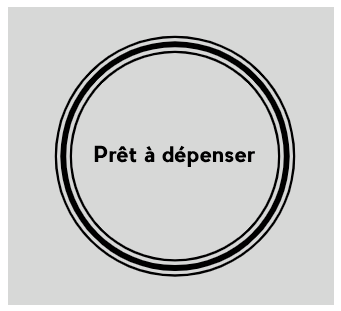

 # <span class='bg-primary'>P7_01_05 - MODELISATION</span>

Ce notebook traite de la modélisation

En particulier :

- **choix algorithme** : utilisation de Pycaret pour lancer les différents modèles de classification installés dans nos environnements pour classer les modèles qui semblent être les plus performants pour notre jeu de données et en prenant en compte les différents scores, sélectionner le modèle le plus prometteur.
- **choix du jeu de données** : utilisation de Pycaret pour entraîner les modèles de classification sur nos différents jeux de données issus du feature engineering et du feature selection (imputation avec la médiane/mode avec ou sans la variable magique Kaggle, étendu ou réduit ; imputation avec les constantes 0/XNA ou imputation avec NanImputer/ constante XNA) pour sélectionner le jeu de données à utiliser.
- **choix des métriques** : adaptées aux contraintes métiers de notre problématique.
- **optimisation modèle** : en traitant le déséquilibrage des classes, en sélectionnant les meilleurs hyperparamètres de notre modèle pour défavoriser le nombre de faux négatifs (prêt accordé non remboursé donc énormer perte d'argent pour Home Crédit).

***
Sources
***
- [Métriques_classification_théorie](https://www.deepl.com/fr/translator#en/fr/10.%20F-score%0ASimply%20put%2C%20it%20combines%20precision%20and%20recall%20into%20one%20metric.%20The%20higher%20the%20score%20the%20better%20our%20model%20is.%20You%20can%20calculate%20it%20in%20the%20following%20way%3A%0A)
- [Métriques_sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
- [Pycaret](https://pycaret.readthedocs.io/en/latest/api/classification.html)
- [Pycaret_classification](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)
- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [BayesianOptimisation](https://github.com/fmfn/BayesianOptimization)

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [99]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [164]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
import outils_model
import pickle
from collections import Counter

# Visualisation
import matplotlib
import matplotlib.pyplot as plt

# Data pré-processing
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    PowerTransformer, RobustScaler
from imblearn.over_sampling import SMOTE  # Oversampling
from imblearn.under_sampling import RandomUnderSampler # UnderSampling
from imblearn.pipeline import Pipeline

# Modelisation
# Préparation
from sklearn.model_selection import train_test_split, StratifiedKFold


# Modèles
import pycaret
from pycaret.classification import *
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Optimisation bayésienne
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Real, Categorical, Integer
# Optimisation optuna
import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Pycaret               : ' + pycaret.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Optuna                : ' + optuna.__version__)
print('Outils model          : ' + outils_model.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Scikit-learn          : 0.23.2
Matplotlib            : 3.3.4
Pycaret               : 2.3.0
Lightgbm              : 3.1.1
Optuna                : 2.6.0
Outils model          : 0.0.1
Lancé le           : 2021-08-04T19:03:50.977408


In [3]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

**Chargement des dataframes issus du pré-processing**

<span style='background:Moccasin'>**Train_set/test_set**</span>

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [4]:
fic_sav_train_set = \
    '../sauvegarde/features-selection/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 104)

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [5]:
fic_sav_test_set = \
    '../sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 103)

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set_sans_var_magique** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [4]:
fic_sav_train_set_sans = \
    '../sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set_sans_var_magique = pickle.load(df_appli_train_set_sans)
train_set_sans_var_magique.shape

(307507, 108)

- **test_set_sans_var_magique** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [5]:
fic_sav_test_set_sans = \
    '../sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set_sans_var_magique = pickle.load(df_appli_test_set_sans)
test_set_sans_var_magique.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : médiane,
    - valeurs qualitatives : mode.

<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

- **train_imp1_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [8]:
fic_sav_train_imp1_set = \
    '../sauvegarde/features-selection/train_imp1_set.pickle'
# Chargement de train_imp1_set
with open(fic_sav_train_imp1_set, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 108)

- **test_imp1_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [9]:
fic_sav_test_imp1_set = \
    '../sauvegarde/features-selection/test_imp1_set.pickle'
# Chargement de test_imp1_set
with open(fic_sav_test_imp1_set, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : constante 0,
    - valeurs qualitatives : constante XNA.

<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

- **train_imp2_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [10]:
fic_sav_train_imp2_set = \
    '../sauvegarde/features-selection/train_imp2_set.pickle'
# Chargement de train_imp2_set
with open(fic_sav_train_imp2_set, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 97)

- **test_imp2_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [11]:
fic_sav_test_imp2_set = \
    '../sauvegarde/features-selection/test_imp2_set.pickle'
# Chargement de test_imp2_set
with open(fic_sav_test_imp2_set, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 96)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : NaNImputer de la librairie Verstack,
    - valeurs qualitatives : constante XNA.

## <span style='background:Thistle'>3. Première idée sur les modèles avec pycaret</span>

L'idée d'utiliser pycaret est :
- d'avoir une **première impression sur les modèles** avec les hyperparamètres de base pour choisir le modèle à optimiser,
- et de voir l'**impact sur les scores** en fonction des différentes imputation effectuées lors du pré-processing pour choisir le jeu de données à conserver qui donne les meilleurs résultats.

***Note*** :
***
 Paramètre d'initialisation pour les jeux de données déséquilibrés comme c'est notre cas :
- **fix_imbalance** : bool, défaut = False. Lorsque l'ensemble de données d'apprentissage présente une distribution inégale de la classe cible, il peut être équilibré à l'aide de ce paramètre. Lorsqu'il est défini sur True, SMOTE (Synthetic Minority Over-sampling Technique) est appliqué par défaut pour créer des points de données synthétiques pour la classe minoritaire.
- **data_split_stratify** : bool ou liste, par défaut = False. Contrôle la stratification pendant 'train_test_split'. Si la valeur est True, la stratification se fera sur la colonne cible. Pour stratifier sur d'autres colonnes, passez une liste de noms de colonnes. Ignoré lorsque data_split_shuffle est False.

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)

### <span style='background:PowderBlue'>3.1. Pycaret : train_set</span>

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [45]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 108)"
5,Missing Values,False
6,Numeric Features,107
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.9950
xgboost,Extreme Gradient Boosting,0.9158,0.7562,0.0800,0.3930,0.1329,0.1086,0.1481,51.9390
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.2220
rf,Random Forest Classifier,0.9124,0.7342,0.0586,0.2897,0.0974,0.0722,0.0987,49.9230
gbc,Gradient Boosting Classifier,0.9019,0.7168,0.1046,0.2466,0.1468,0.1037,0.1146,125.7170
et,Extra Trees Classifier,0.9018,0.7124,0.0947,0.2331,0.1347,0.0924,0.1030,42.0720
ada,Ada Boost Classifier,0.8723,0.6979,0.1959,0.2010,0.1984,0.1290,0.1291,32.8100
lda,Linear Discriminant Analysis,0.7316,0.6739,0.4904,0.1484,0.2278,0.1185,0.1498,7.8820
knn,K Neighbors Classifier,0.6839,0.5661,0.3829,0.1040,0.1636,0.0419,0.0556,116.7160
nb,Naive Bayes,0.1113,0.5592,0.9762,0.0816,0.1506,0.0019,0.0174,5.3040


In [47]:
# Le meilleur modèle ?
print(best_models)

In [48]:
# Sauvegarde des scores
df_best_models_scores_sans = pull()
df_best_models_scores_sans

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.995
xgboost,Extreme Gradient Boosting,0.9158,0.7562,0.0800,0.3930,0.1329,0.1086,0.1481,51.939
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.222
rf,Random Forest Classifier,0.9124,0.7342,0.0586,0.2897,0.0974,0.0722,0.0987,49.923
gbc,Gradient Boosting Classifier,0.9019,0.7168,0.1046,0.2466,0.1468,0.1037,0.1146,125.717
et,Extra Trees Classifier,0.9018,0.7124,0.0947,0.2331,0.1347,0.0924,0.1030,42.072
ada,Ada Boost Classifier,0.8723,0.6979,0.1959,0.2010,0.1984,0.1290,0.1291,32.810
lda,Linear Discriminant Analysis,0.7316,0.6739,0.4904,0.1484,0.2278,0.1185,0.1498,7.882
knn,K Neighbors Classifier,0.6839,0.5661,0.3829,0.1040,0.1636,0.0419,0.0556,116.716
nb,Naive Bayes,0.1113,0.5592,0.9762,0.0816,0.1506,0.0019,0.0174,5.304


In [49]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
with open(fic_sav_train_set_scores_sans, 'wb') as f:
    pickle.dump(df_best_models_scores_sans, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 80 variables au lieu des 104 variables du train_set ?

In [6]:
fic_sav_train_set_sans_small = \
    '../sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_sans_small, 'rb') as df_appli_train_set_sans_small:
    train_set_sans_var_magique_small = \
        pickle.load(df_appli_train_set_sans_small)
train_set_sans_var_magique_small.shape

(307507, 80)

In [7]:
fic_sav_test_set_sans_small = \
    '../sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_sans_small, 'rb') as df_appli_test_sans_set_small:
    test_set_sans_var_magique_small = \
        pickle.load(df_appli_test_sans_set_small)
test_set_sans_var_magique_small.shape

(48744, 79)

In [23]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans_small',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 80)"
5,Missing Values,False
6,Numeric Features,79
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_sans_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.1870
xgboost,Extreme Gradient Boosting,0.9149,0.7564,0.0824,0.3757,0.1351,0.1093,0.1453,41.2410
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.0440


In [25]:
# Le meilleur modèle ?
print(best_models_sans_small)

In [26]:
# Sauvegarde des scores
df_best_models_scores_sans_small = pull()
df_best_models_scores_sans_small

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.187
xgboost,Extreme Gradient Boosting,0.9149,0.7564,0.0824,0.3757,0.1351,0.1093,0.1453,41.241
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.044


In [27]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
with open(fic_sav_train_set_scores_sans_small, 'wb') as f:
    pickle.dump(df_best_models_scores_sans_small, f, pickle.HIGHEST_PROTOCOL)

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [10]:
# Classification PyCaret - Initialisation
exp_name = setup(data=train_set,
                 target='TARGET',
                 fix_imbalance=True,
                 data_split_stratify=True,
                 session_id=21,
                 log_experiment=True,
                 experiment_name='train_set',
                 silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 104)"
5,Missing Values,False
6,Numeric Features,103
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.2930
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.1270
xgboost,Extreme Gradient Boosting,0.9159,0.7647,0.0819,0.3981,0.1359,0.1114,0.1514,49.8680
rf,Random Forest Classifier,0.9124,0.7500,0.0634,0.2994,0.1046,0.0786,0.1058,48.3770
gbc,Gradient Boosting Classifier,0.9013,0.7365,0.1135,0.2525,0.1566,0.1121,0.1223,118.7920
et,Extra Trees Classifier,0.8999,0.7317,0.1147,0.2445,0.1561,0.1103,0.1193,40.7100
ada,Ada Boost Classifier,0.8745,0.7102,0.1853,0.2005,0.1925,0.1247,0.1248,31.3740
lda,Linear Discriminant Analysis,0.7544,0.6942,0.5061,0.1657,0.2496,0.1457,0.1784,6.7030
knn,K Neighbors Classifier,0.6853,0.5642,0.3798,0.1039,0.1631,0.0416,0.0549,103.8520
nb,Naive Bayes,0.1102,0.5599,0.9765,0.0815,0.1505,0.0018,0.0163,4.5900


3:40: E261 at least two spaces before inline comment
4:29: E124 29


In [12]:
# Le meilleur modèle ?
print(best_models)

In [15]:
# Sauvegarde des scores
df_best_models_scores = pull()
df_best_models_scores

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.293
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127
xgboost,Extreme Gradient Boosting,0.9159,0.7647,0.0819,0.3981,0.1359,0.1114,0.1514,49.868
rf,Random Forest Classifier,0.9124,0.7500,0.0634,0.2994,0.1046,0.0786,0.1058,48.377
gbc,Gradient Boosting Classifier,0.9013,0.7365,0.1135,0.2525,0.1566,0.1121,0.1223,118.792
et,Extra Trees Classifier,0.8999,0.7317,0.1147,0.2445,0.1561,0.1103,0.1193,40.710
ada,Ada Boost Classifier,0.8745,0.7102,0.1853,0.2005,0.1925,0.1247,0.1248,31.374
lda,Linear Discriminant Analysis,0.7544,0.6942,0.5061,0.1657,0.2496,0.1457,0.1784,6.703
knn,K Neighbors Classifier,0.6853,0.5642,0.3798,0.1039,0.1631,0.0416,0.0549,103.852
nb,Naive Bayes,0.1102,0.5599,0.9765,0.0815,0.1505,0.0018,0.0163,4.590


In [17]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
with open(fic_sav_train_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 70 variables au lieu des 108 variables du train_set ?

In [8]:
fic_sav_train_set_small = \
    '../sauvegarde/features-selection/train_set_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_small, 'rb') as df_appli_train_set_small:
    train_set_small = \
        pickle.load(df_appli_train_set_small)
train_set_small.shape

(307507, 70)

In [9]:
fic_sav_test_set_small = \
    '../sauvegarde/features-selection/test_set_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_small, 'rb') as df_appli_test_set_small:
    test_set_small = \
        pickle.load(df_appli_test_set_small)
test_set_small.shape

(48744, 69)

In [31]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_small',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 70)"
5,Missing Values,False
6,Numeric Features,69
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.5570
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.4490
xgboost,Extreme Gradient Boosting,0.9141,0.7600,0.0865,0.3652,0.1398,0.1123,0.1457,34.9700


In [33]:
# Le meilleur modèle ?
print(best_models_small)

In [34]:
# Sauvegarde des scores
df_best_models_scores_small = pull()
df_best_models_scores_small

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.557
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.449
xgboost,Extreme Gradient Boosting,0.9141,0.7600,0.0865,0.3652,0.1398,0.1123,0.1457,34.970


In [35]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
with open(fic_sav_train_set_scores_small, 'wb') as f:
    pickle.dump(df_best_models_scores_small, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.2. Pycaret : train_imp1_set</span>

In [19]:
# Classification PyCaret - Initialisation
exp_name_imp1 = setup(data=train_imp1_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp1_set',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 108)"
5,Missing Values,False
6,Numeric Features,107
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp1 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.2990
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.5700
xgboost,Extreme Gradient Boosting,0.9157,0.7645,0.0838,0.3948,0.1382,0.1133,0.1523,52.7060
rf,Random Forest Classifier,0.9098,0.7490,0.0844,0.2954,0.1313,0.0989,0.1210,47.5610
gbc,Gradient Boosting Classifier,0.9008,0.7294,0.1248,0.2605,0.1687,0.1228,0.1323,138.7630
et,Extra Trees Classifier,0.8976,0.7281,0.1250,0.2411,0.1646,0.1158,0.1230,40.1750
ada,Ada Boost Classifier,0.8700,0.7092,0.2073,0.2024,0.2048,0.1341,0.1341,31.8560
lda,Linear Discriminant Analysis,0.7599,0.6885,0.4791,0.1634,0.2437,0.1401,0.1690,5.8200
knn,K Neighbors Classifier,0.6922,0.5717,0.3834,0.1071,0.1675,0.0472,0.0618,138.4010
lr,Logistic Regression,0.6909,0.5708,0.3764,0.1050,0.1641,0.0435,0.0570,10.3380


In [21]:
# Le meilleur modèle ?
print(best_models_imp1)

In [22]:
# Sauvegarde des scores
df_best_models_scores_imp1 = pull()
df_best_models_scores_imp1

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.299
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.570
xgboost,Extreme Gradient Boosting,0.9157,0.7645,0.0838,0.3948,0.1382,0.1133,0.1523,52.706
rf,Random Forest Classifier,0.9098,0.7490,0.0844,0.2954,0.1313,0.0989,0.1210,47.561
gbc,Gradient Boosting Classifier,0.9008,0.7294,0.1248,0.2605,0.1687,0.1228,0.1323,138.763
et,Extra Trees Classifier,0.8976,0.7281,0.1250,0.2411,0.1646,0.1158,0.1230,40.175
ada,Ada Boost Classifier,0.8700,0.7092,0.2073,0.2024,0.2048,0.1341,0.1341,31.856
lda,Linear Discriminant Analysis,0.7599,0.6885,0.4791,0.1634,0.2437,0.1401,0.1690,5.820
knn,K Neighbors Classifier,0.6922,0.5717,0.3834,0.1071,0.1675,0.0472,0.0618,138.401
lr,Logistic Regression,0.6909,0.5708,0.3764,0.1050,0.1641,0.0435,0.0570,10.338


In [23]:
# Sauvegarde des scores des best models du train_imp1_set
fic_sav_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
with open(fic_sav_train_imp1_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp1, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.3. Pycaret : train_imp2_set</span>

In [24]:
# Classification PyCaret - Initialisation
exp_name_imp2 = setup(data=train_imp2_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp2_set',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 97)"
5,Missing Values,False
6,Numeric Features,96
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp2 = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.1510
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.1750
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.2950
rf,Random Forest Classifier,0.9127,0.7528,0.0614,0.3012,0.1020,0.0767,0.1047,44.7410
gbc,Gradient Boosting Classifier,0.9052,0.7401,0.1025,0.2698,0.1485,0.1089,0.1234,125.9060
et,Extra Trees Classifier,0.9023,0.7371,0.1132,0.2596,0.1576,0.1142,0.1254,37.8280
ada,Ada Boost Classifier,0.8804,0.7253,0.1852,0.2175,0.2000,0.1359,0.1364,30.1030
lda,Linear Discriminant Analysis,0.7547,0.7065,0.5223,0.1694,0.2558,0.1525,0.1874,6.8730
qda,Quadratic Discriminant Analysis,0.1474,0.5692,0.9504,0.0829,0.1525,0.0047,0.0283,8.8330
knn,K Neighbors Classifier,0.6843,0.5652,0.3800,0.1035,0.1627,0.0410,0.0543,103.8960


In [27]:
# Le meilleur modèle ?
print(best_models_imp2)

In [28]:
# Sauvegarde des scores
df_best_models_scores_imp2 = pull()
df_best_models_scores_imp2

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.151
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.175
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.295
rf,Random Forest Classifier,0.9127,0.7528,0.0614,0.3012,0.1020,0.0767,0.1047,44.741
gbc,Gradient Boosting Classifier,0.9052,0.7401,0.1025,0.2698,0.1485,0.1089,0.1234,125.906
et,Extra Trees Classifier,0.9023,0.7371,0.1132,0.2596,0.1576,0.1142,0.1254,37.828
ada,Ada Boost Classifier,0.8804,0.7253,0.1852,0.2175,0.2000,0.1359,0.1364,30.103
lda,Linear Discriminant Analysis,0.7547,0.7065,0.5223,0.1694,0.2558,0.1525,0.1874,6.873
qda,Quadratic Discriminant Analysis,0.1474,0.5692,0.9504,0.0829,0.1525,0.0047,0.0283,8.833
knn,K Neighbors Classifier,0.6843,0.5652,0.3800,0.1035,0.1627,0.0410,0.0543,103.896


In [29]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
with open(fic_sav_train_imp2_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp2, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.4. Pycaret : bilan</span>

In [37]:
# Scores du train_set avec variable magique
fic_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
# Chargement de train_set
with open(fic_train_set_scores, 'rb') as df_pycaret_train_set:
    df_best_models_scores = pickle.load(df_pycaret_train_set)
df_best_models_scores.shape

(15, 9)

In [38]:
# Scores du train_set sans la variable magique
fic_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans, 'rb') as df_pycaret_train_set_sans:
    df_best_models_scores_sans = pickle.load(df_pycaret_train_set_sans)
df_best_models_scores_sans.shape

(15, 9)

In [44]:
# Scores du train_set sans variable magique, réduit
fic_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans_small, 'rb') as df_pycaret_trainsanssmall:
    df_best_models_scores_sans_small = \
        pickle.load(df_pycaret_trainsanssmall)
df_best_models_scores_sans_small.shape

(3, 9)

In [45]:
# Scores du train_set avec variable magique, réduit
fic_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_small, 'rb') as df_pycaret_train_small:
    df_best_models_scores_small = \
        pickle.load(df_pycaret_train_small)
df_best_models_scores_small.shape

(3, 9)

In [46]:
# Scores du train_imp1_set
fic_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
# Chargement de train_imp1_set
with open(fic_train_imp1_set_scores, 'rb') as df_pycaret_train_imp1_set:
    df_best_models_scores_imp1 = pickle.load(df_pycaret_train_imp1_set)
df_best_models_scores_imp1.shape

(15, 9)

In [47]:
# Scores du train_imp2_set
fic_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
# Chargement de train_imp2_set
with open(fic_train_imp2_set_scores, 'rb') as df_pycaret_train_imp2_set:
    df_best_models_scores_imp2 = pickle.load(df_pycaret_train_imp2_set)
df_best_models_scores_imp2.shape

(15, 9)

In [48]:
# Ajout du jeu de données pour identifier les scores
df_best_models_scores['Jeu_donnees'] = 'train_set'
df_best_models_scores_sans['Jeu_donnees'] = 'train_set_sans'
df_best_models_scores_small['Jeu_donnees'] = 'train_set_small'
df_best_models_scores_sans_small['Jeu_donnees'] = 'train_set_sans_small'
df_best_models_scores_imp1['Jeu_donnees'] = 'train_imp1_set'
df_best_models_scores_imp2['Jeu_donnees'] = 'train_imp2_set'

In [49]:
# Constitution d'un seul dataframes
df_best_models_scores_all = \
    df_best_models_scores.append(df_best_models_scores_sans)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_sans_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp1)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp2)
df_best_models_scores_all.shape

(66, 10)

In [56]:
# Tri avec métrique AUC
df_tri = df_best_models_scores_all.sort_values(by='AUC', ascending=False)
df_tri

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
catboost,CatBoost Classifier,0.9183,0.7796,0.0723,0.4603,0.1250,0.1054,0.1579,63.151,train_imp2_set
catboost,CatBoost Classifier,0.9179,0.7769,0.0735,0.4477,0.1263,0.1060,0.1561,65.299,train_imp1_set
catboost,CatBoost Classifier,0.9180,0.7763,0.0716,0.4501,0.1236,0.1037,0.1546,64.293,train_set
lightgbm,Light Gradient Boosting Machine,0.9175,0.7731,0.0466,0.4025,0.0834,0.0679,0.1146,9.175,train_imp2_set
catboost,CatBoost Classifier,0.9171,0.7714,0.0742,0.4215,0.1262,0.1046,0.1502,57.557,train_set_small
xgboost,Extreme Gradient Boosting,0.9162,0.7690,0.0808,0.4044,0.1346,0.1107,0.1521,49.295,train_imp2_set
catboost,CatBoost Classifier,0.9179,0.7685,0.0683,0.4452,0.1184,0.0991,0.1498,65.995,train_set_sans
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127,train_set
lightgbm,Light Gradient Boosting Machine,0.9169,0.7672,0.0539,0.3937,0.0947,0.0768,0.1214,8.570,train_imp1_set
catboost,CatBoost Classifier,0.9174,0.7665,0.0725,0.4318,0.1241,0.1033,0.1510,63.187,train_set_sans_small


**Bilan** : 
***
- **Jeux de données** à utiliser (selon l'imputation effectuée) :
    - Les scores sont légèrement supérieurs pour le jeu de données train_imp2_set que pour le jeu de données train_set.
    - Mais il est difficile d'expliquer l'imputation avec NaNImputer par la librairie verstack à un utilisateur non datascientist alors qu'il est facile d'expliquer l'utilisation de la valeur moyenne pour les variables numériques et le mode ou la valeur la plus utilisée pour les variables catégorielles.
    - L'imputation par la librairie verstack est également beaucoup plus longues (presque 25 minutes au lieu de quelques secondes pour la médiane).
    - les jeux de données train_set/test_set seront utilisés pour entraîner et valider le modèle.
- **Modèles** : en se basant sur la métrique AUC, 3 modèles se détachent :
    - Catboost Classifier,
    - Light Gradient Boosting Machine,
    - Extreme Gradient Boosting Machine.
    - Observons les autres métriques pour départager nos 3 modèles.

In [57]:
mask_model = df_best_models_scores_all['Model'] \
    .isin(['CatBoost Classifier', 'Light Gradient Boosting Machine',
           'Extreme Gradient Boosting'])
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare = df_best_models_scores_all[mask_model & mask_jeu]

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur. 
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximise le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

[Source](https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a)

**Choix du modèle**

In [87]:
# Tri avec métrique AUC
df_compare.groupby(['Model','Jeu_donnees']).agg({'AUC' : max}) \
    .sort_values(by=['Model', 'AUC'], ascending=[True, False]).unstack()

AUC                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.7763         0.7685               0.7665          0.7714
Extreme Gradient Boosting          0.7647         0.7562               0.7564          0.7600
Light Gradient Boosting Machine    0.7674         0.7550               0.7520          0.7635

- Léger avantage au modèle Catboost, Lightgbm et xgboost ont des résultats proches.
- Les meilleurs résultats sont obtenus par le train_set et le train_set_small mais les résultats sont assez proches pour tous les jeux de données.

In [89]:
# Tri avec métrique Recall
df_compare.groupby(['Model','Jeu_donnees']).agg({'Recall' : max}) \
    .sort_values(by=['Model', 'Recall'], ascending=[True, False]).unstack()

Recall                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.0716         0.0683               0.0725          0.0742
Extreme Gradient Boosting          0.0819         0.0800               0.0824          0.0865
Light Gradient Boosting Machine    0.0487         0.0503               0.0541          0.0579

- Le meilleur résultat est obtenu par Xgboost, suivi par CatBoost avec un résultat 2 fois meilleur que pour Lightgbm mais le recall peut-être affiné en optimisant le modèle et le seuil de probabilité.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [91]:
# Tri avec métrique Precision
df_compare.groupby(['Model','Jeu_donnees']).agg({'Prec.' : max}) \
    .sort_values(by=['Model', 'Prec.'], ascending=[True, False]).unstack()

Prec.                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.4501         0.4452               0.4318          0.4215
Extreme Gradient Boosting          0.3981         0.3930               0.3757          0.3652
Light Gradient Boosting Machine    0.3737         0.3640               0.3390          0.3326

- Le meilleur résultat est obtenu par CatBoost, suivi par les 2 autres modèles qui ont des résultats proches.
- Au niveau des jeux de données, avantage pour le train_set suivi par  le train_set_sans mais les résultats sont assez proches pour tous les jeux de données.

In [92]:
# Tri avec métrique F1-Score
df_compare.groupby(['Model','Jeu_donnees']).agg({'F1' : max}) \
    .sort_values(by=['Model', 'F1'], ascending=[True, False]).unstack()

F1                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.1236         0.1184               0.1241          0.1262
Extreme Gradient Boosting          0.1359         0.1329               0.1351          0.1398
Light Gradient Boosting Machine    0.0862         0.0883               0.0932          0.0987

- Le meilleur résultat est obtenu par Xgboost, suivi par Catboost, Lightgbm est légèrement à la traîne sauf pour les train_set_small et  train_set_sans_small.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [93]:
# Tri avec métrique Temps
df_compare.groupby(['Model','Jeu_donnees']).agg({'TT (Sec)' : max}) \
    .sort_values(by=['Model', 'TT (Sec)'], ascending=[True, False]).unstack()

TT (Sec)                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                64.293         65.995               63.187          57.557
Extreme Gradient Boosting          49.868         51.939               41.241          34.970
Light Gradient Boosting Machine     9.127         10.222                7.044           6.449

- Lightgbm est le plus rapide (5 fois plus rapide que xgboost et 7 fois plus que Catboost qui est très lent).
- Sans surprise les jeux de données avec moins de variables (small) ont des temps de réponse plus rapides.

**Bilan** :
***
- Les résultats sont meilleurs pour Catboost mais légèrement supérieur pour Xgboost par rapport à Lightgbm, mais le modèle Lightgbm est 7 fois plus rapide que Catboost. Puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Les métriques peuvent être optimisées en jouant sur l'équilibrage du jeu de données, sur l'optimisation du modèle et sur le réglage du seuil de probabilité.
- Après analyse des résultats et des contraintes de notre problématique, **le modèle retenu sera Lightgbm**.

**Choix du jeu de données**

In [96]:
mask_model = df_best_models_scores_all['Model'] == 'Light Gradient Boosting Machine'
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare_jeu = df_best_models_scores_all[mask_model & mask_jeu]
df_compare_jeu

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
lightgbm,Light Gradient Boosting Machine,0.9166,0.7674,0.0487,0.3737,0.0862,0.0688,0.1108,9.127,train_set
lightgbm,Light Gradient Boosting Machine,0.9162,0.7550,0.0503,0.3640,0.0883,0.0701,0.1104,10.222,train_set_sans
lightgbm,Light Gradient Boosting Machine,0.9146,0.7635,0.0579,0.3326,0.0987,0.0766,0.1104,6.449,train_set_small
lightgbm,Light Gradient Boosting Machine,0.9152,0.7520,0.0541,0.3390,0.0932,0.0727,0.1083,7.044,train_set_sans_small


- La variable magique qui a permis de gagner le concours Kaggle offre un avantage sur l'accuracy mais a de moins bon résultat sur la métrique recall qui est très importante pour notre problématique. Comme elle est difficilement explicable et peut être controversée (comparaison avec d'autres individus) nous utiliserons les datasets sans cette variable sur **le jeu de données non réduit sans la variable magique Kaggle(train_set_sans_var_magique)**.

**Bilan** :
- Modèle : **Light Gradient Boosting Machine**.
- Jeu de données : **train_set_sans_var_magique**.

## <span style='background:Thistle'>4. Préparation du jeu de données</span>

**Nombre aléatoire**

In [6]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:PowderBlue'>4.1. Split du jeu d'entraînement en entraînement/validation</span>

**Vecteur y**

In [7]:
# Vecteur y cible
y = train_set_sans_var_magique['TARGET']
print(f'y : {y.shape}')

y : (307507,)


**Matrice X**

In [8]:
# Matrice X
X = train_set_sans_var_magique.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 107)


**Découpage du jeu d'entraînement**

In [9]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (246005, 107) - y_train : (246005,)
X_valid : (61502, 107) - y_valid : (61502,)


## <span style='background:Thistle'>5. Choix des métriques</span>

### <span style='background:PowderBlue'>5.1. Métriques de classification binaire</span>

Comme nous en avons déjà discuté dans la partie ***3.4. Pycaret : bilan***, différentes métriques existent pour les modélisations de classification binaire.

**Problématique**
***
- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs (erreur de type II)** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs (erreur de type I)** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.
    
**Métriques**
***
-  **Recall** : la métrique pour déterminer le **taux de vrais positif** est le Rappel(Sensibilité)/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
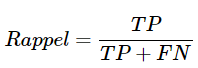

- **Precision** : elle mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.
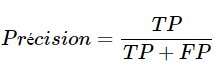

- **F-mesure ou F1** : compromis entre le rappel et précision.
    -  Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
    - Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
    - Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

- **Score ROC AUC** : le score ROC AUC est équivalent au calcul de la corrélation de rang entre les prédictions et la cible. Du point de vue de l'interprétation, il est plus utile car il nous indique que cette métrique montre à quel point votre modèle est bon pour classer les prédictions. Elle vous indique la probabilité qu'une instance positive choisie au hasard soit classée plus haut qu'une instance négative choisie au hasard.

- **Score PR AUC** : calcule de l'aire sous la courbe précision-rappel pour obtenir un nombre qui vous donne des informations sur la performance du modèle. A utiliser : 
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - quand vous vous souciez plus de la classe positive que de la classe négative. Si vous vous souciez davantage de la classe positive et donc du PPV et du TPR, vous devriez opter pour la courbe Precision-Recall et la PR AUC (précision moyenne).


**Notes :**
***
- La librairie sklearn permet de calculer tous ses scores.
- Une fonction permettra d calculer et de sauvegarder ses différents scores lors de la modélisation : <span style='background:PaleGreen'>**outils_model.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

### <span style='background:PowderBlue'>5.2. Métriques métiers</span>

**Score pénalisant les faux négatifs**
- Les métriques ci-dessus ne pénalisent pas les faux négatifs sauf le Fbeta qui en utilisant une valeur supérieure à 1 pénalise plus les faux négatifs.
- Nous allons donc créer une métrique métier tentant d'optimiser notre modèle de classification grâce à la personnalisation de la fonction de perte pour définir à la main le coût des faux positifs/négatifs et des vrais positifs/négatifs.
- Cette métrique métier est définie dans la fonction <span style='background:PaleGreen'>**outils_model.custom_score**</span>.

**Seuil de probabilité**
- La valeur du seuil de probabilité à 0.5 par défaut pourra également être réglée pour tenter d'optimiser les performances du modèles pour notre métrique métier. Le seuil optimal de bascule de la classe 0 à la classe 1 devra être déterminée pour chacun des modèles entraînés avec la métrique métier comme score.
- Cette fonction sera appelée: <span style='background:PaleGreen'>**outils_model.determiner_seuil_probabilte**</span>.

## <span style='background:Thistle'>6. Modélisation</span>

In [13]:
df_resultats = pd.DataFrame({})

In [48]:
df_taux = pd.DataFrame({})

In [10]:
# Chargement du dataframe de sauvegardes des scores des modèles
fic_df_resultat_scores = \
    '../sauvegarde/modelisation/df_resultat_scores.pickle'
with open(fic_df_resultat_scores, 'rb') as df_resultat_scores:
    df_resultats = pickle.load(df_resultat_scores)

In [11]:
# Chargement du dataframe de sauvegardes des différents taux :
# TN : vrais négatifs, TP : vrais positifs
# FP : faux positifs, FN : faux négatifs
fic_df_taux = '../sauvegarde/modelisation/df_taux.pickle'
with open(fic_df_taux, 'rb') as df_taux:
    df_taux = pickle.load(df_taux)

In [12]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
pr_auc = make_scorer(average_precision_score, greater_is_better=True,
                     needs_proba=True)
f10_score = make_scorer(fbeta_score, beta=10, greater_is_better=True)
custom_score = make_scorer(outils_model.custom_score,
                           greater_is_better=True)
custom_score_2 = make_scorer(outils_model.custom_score_2,
                           greater_is_better=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### <span style='background:PowderBlue'>6.1. Modèle LGBM de base</span>

Les résultats constitue la baseline pour comparer les modèles optimisés.

**Sans rééquilibrage**

In [14]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base = LGBMClassifier(random_state=seed, verbose=0,
                           force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base,0.0403,0.5391,0.0750,0.0418,0.0407,0.7817,0.2703,0.5497,3.2154,3.3433,0.8357,0.0006,0.7839,0.0038,0.0579,0.0018,0.0384,0.0043,0.7482,0.0082,0.5449,0.0427


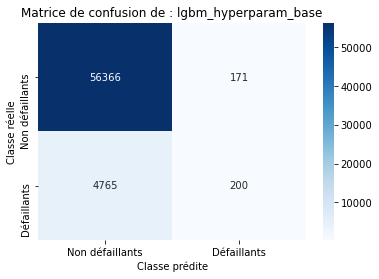

In [15]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base')

In [51]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base',
                                        4765, 171, 200, 56366, df_taux)

**Avec rééquilibrage**

In [63]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_bal = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True,
                               class_weight='balanced')

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_bal,0.6939,0.1851,0.2923,0.6275,0.6755,0.7837,0.2781,0.7141,3.6063,3.7418,0.8330,0.0004,0.7855,0.0042,0.7662,0.0019,0.6958,0.0121,0.2036,0.0006,0.1852,0.0026


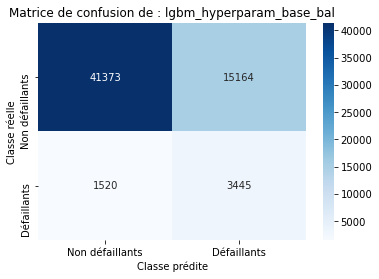

In [64]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_bal, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base_bal')

In [65]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_bal',
                                        1520, 15164, 3445, 41373, df_taux)

### <span style='background:PowderBlue'>6.2. Optimisation LGBM - Standardisation</span>

Normalement les modèles à base d'arbres décisionnels n'utilisant pas les distances ne nécessitent pas de données standardisées. La plupart des notebooks Kaggle utilisant la modélisation LightGBM utilise les données standardisées sans l'expliquer. Est-ce que cela peut avoir un fort impact sur notre modèle? Nous observerons l'impact de la standardisation sur notre jeu de données standardisé avec le modèle LightGBM de base.

<span style='background:Moccasin'>**6.2.1. Standardisation - StandardScaler**</span>

In [13]:
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_valid_std = scaler_std.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/standardisation_std.pickle', 'wb') as f:
    pickle.dump(scaler_std, f, pickle.HIGHEST_PROTOCOL)

**Sans rééquilibrage**

In [17]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_std,0.0429,0.5462,0.0796,0.0445,0.0433,0.7814,0.2702,0.5508,3.4533,3.5315,0.8355,0.0006,0.7848,0.0039,0.0565,0.0018,0.0375,0.0036,0.7446,0.0046,0.5504,0.0391


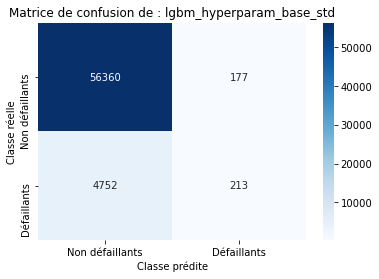

In [18]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std')

In [53]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_std',
                                        4752, 177, 213, 56360, df_taux)

**Avec rééquilibrage**

In [59]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std_bal = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True,
                                   class_weight='balanced')

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_std_bal,0.6924,0.1848,0.2918,0.6263,0.6741,0.7832,0.2777,0.7134,4.2667,4.3707,0.8330,0.0006,0.7858,0.0040,0.7662,0.0015,0.6960,0.0109,0.2038,0.0005,0.1853,0.0020


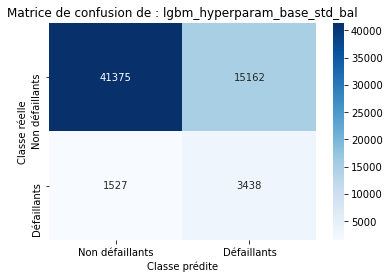

In [60]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std_bal, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std_bal')

In [61]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_std_bal',
                                        1527, 15162, 3438, 41375, df_taux)

<span style='background:Moccasin'>**6.2.2. Standardisation - MinMaxScaler**</span>

In [14]:
# MinMaxScaler
scaler_min = MinMaxScaler()

# Jeu de la target de consommation d'énergie non transformée en log10
X_train_min = scaler_min.fit_transform(X_train.copy(deep=True))
X_valid_min = scaler_min.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/scaler_min.pickle', 'wb') as f:
    pickle.dump(scaler_min, f, pickle.HIGHEST_PROTOCOL)

In [20]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_min = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_minmax,0.0415,0.5523,0.0772,0.0430,0.0419,0.7822,0.2737,0.5503,3.1045,3.1765,0.8356,0.0006,0.7846,0.0040,0.0577,0.0019,0.0390,0.0039,0.7486,0.0074,0.5560,0.0336


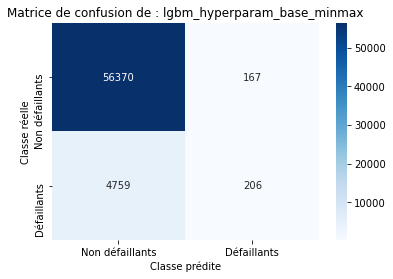

In [21]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_min, X_train_min,
                                        X_valid_min, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_minmax')

In [54]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_minmax',
                                        4759, 167, 206, 56370, df_taux)

<span style='background:Moccasin'>**6.2.3. Standardisation - PowerTransformer**</span>

In [29]:
# PowerTransformer
# Une transformation de Box Cox est une transformation d'une variable
# dépendante non normale en une forme normale.

scaler_pow = PowerTransformer(method='yeo-johnson')
X_train_pow = scaler_pow.fit_transform(X_train.copy(deep=True))
X_valid_pow = scaler_pow.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/scaler_pow.pickle', 'wb') as f:
    pickle.dump(scaler_pow, f, pickle.HIGHEST_PROTOCOL)

In [25]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_pow = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_power,0.0399,0.5577,0.0744,0.0414,0.0402,0.7814,0.2711,0.5496,3.5751,3.6649,0.8356,0.0008,0.7845,0.0042,0.0576,0.0012,0.0371,0.0043,0.7445,0.0057,0.5544,0.0353


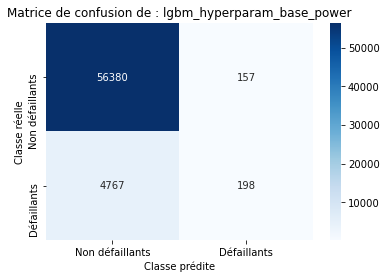

In [26]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_pow, X_train_pow,
                                        X_valid_pow, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_power')

In [55]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_power',
                                        4767, 157, 198, 56380, df_taux)

<span style='background:Moccasin'>**6.2.4. Standardisation - RobustScaler**</span>

In [32]:
# RobustScaler
scaler_rob = RobustScaler()

X_train_rob = scaler_rob.fit_transform(X_train.copy(deep=True))
X_valid_rob = scaler_rob.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/scaler_rob.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_rob = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_hyperparam_base_robust,0.0425,0.5466,0.0789,0.0441,0.0429,0.7812,0.2696,0.5507,2.8903,2.9782,0.8354,0.0004,0.7848,0.0043,0.0573,0.0021,0.0395,0.0035,0.7463,0.0061,0.5522,0.0281


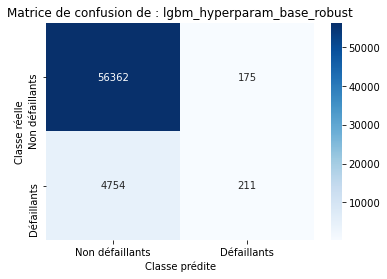

In [34]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_rob, X_train_rob,
                                        X_valid_rob, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_robust')

In [56]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_hyperparam_base_robust',
                                        4754, 175, 211, 56362, df_taux)

**Bilan** :
Seul StandardScaler diminue le nombre de faux négatifs (4752 au lieu de 4765) mais les scores sont proches de ceux sans la standardisation nous confortant dans la connaissance théorique que les algorithmes non basés sur des calculs de distances peuvent manipuler les données non standardisées.  

### <span style='background:PowderBlue'>6.3. Optimisation LGBM : Pycaret</span>

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)
[Source](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

#### <span style='background:Moccasin'>6.3.1. Optimisation LGBM : Pycaret - hyperopt</span>

In [10]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique,
                      target='TARGET',
                      fix_imbalance=True,  # SMOTE
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True,
                      n_jobs=1)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 108)"
5,Missing Values,False
6,Numeric Features,107
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# Instanciation du modèle
# Cette fonction entraîne et évalue la performance d'un estimateur donné
# en utilisant la validation croisée.
# La sortie de cette fonction est une grille de score avec les scores CV
# par pli.
lgbm_pycaret = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9164,0.7653,0.0512,0.3724,0.0900,0.0719,0.1134
1,0.9168,0.7612,0.0581,0.3976,0.1014,0.0825,0.1271
2,0.9165,0.7617,0.0570,0.3837,0.0992,0.0800,0.1225
3,0.9166,0.7485,0.0472,0.3694,0.0837,0.0666,0.1081
4,0.9167,0.7497,0.0461,0.3687,0.0819,0.0651,0.1067
5,0.9148,0.7460,0.0461,0.3125,0.0803,0.0608,0.0934
6,0.9166,0.7521,0.0564,0.3843,0.0984,0.0794,0.1221
7,0.9163,0.7557,0.0414,0.3462,0.0740,0.0577,0.0962
8,0.9163,0.7501,0.0489,0.3632,0.0862,0.0684,0.1087
9,0.9155,0.7596,0.0506,0.3424,0.0882,0.0688,0.1056


In [12]:
lgbm_tuned_hyperopt = tune_model(lgbm_pycaret,
                                 optimize='AUC',
                                 choose_better=True,
                                 search_library='tune-sklearn',
                                 search_algorithm='hyperopt',
                                 n_iter=20)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:31:56
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging_fraction is set=0.7001497403926249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001497403926249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging_fraction is set=0.7001497403926249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001497403926249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging

Log sync requires rsync to be installed.
The `start_trial` operation took 706.956 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9858777345382205
[LightGBM] [Warning] bagging_fraction is set=0.49882897929868447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49882897929868447
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9858777345382205
[LightGBM] [Warning] bagging_fraction is set=0.49882897929868447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49882897929868447
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.985877

The `start_trial` operation took 634.339 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7448984016196125
[LightGBM] [Warning] bagging_fraction is set=0.41980061890727116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41980061890727116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7448984016196125
[LightGBM] [Warning] bagging_fraction is set=0.41980061890727116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41980061890727116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744898

The `start_trial` operation took 448.984 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010508616
[LightGBM] [Warning] bagging_fraction is set=0.8979314484338562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979314484338562
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010508616
[LightGBM] [Warning] bagging_fraction is set=0.8979314484338562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979314484338562
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010

The `start_trial` operation took 689.271 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319235438
[LightGBM] [Warning] bagging_fraction is set=0.4239862219236935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4239862219236935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319235438
[LightGBM] [Warning] bagging_fraction is set=0.4239862219236935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4239862219236935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319

The `start_trial` operation took 515.014 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433870879
[LightGBM] [Warning] bagging_fraction is set=0.9400199674939479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400199674939479
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433870879
[LightGBM] [Warning] bagging_fraction is set=0.9400199674939479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400199674939479
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433

The `start_trial` operation took 388.535 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438713424
[LightGBM] [Warning] bagging_fraction is set=0.4565081120224003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4565081120224003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438713424
[LightGBM] [Warning] bagging_fraction is set=0.4565081120224003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4565081120224003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438

The `start_trial` operation took 269.272 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147770647
[LightGBM] [Warning] bagging_fraction is set=0.7384005371375841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384005371375841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147770647
[LightGBM] [Warning] bagging_fraction is set=0.7384005371375841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384005371375841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147

The `start_trial` operation took 625.573 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133

The `start_trial` operation took 667.491 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148923962
[LightGBM] [Warning] bagging_fraction is set=0.7365444520865639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365444520865639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148923962
[LightGBM] [Warning] bagging_fraction is set=0.7365444520865639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365444520865639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148

The `start_trial` operation took 446.898 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960694791475285
[LightGBM] [Warning] bagging_fraction is set=0.9642695711490155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642695711490155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960694791475285
[LightGBM] [Warning] bagging_fraction is set=0.9642695711490155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642695711490155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960

The `start_trial` operation took 294.519 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248942574
[LightGBM] [Warning] bagging_fraction is set=0.7938441401122143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938441401122143
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248942574
[LightGBM] [Warning] bagging_fraction is set=0.7938441401122143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938441401122143
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248

The `start_trial` operation took 667.201 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178502637
[LightGBM] [Warning] bagging_fraction is set=0.5132597822929917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5132597822929917
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178502637
[LightGBM] [Warning] bagging_fraction is set=0.5132597822929917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5132597822929917
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178

The `start_trial` operation took 319.340 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774008598
[LightGBM] [Warning] bagging_fraction is set=0.4935607125341918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935607125341918
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774008598
[LightGBM] [Warning] bagging_fraction is set=0.4935607125341918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935607125341918
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774

The `start_trial` operation took 346.901 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025410986801867
[LightGBM] [Warning] bagging_fraction is set=0.6981172412244331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981172412244331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025410986801867
[LightGBM] [Warning] bagging_fraction is set=0.6981172412244331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981172412244331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025

The `start_trial` operation took 410.799 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098439079
[LightGBM] [Warning] bagging_fraction is set=0.9819141482891017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819141482891017
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098439079
[LightGBM] [Warning] bagging_fraction is set=0.9819141482891017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819141482891017
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098

The `start_trial` operation took 735.791 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055306819
[LightGBM] [Warning] bagging_fraction is set=0.5511674930484717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5511674930484717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055306819
[LightGBM] [Warning] bagging_fraction is set=0.5511674930484717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5511674930484717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055

The `start_trial` operation took 423.322 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[LightGBM] [Warning] bagging_fraction is set=0.6572773224068174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6572773224068174
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[LightGBM] [Warning] bagging_fraction is set=0.6572773224068174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6572773224068174
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[Ligh

The `start_trial` operation took 527.343 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399507688006452
[LightGBM] [Warning] bagging_fraction is set=0.48718675425953417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48718675425953417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399507688006452
[LightGBM] [Warning] bagging_fraction is set=0.48718675425953417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48718675425953417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.639950

The `start_trial` operation took 523.406 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575867422
[LightGBM] [Warning] bagging_fraction is set=0.9313554266152752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313554266152752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575867422
[LightGBM] [Warning] bagging_fraction is set=0.9313554266152752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313554266152752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575

The `start_trial` operation took 769.071 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .              Selecting Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                         

                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine


In [16]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [17]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='auc', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'AUC.png'

In [18]:
plot_model(estimator=lgbm_tuned_hyperopt,
           plot='confusion_matrix', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Confusion Matrix.png'

In [19]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='error', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Prediction Error.png'

In [20]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='class_report', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Class Report.png'

In [22]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [23]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [32]:
# Sauvegarde du model pycaret optimisé hyperopt
fic_pycaret_lgbm_hyperopt = \
    '../sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'wb') as f:
    pickle.dump(lgbm_tuned_hyperopt, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# Sauvegarde du model pycaret de base
fic_pycaret_lgbm = \
    '../sauvegarde/modelisation/pycaret_lgbm.pickle'
with open(fic_pycaret_lgbm, 'wb') as f:
    pickle.dump(lgbm_pycaret, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

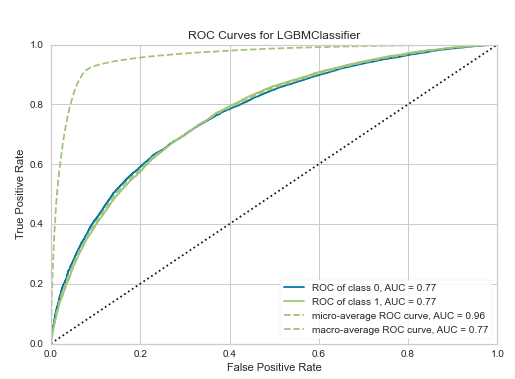
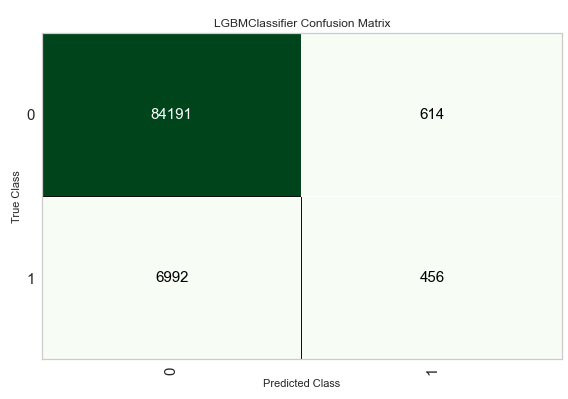
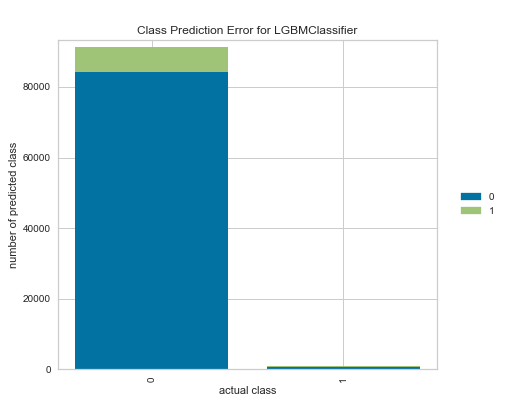
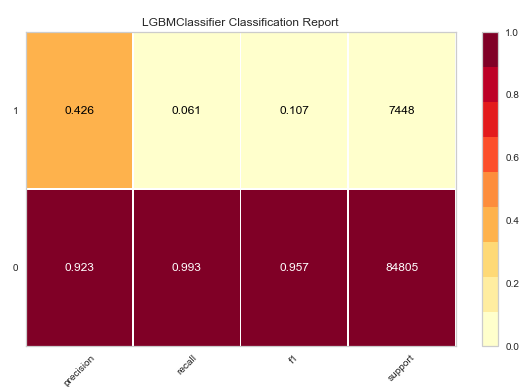

In [35]:
# Chargement du modèle pycaret LightGBM optimisé avec hyperopt
fic_pycaret_lgbm_hyperopt = \
    '../sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'rb') as model_pycaret_lgbm_hyperopt:
    pycaret_lgbm_hyperopt = pickle.load(model_pycaret_lgbm_hyperopt)

[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
pycaret_lgbm_hyperopt,0.0532,0.5443,0.0969,0.0551,0.0537,0.7839,0.2759,0.5552,27.7382,29.2432,0.9326,0.0005,0.7859,0.0042,0.1446,0.0021,0.0490,0.0051,0.9320,0.0039,0.5249,0.0428


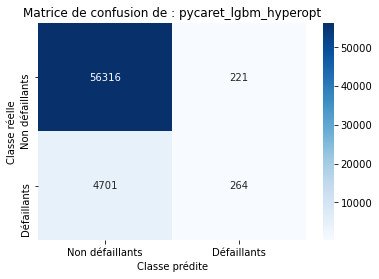

In [36]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_hyperopt,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_hyperopt')

In [66]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('pycaret_lgbm_hyperopt',
                                        4701, 221, 264, 56316, df_taux)

#### <span style='background:Moccasin'>6.3.2. Optimisation LGBM : Pycaret - optuna</span>

In [24]:
lgbm_tuned_optuna = tune_model(lgbm_pycaret,
                               optimize='AUC',
                               choose_better=True,
                               search_library='tune-sklearn',
                               search_algorithm='optuna',
                               n_iter=20)

IntProgress(value=0, description='Processing: ', max=7)
                                                                    
                                                                    
Initiated  . . . . . . . . . . . . . . . . . .              23:46:49
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .             Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                     

[I 2021-08-01 23:46:58,815] A new study created in memory with name: optuna


[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging

The `start_trial` operation took 630.940 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699

The `start_trial` operation took 652.343 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547

The `start_trial` operation took 639.306 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459

The `start_trial` operation took 749.535 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266

The `start_trial` operation took 491.203 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733

The `start_trial` operation took 684.815 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073

The `start_trial` operation took 329.401 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156

The `start_trial` operation took 547.178 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61906734810519

The `start_trial` operation took 410.166 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50603773763843

The `start_trial` operation took 503.004 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887

The `start_trial` operation took 492.706 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018

The `start_trial` operation took 751.459 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615

The `start_trial` operation took 689.888 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51682784649477

The `start_trial` operation took 625.606 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547

The `start_trial` operation took 632.015 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193

The `start_trial` operation took 503.272 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177

The `start_trial` operation took 277.683 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511

The `start_trial` operation took 632.424 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451749

The `start_trial` operation took 521.802 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432

The `start_trial` operation took 457.085 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .              Selecting Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                           

                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine


In [25]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [26]:
plot_model(estimator=lgbm_tuned_optuna, plot='auc', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'AUC.png'

In [27]:
plot_model(estimator=lgbm_tuned_optuna,
           plot='confusion_matrix', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Confusion Matrix.png'

In [28]:
plot_model(estimator=lgbm_tuned_optuna, plot='error', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Prediction Error.png'

In [29]:
plot_model(estimator=lgbm_tuned_optuna, plot='class_report', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Class Report.png'

In [30]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [31]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [34]:
# Sauvegarde du model pycaret optimisé optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'wb') as f:
    pickle.dump(lgbm_tuned_optuna, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

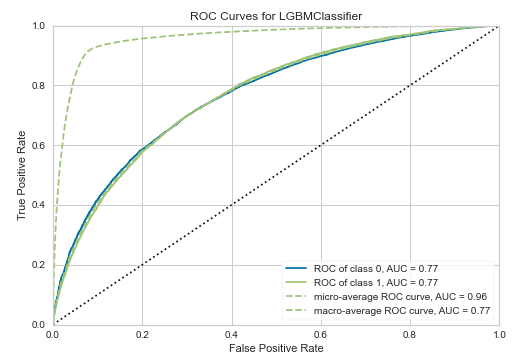
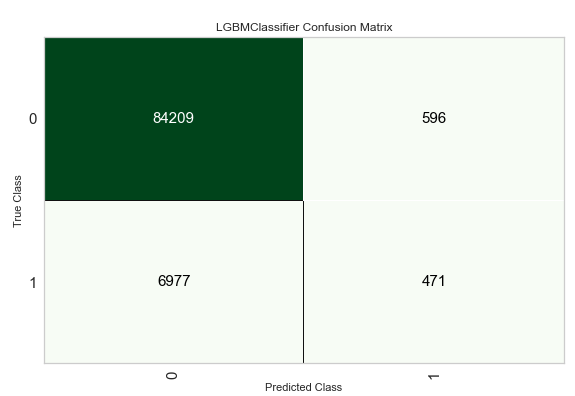
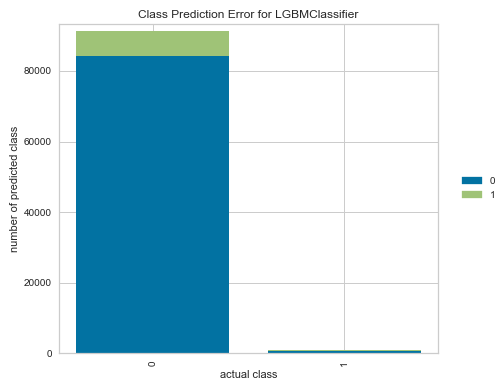
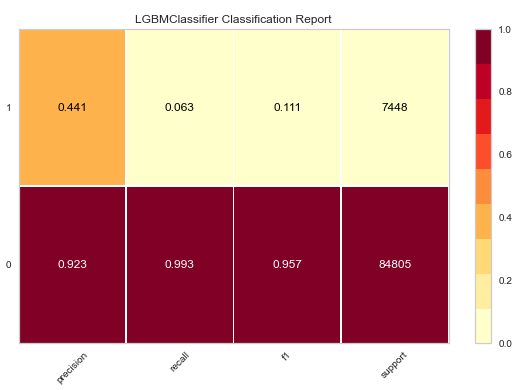

In [38]:
# Chargement du modèle pycaret LightGBM optimisé avec optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'rb') as model_pycaret_lgbm_optuna:
    pycaret_lgbm_optuna = pickle.load(model_pycaret_lgbm_optuna)

[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fract

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
pycaret_lgbm_optuna,0.0540,0.5425,0.0982,0.0559,0.0545,0.7823,0.2746,0.5555,29.2570,31.1913,0.9680,0.0002,0.7842,0.0048,0.2168,0.0021,0.0482,0.0046,0.9739,0.0022,0.5181,0.0405


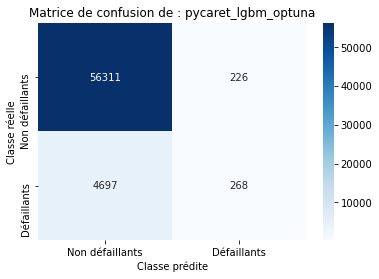

In [39]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_optuna,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_optuna')

In [67]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('pycaret_lgbm_optuna',
                                        4697, 226, 268, 56311, df_taux)

### <span style='background:PowderBlue'>6.4. Optimisation LGBM : meilleurs hyperparamètres BayesianOptimization</span>

Lors du projet 4, nous avons explorer l'optimisation en réglant les paramètres pas à pas, en utlisant RandomizedSearchCV, GridSearchCV et hyperopt. Nous allons découvrir l'optimisation Bayésienne en utilisant la librairie bayes_opt du MIT.

[Source](https://github.com/fmfn/BayesianOptimization)

#### <span style='background:Moccasin'>6.4.1. Optimisation LGBM : BayesianOptimization - Score ROC_AUC</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_1**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
    - class_weight

In [25]:
# Définition de l'objective fonction
def lgbm_eval_1(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [27]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_1 = \
    BayesianOptimization(lgbm_eval_1,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)})

bayesian_opt_1 = lgbm_bayesian_opt_1.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7831   |  0.966    |  8.361    |  14.01    |  59.09    |  0.08946  |  45.47    |  0.03352  |  0.2744   |  0.742    |
|  2        |  0.7831   |  0.8685   |  10.9     |  76.96    |  52.75    |  0.05748  |  48.29    |  0.2508   |  0.2461   |  0.6612   |
|  3        |  0.7841   |  0.9407   |  10.99    |  50.58    |  36.0     |  0.07775  |  49.68    |  0.2014   |  0.141    |  0.9124   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly s

In [29]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_1.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7101024215964218, 'max_depth': 9.431717186647465, 'min_child_samples': 14.626752832629807, 'min_child_weight': 16.1594230463445, 'min_split_gain': 0.015085290771675731, 'num_leaves': 30.66514394764758, 'reg_alpha': 0.08748239992345018, 'reg_lambda': 0.124459100415127, 'subsample': 0.9660850611753022}


In [33]:
param_lgbm_bayesian_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.7101024215964218,
                             'max_depth': 9,
                             'min_child_samples': 14,
                             'min_child_weight': 16.1594230463445,
                             'min_split_gain': 0.015085290771675731,
                             'num_leaves': 30,
                             'reg_alpha': 0.08748239992345018,
                             'reg_lambda': 0.124459100415127,
                             'subsample': 0.9660850611753022,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

**Sans le paramètre class_weight='balanced'**

In [31]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1 = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                     #class_weight='balanced',
                                     force_col_wise=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_1,0.0447,0.5781,0.0830,0.0464,0.0451,0.7829,0.2779,0.5518,2.9906,3.1010,0.8261,0.0005,0.7859,0.0045,0.0578,0.0015,0.0398,0.0044,0.7309,0.0046,0.5492,0.0565


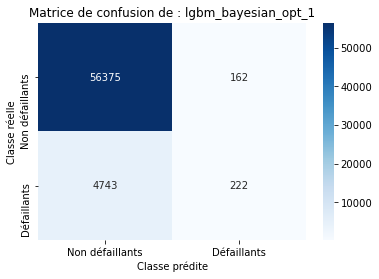

In [32]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1')

In [68]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_1',
                                        4743, 222, 162, 56375, df_taux)

**Avec le paramètre class_weight='balanced'**

In [34]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bis = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                         class_weight='balanced',
                                         force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_1_bis,0.6870,0.1841,0.2903,0.6217,0.6689,0.7832,0.2745,0.7112,3.2257,3.3315,0.8289,0.0005,0.7858,0.0043,0.7622,0.0011,0.6970,0.0126,0.2028,0.0004,0.1853,0.0027


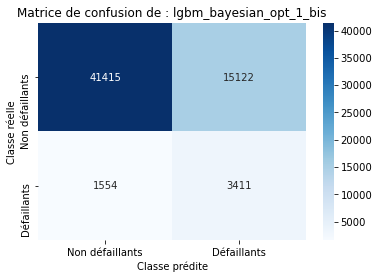

In [35]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bis,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bis')

In [69]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_1_bis',
                                        1554, 15122, 3411, 41415, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_2**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators
- sans forcer le paramètre :    
    - class_weight.

In [13]:
# Définition de l'objective fonction
def lgbm_eval_2(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [14]:
# Objective fonction 
lgbm_bayesian_opt_2 = \
    BayesianOptimization(lgbm_eval_2,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 21)

bayesian_opt_2 = lgbm_bayesian_opt_2.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7912   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.7895   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.7904   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.7908   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.7907   |  0.6062   |  7.244    |  31.84    |  38.34    |  0.08193  |  35.66    |  0.09261  |  0.1534   |  0.8499   |
|  6        |  0.7908   |  0.8952   |  6.606    |  54.39    | 

In [15]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_2.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.6511393949300122, 'max_depth': 7.0202392601094195, 'min_child_samples': 69.09583379089524, 'min_child_weight': 7.316873973324629, 'min_split_gain': 0.087433215157385, 'num_leaves': 25.09030790224134, 'reg_alpha': 0.02538395655016307, 'reg_lambda': 0.21627268379870196, 'subsample': 0.7086227872324751}


In [18]:
param_lgbm_bayesian_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6511393949300122,
                             'max_depth': 7,
                             'min_child_samples': 69,
                             'min_child_weight': 7.316873973324629,
                             'min_split_gain': 0.087433215157385,
                             'num_leaves': 25,
                             'reg_alpha': 0.02538395655016307,
                             'reg_lambda': 0.21627268379870196,
                             'subsample': 0.7086227872324751,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [19]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_2 = LGBMClassifier(**param_lgbm_bayesian_opt_2,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt,0.0608,0.5785,0.1101,0.0630,0.0614,0.7911,0.2903,0.5588,117.1676,125.8093,0.9076,0.0003,0.7935,0.0041,0.1264,0.0018,0.0541,0.0057,0.9005,0.0041,0.5506,0.0557


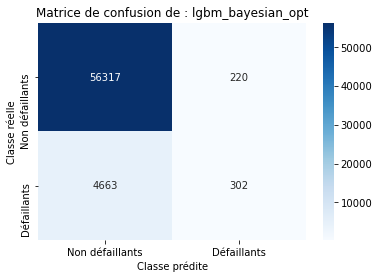

In [20]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_2')

- Le nombre de faux négatifs n'est guère moins élévé (4663) que le modèle de base (4765).

In [70]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_2',
                                        4663, 220, 302, 56317, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_3**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators,
    - class_weight.
- et en utilisant les hyperparamètres précedemment trouvés.    

In [22]:
param_lgbm_bayesian_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6511393949300122,
                             'max_depth': 7,
                             'min_child_samples': 69,
                             'min_child_weight': 7.316873973324629,
                             'min_split_gain': 0.087433215157385,
                             'num_leaves': 25,
                             'reg_alpha': 0.02538395655016307,
                             'reg_lambda': 0.21627268379870196,
                             'subsample': 0.7086227872324751,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [23]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_3 = LGBMClassifier(**param_lgbm_bayesian_opt_3,
                                     force_col_wise=True,
                                     class_weight='balanced'
                                    )

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_3,0.6356,0.2085,0.3140,0.5892,0.6230,0.7896,0.2878,0.7168,117.7728,125.7320,0.9132,0.0002,0.7918,0.0040,0.8688,0.0006,0.6400,0.0117,0.2817,0.0005,0.2106,0.0031


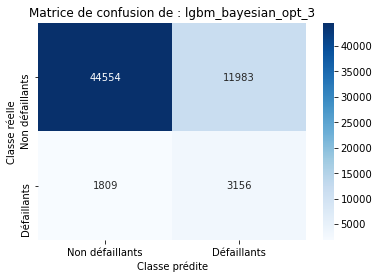

In [24]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_3')

In [71]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_3',
                                        1809, 11983, 3156, 44557, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_4**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.

In [41]:
# Définition de l'objective fonction
def lgbm_eval_4(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [42]:
# Objective fonction 
lgbm_bayesian_opt_4 = \
    BayesianOptimization(lgbm_eval_4,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6,11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = seed)

bayesian_opt_4 = lgbm_bayesian_opt_4.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7821   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.7819   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.7826   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.7828   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.7831   |  0.9609   |  8.414    |  26.4     |  28.68    |  0.02159  |  38.66    |  0.2258   |  0.1112   |  0.7364   |
|  6        |  0.7812   |  0.6899   |  8.218    |  25.91    | 

In [43]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_4.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.5562937202649061, 'max_depth': 10.07793739727663, 'min_child_samples': 78.51324627396895, 'min_child_weight': 35.36627630927947, 'min_split_gain': 0.021572866360225363, 'num_leaves': 36.18110954682392, 'reg_alpha': 0.13067753964743004, 'reg_lambda': 0.22725421560319015, 'subsample': 0.8143707267431972}


In [45]:
param_lgbm_bayesian_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.0.5562937202649061,
                             'max_depth': 10,
                             'min_child_samples': 78,
                             'min_child_weight': 35.36627630927947,
                             'min_split_gain': 0.021572866360225363,
                             'num_leaves': 36,
                             'reg_alpha': 0.13067753964743004,
                             'reg_lambda': 0.22725421560319015,
                             'subsample': 0.8143707267431972,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [46]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_4 = LGBMClassifier(**param_lgbm_bayesian_opt_4,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_4,0.6912,0.1867,0.2940,0.6262,0.6732,0.7840,0.2781,0.7148,3.1397,3.2644,0.8345,0.0004,0.7860,0.0044,0.7691,0.0014,0.6959,0.0110,0.2064,0.0007,0.1866,0.0024


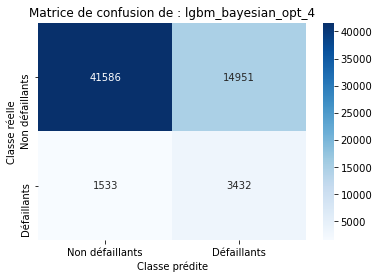

In [47]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_4')

In [72]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_4',
                                        1533, 14951, 3432, 41586, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_9**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
    - subsample_freq
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.
- en augmentant le nombre d'itérations de 20 à 100.    

In [42]:
# Définition de l'objective fonction
def lgbm_eval_9(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
#         'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [43]:
# Objective fonction 
lgbm_bayesian_opt_9 = \
    BayesianOptimization(lgbm_eval_9,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 42)

bayesian_opt_9 = lgbm_bayesian_opt_9.maximize(n_iter=100,
                                              init_points=5)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7852   |  0.6873   |  10.75    |  59.9     |  49.9     |  0.0156   |  28.9     |  0.01837  |  0.26     |  0.8006   |
|  2        |  0.7843   |  0.854    |  6.103    |  77.74    |  67.43    |  0.02123  |  29.55    |  0.05584  |  0.09197  |  0.7624   |
|  3        |  0.7842   |  0.716    |  7.456    |  50.89    |  15.46    |  0.02921  |  34.16    |  0.1374   |  0.2358   |  0.5998   |
|  4        |  0.7853   |  0.7571   |  8.962    |  8.484    |  50.57    |  0.01705  |  26.63    |  0.2847   |  0.2897   |  0.9042   |
|  5        |  0.784    |  0.6523   |  6.488    |  56.32    |  38.01    |  0.0122   |  37.38    |  0.01128  |  0.2729   |  0.6294   |
|  6        |  0.7855   |  0.9804   |  9.013    |  79.29    | 

|  31       |  0.7863   |  0.6883   |  10.29    |  28.79    |  71.34    |  0.04512  |  41.18    |  0.139    |  0.249    |  0.8214   |
|  32       |  0.7859   |  0.6987   |  11.0     |  31.9     |  69.24    |  0.0      |  41.64    |  0.3      |  0.001    |  0.8083   |
|  33       |  0.7859   |  0.7985   |  7.545    |  26.43    |  69.73    |  0.01537  |  43.62    |  0.06703  |  0.2295   |  0.6179   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_l

|  65       |  0.7858   |  0.7452   |  9.928    |  30.8     |  70.17    |  0.07938  |  39.38    |  0.1553   |  0.05949  |  0.8607   |
|  66       |  0.7859   |  0.8603   |  10.53    |  34.04    |  72.11    |  0.0025   |  41.29    |  0.2311   |  0.146    |  0.6909   |
|  67       |  0.786    |  0.8823   |  10.2     |  33.18    |  72.09    |  0.08679  |  36.32    |  0.07919  |  0.1778   |  0.9807   |
|  68       |  0.7857   |  0.5083   |  9.958    |  34.86    |  71.15    |  0.02103  |  38.31    |  0.2928   |  0.2255   |  0.928    |
|  69       |  0.7862   |  0.9984   |  10.56    |  25.58    |  64.31    |  0.03754  |  46.55    |  0.2943   |  0.1238   |  0.8874   |
|  70       |  0.7855   |  0.9426   |  7.961    |  24.91    |  62.81    |  0.07629  |  46.48    |  0.1139   |  0.08761  |  0.6011   |
|  71       |  0.7858   |  0.5214   |  10.93    |  22.24    |  61.7     |  0.06497  |  45.96    |  0.1122   |  0.1224   |  0.6073   |
|  72       |  0.7865   |  0.8777   |  10.59    |  26.95    | 

|  102      |  0.7859   |  0.9951   |  10.65    |  25.1     |  66.96    |  0.0581   |  47.63    |  0.2741   |  0.1807   |  0.6958   |
|  103      |  0.7858   |  0.6858   |  9.93     |  26.71    |  65.63    |  0.03501  |  43.41    |  0.2595   |  0.1598   |  0.5106   |
|  104      |  0.7864   |  0.7676   |  10.52    |  27.32    |  65.68    |  0.03091  |  43.5     |  0.1118   |  0.2      |  0.8266   |
|  105      |  0.7863   |  0.5851   |  9.178    |  20.48    |  62.27    |  0.03988  |  42.67    |  0.1117   |  0.1476   |  0.9591   |


In [45]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_9.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.501141962834127, 'max_depth': 10.398510601106999, 'min_child_samples': 20.926279763174712, 'min_child_weight': 63.63799914764137, 'min_split_gain': 0.012737434794598669, 'num_leaves': 42.34972995187978, 'reg_alpha': 0.027125352799584404, 'reg_lambda': 0.16180692951609094, 'subsample': 0.5171849934186235}


In [46]:
param_lgbm_bayesian_opt_9 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.501141962834127,
                             'max_depth': 10,
                             'min_child_samples': 20,
                             'min_child_weight': 63.63799914764137,
                             'min_split_gain': 0.012737434794598669,
                             'num_leaves': 42,
                             'reg_alpha': 0.027125352799584404,
                             'reg_lambda': 0.16180692951609094,
                             'subsample': 0.5171849934186235,
                             'verbosity' : -1}

In [47]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_9 = LGBMClassifier(**param_lgbm_bayesian_opt_9,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_9,0.6844,0.1875,0.2944,0.6211,0.6669,0.7845,0.2763,0.7138,3.3239,3.4597,0.8412,0.0004,0.7865,0.0044,0.7758,0.0011,0.6925,0.0092,0.2114,0.0004,0.1886,0.0018


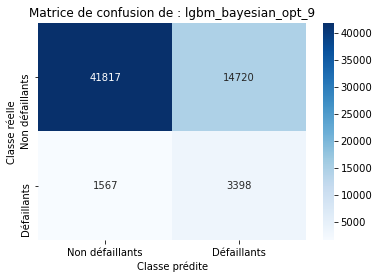

In [48]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_9')

In [49]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_9',
                                        1567, 14720, 3398, 41817, df_taux)

#### <span style='background:Moccasin'>6.4.2. Optimisation LGBM : BayesianOptimization - Avec la métrique métier</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_5**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [37]:
# Définition de l'objective fonction
def lgbm_eval_5(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
#         display(cv_preds)
    return outils_model.custom_score(y_train, np.rint(cv_preds))

In [38]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_5 = \
    BayesianOptimization(lgbm_eval_5,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_5 = lgbm_bayesian_opt_5.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7125   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.7132   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.7138   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.7147   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.7132   |  0.6642   |  7.779    |  25.84    |  30.0     |  0.02119  |  39.2     |  0.0788   |  0.2326   |  0.7179   |
|  6        |  0.7131   |  0.6227   |  8.424    |  19.81    | 

In [39]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_5.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.8332888200133821, 'max_depth': 7.806672192646711, 'min_child_samples': 25.364760055913173, 'min_child_weight': 29.946697529326762, 'min_split_gain': 0.04616962367444556, 'num_leaves': 38.22447342436773, 'reg_alpha': 0.20409599292315367, 'reg_lambda': 0.11929561039538764, 'subsample': 0.8992178328581777}


In [44]:
param_lgbm_bayesian_opt_5 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.8332888200133821,
                             'max_depth': 8,
                             'min_child_samples': 25,
                             'min_child_weight': 29.946697529326762,
                             'min_split_gain': 0.04616962367444556,
                             'num_leaves': 38,
                             'reg_alpha': 0.20409599292315367,
                             'reg_lambda': 0.11929561039538764,
                             'subsample': 0.8992178328581777,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [45]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_5 = LGBMClassifier(**param_lgbm_bayesian_opt_5,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_5,0.0455,0.5499,0.0841,0.0472,0.0459,0.7823,0.2737,0.5520,3.2276,3.3619,0.8324,0.0004,0.7855,0.0044,0.0645,0.0017,0.0441,0.0033,0.7461,0.0059,0.5785,0.0290
lgbm_bayesian_opt_5,0.6906,0.1884,0.2960,0.6264,0.6729,0.7836,0.2775,0.7162,3.3775,3.4925,0.8390,0.0005,0.7863,0.0045,0.7730,0.0018,0.6930,0.0120,0.2093,0.0006,0.1879,0.0024


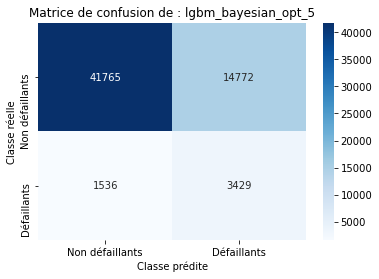

In [46]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_5')

In [47]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_5',
                                        1536, 14772, 3429, 41765, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_6**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=-1, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [51]:
# Définition de l'objective fonction
def lgbm_eval_6(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score_2', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
        
    return outils_model.custom_score_2(y_train, np.rint(cv_preds))

In [52]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_6 = \
    BayesianOptimization(lgbm_eval_6,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_6 = lgbm_bayesian_opt_6.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7187   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.7239   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.7265   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.7252   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.7258   |  0.503    |  7.527    |  35.28    |  60.0     |  0.04912  |  45.61    |  0.05169  |  0.07763  |  0.9864   |
|  6        |  0.7276   |  0.964    |  7.964    |  36.59    | 

In [54]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_6.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 1.0, 'max_depth': 11.0, 'min_child_samples': 56.5477688186488, 'min_child_weight': 80.0, 'min_split_gain': 0.09253880172400496, 'num_leaves': 50.0, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 0.5}


In [55]:
param_lgbm_bayesian_opt_6 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 57,
                             'min_child_weight': 80.0,
                             'min_split_gain': 0.09253880172400496,
                             'num_leaves': 50,
                             'reg_alpha': 0.3,
                             'reg_lambda': 0.3,
                             'subsample': 0.5,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [56]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_6 = LGBMClassifier(**param_lgbm_bayesian_opt_6,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_6,0.6747,0.1892,0.2955,0.6141,0.6580,0.7827,0.2722,0.7127,4.1691,4.2995,0.8484,0.0004,0.7849,0.0045,0.7821,0.0015,0.6836,0.0102,0.2172,0.0005,0.1905,0.0024


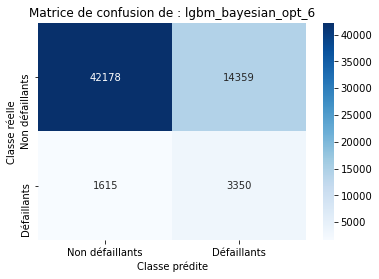

In [57]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_6')

In [58]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_6',
                                        1615, 14359, 3350, 42178, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score PR_AUC</span>

***
<span style='background:LightGreen'>**Modèle 7lgbm_bayesian_opt_7**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique PR_AUC comme métrique d'évaluation lors de la recherche bayésienne.

In [21]:
# Définition de l'objective fonction
def lgbm_eval_7(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return average_precision_score(y_train, cv_preds)

In [22]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_7 = \
    BayesianOptimization(lgbm_eval_7,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_7 = lgbm_bayesian_opt_7.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2731   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.2729   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.273    |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.2739   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.2734   |  0.6642   |  7.779    |  25.84    |  30.0     |  0.02119  |  39.2     |  0.0788   |  0.2326   |  0.7179   |
|  6        |  0.2742   |  0.6108   |  8.002    |  27.7     | 

In [23]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_7.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.6864454998297054, 'max_depth': 8.826380231726759, 'min_child_samples': 26.58007151344414, 'min_child_weight': 30.09282448191295, 'min_split_gain': 0.015400248140884254, 'num_leaves': 37.36509107772389, 'reg_alpha': 0.2037308821652977, 'reg_lambda': 0.2332697250459678, 'subsample': 0.9503178570913171}


In [24]:
param_lgbm_bayesian_opt_7 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.6864454998297054,
                             'max_depth': 9,
                             'min_child_samples': 27,
                             'min_child_weight': 30.09282448191295,
                             'min_split_gain': 0.015400248140884254,
                             'num_leaves': 37,
                             'reg_alpha': 0.2037308821652977,
                             'reg_lambda': 0.2332697250459678,
                             'subsample': 0.9503178570913171,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [25]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_7 = LGBMClassifier(**param_lgbm_bayesian_opt_7,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_7,0.6886,0.1875,0.2948,0.6244,0.6709,0.7842,0.2774,0.7149,3.3428,3.4844,0.8375,0.0003,0.7856,0.0042,0.7714,0.0013,0.6918,0.0109,0.2083,0.0006,0.1870,0.0023


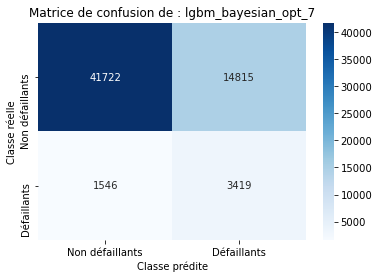

In [26]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_7')

In [29]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_7',
                                        1546, 14815, 3419, 41722, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score F10</span>

***
<span style='background:LightGreen'>**Modèle 7lgbm_bayesian_opt_8**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique F-mesure beta = 10 qui pénalise plus les faux négaifs que les faux positifs comme métrique d'évaluation lors de la recherche bayésienne.

In [33]:
# Définition de l'objective fonction
def lgbm_eval_8(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv, num_iteration=lgbm_clf.best_iteration_)

    return fbeta_score(y_train, cv_preds, 10)

In [34]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_8 = \
    BayesianOptimization(lgbm_eval_8,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_8 = lgbm_bayesian_opt_8.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6798   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.6689   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.6628   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.669    |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.6713   |  0.6062   |  7.244    |  31.84    |  38.34    |  0.08193  |  35.66    |  0.09261  |  0.1534   |  0.8499   |
|  6        |  0.6675   |  0.6227   |  8.424    |  19.81    | 

In [35]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_8.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 1.0, 'max_depth': 11.0, 'min_child_samples': 80.0, 'min_child_weight': 67.90507750074885, 'min_split_gain': 0.0, 'num_leaves': 25.0, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'subsample': 1.0}


In [37]:
param_lgbm_bayesian_opt_8 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 80,
                             'min_child_weight': 67.90507750074885,
                             'min_split_gain': 0.0,
                             'num_leaves': 25,
                             'reg_alpha': 0.001,
                             'reg_lambda': 0.001,
                             'subsample': 1.0,
                             'verbosity' : -1}

In [38]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_8 = LGBMClassifier(**param_lgbm_bayesian_opt_8,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_bayesian_opt_8,0.6939,0.1827,0.2892,0.6264,0.6752,0.7829,0.2772,0.7117,4.0609,4.1925,0.8229,0.0005,0.7861,0.0041,0.7570,0.0013,0.7032,0.0120,0.1986,0.0005,0.1843,0.0027


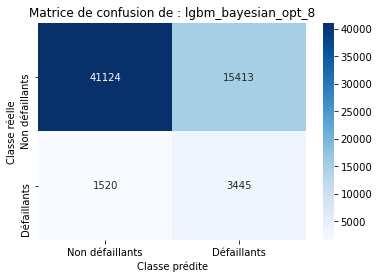

In [39]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_8')

In [40]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_bayesian_opt_8',
                                        1520, 15413, 3445, 41124, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie bayes_opt égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced'.
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne de scikit-learn : BayesSearchCV.

In [41]:
df_taux.sort_values(by='FN')

,Modèle,FN,FP,TN,TP
17,lgbm_bayesian_opt_8,1520,15413,3445,41124
6,lgbm_hyperparam_base_bal,1520,15164,3445,41373
5,lgbm_hyperparam_base_std_bal,1527,15162,3438,41375
13,lgbm_bayesian_opt_4,1533,14951,3432,41586
14,lgbm_bayesian_opt_5,1536,14772,3429,41765
16,lgbm_bayesian_opt_7,1546,14815,3419,41722
10,lgbm_bayesian_opt_1_bis,1554,15122,3411,41415
15,lgbm_bayesian_opt_6,1615,14359,3350,42178
12,lgbm_bayesian_opt_3,1809,11983,3156,44557
11,lgbm_bayesian_opt_2,4663,220,302,56317


### <span style='background:PowderBlue'>6.5. Optimisation LGBM : BayesSearchCV</span>

In [15]:
# Lancer la recherche avec BayesSearchCV
def lancer_optimise_baysearch(optimizer, X, y):
    optimizer.fit(X_train, y_train)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print(f'Best CV score : {best_score} +/- {best_score_std}')
    print('Best Hyperparamètres :\n')
    print(best_params)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : BayesSearchCV - ROC_AUC</span>

In [55]:
# Modèle lgbm
lgbm_baysearch_opt_1 = LGBMClassifier(objective='binary')

In [56]:
# Hyperparamètres à optimiser
params_search_spaces = {'num_leaves': Integer(25, 50),
                        'max_depth': Integer(6, 11),
                        'min_split_gain' : Real(0, 0.1),
                        'min_child_weight' : Integer(5,80),
                        'min_child_samples' : Integer(5,80),
                        'colsample_bytree' : Real(0.5,1),
                        'reg_alpha' : Real(0.001, 0.3),
                        'reg_lambda' : Real(0.001, 0.3),
                        'subsample': Real(0.5, 1.0)}

In [57]:
# Initialisation de BayesSearchCV
baysearch_opt_1 = BayesSearchCV(lgbm_baysearch_opt_1,
                                params_search_spaces,
                                scoring=roc_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [60]:
lancer_optimise_baysearch(baysearch_opt_1, X_train, y_train)

Best CV score : 0.7867424332751601 +/- 0.0022822753162983164
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.8386843496293603), ('max_depth', 10), ('min_child_samples', 80), ('min_child_weight', 80), ('min_split_gain', 0.0), ('num_leaves', 46), ('reg_alpha', 0.17214065713973717), ('reg_lambda', 0.26795300046605847), ('subsample', 0.9061161696734004)])


In [61]:
param_lgbm_baysearch_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.8386843496293603,
                             'max_depth': 10,
                             'min_child_samples': 80,
                             'min_child_weight': 80,
                             'min_split_gain': 0.0,
                             'num_leaves': 46,
                             'reg_alpha': 0.17214065713973717,
                             'reg_lambda': 0.26795300046605847,
                             'subsample': 0.9061161696734004,
                             'verbosity' : -1}

In [62]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_1 = LGBMClassifier(**param_lgbm_baysearch_opt_1,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_baysearch_opt_1,0.6792,0.1881,0.2946,0.6172,0.6620,0.7843,0.2782,0.7129,4.0055,4.1224,0.8488,0.0004,0.7871,0.0045,0.7837,0.0020,0.6899,0.0121,0.2162,0.0006,0.1908,0.0027


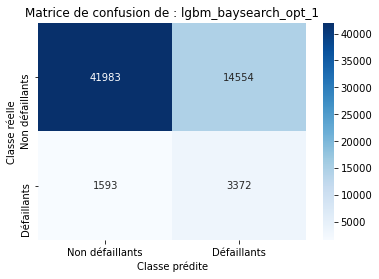

In [63]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_1')

In [64]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_baysearch_opt_1',
                                        1593, 14554, 3372, 41983, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : BayesSearchCV - Métrique métier</span>

In [23]:
# Modèle lgbm
lgbm_baysearch_opt_2 = LGBMClassifier(objective='binary')

In [24]:
# Hyperparamètres à optimiser
params_search_spaces_2 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [25]:
# Initialisation de BayesSearchCV
baysearch_opt_2 = BayesSearchCV(lgbm_baysearch_opt_2,
                                params_search_spaces_2,
                                scoring=custom_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [28]:
lancer_optimise_baysearch(baysearch_opt_2, X_train, y_train)

Best CV score : 0.5530377049759266 +/- 0.001106596372209594
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 10), ('min_child_samples', 80), ('min_child_weight', 39), ('min_split_gain', 0.1), ('num_leaves', 50), ('reg_alpha', 0.001), ('reg_lambda', 0.3), ('subsample', 1.0)])


In [38]:
param_lgbm_baysearch_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 10,
                             'min_child_samples': 80,
                             'min_child_weight': 39,
                             'min_split_gain': 0.1,
                             'num_leaves': 50,
                             'reg_alpha': 0.01,
                             'reg_lambda': 0.3,
                             'subsample': 1.0,
                             'verbosity' : -1}

In [39]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_2 = LGBMClassifier(**param_lgbm_baysearch_opt_2,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_baysearch_opt_2,0.6796,0.1898,0.2967,0.6182,0.6626,0.7850,0.2796,0.7145,4.6569,4.8334,0.8562,0.0005,0.7859,0.0039,0.7936,0.0016,0.6805,0.0101,0.2212,0.0006,0.1902,0.0020


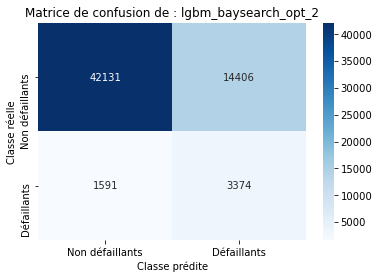

In [40]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_2')

In [42]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_baysearch_opt_2',
                                        1591, 14406, 3374, 42131, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : BayesSearchCV - Score PR_AUC</span>

In [29]:
# Modèle lgbm
lgbm_baysearch_opt_3 = LGBMClassifier(objective='binary')

In [30]:
# Hyperparamètres à optimiser
params_search_spaces_3 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [31]:
# Initialisation de BayesSearchCV
baysearch_opt_3 = BayesSearchCV(lgbm_baysearch_opt_3,
                                params_search_spaces_3,
                                scoring=pr_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [32]:
lancer_optimise_baysearch(baysearch_opt_3, X_train, y_train)

Best CV score : 0.2789053971282892 +/- 0.003426015092672019
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.9455778416073543), ('max_depth', 11), ('min_child_samples', 5), ('min_child_weight', 80), ('min_split_gain', 0.025703015427813326), ('num_leaves', 38), ('reg_alpha', 0.10993282225536499), ('reg_lambda', 0.09856024999291245), ('subsample', 0.7002783513002727)])


In [43]:
param_lgbm_baysearch_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.9455778416073543,
                             'max_depth': 11,
                             'min_child_samples': 5,
                             'min_child_weight': 80,
                             'min_split_gain': 0.025703015427813326,
                             'num_leaves': 38,
                             'reg_alpha': 0.10993282225536499,
                             'reg_lambda': 0.09856024999291245,
                             'subsample': 0.7002783513002727,
                             'verbosity' : -1}

In [44]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_3 = LGBMClassifier(**param_lgbm_baysearch_opt_3,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_baysearch_opt_3,0.6890,0.1878,0.2952,0.6249,0.6713,0.7852,0.2791,0.7153,4.0262,4.1549,0.8404,0.0004,0.7867,0.0045,0.7759,0.0012,0.6904,0.0095,0.2102,0.0005,0.1872,0.0024


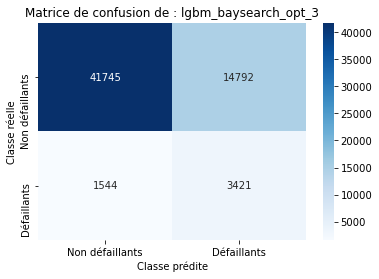

In [45]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_3')

In [47]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_baysearch_opt_3',
                                        1544, 14792, 3421, 41745, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : BayesSearchCV - Score F10 (F-mesure avec beta = 10)</span>

In [33]:
# Modèle lgbm
lgbm_baysearch_opt_4 = LGBMClassifier(objective='binary')

In [34]:
# Hyperparamètres à optimiser
params_search_spaces_4 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [35]:
# Initialisation de BayesSearchCV
baysearch_opt_4 = BayesSearchCV(lgbm_baysearch_opt_4,
                                params_search_spaces_4,
                                scoring=f10_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [36]:
lancer_optimise_baysearch(baysearch_opt_4, X_train, y_train)

Best CV score : 0.048879813213154516 +/- 0.001856810013032856
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 11), ('min_child_samples', 5), ('min_child_weight', 43), ('min_split_gain', 0.0), ('num_leaves', 50), ('reg_alpha', 0.3), ('reg_lambda', 0.001), ('subsample', 0.5)])


In [46]:
param_lgbm_baysearch_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 5,
                             'min_child_weight': 43,
                             'min_split_gain': 0.0,
                             'num_leaves': 50,
                             'reg_alpha': 0.3,
                             'reg_lambda': 0.001,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [48]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_4 = LGBMClassifier(**param_lgbm_baysearch_opt_4,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_baysearch_opt_4,0.6800,0.1892,0.2961,0.6183,0.6629,0.7849,0.2804,0.7141,4.5027,4.6570,0.8565,0.0005,0.7866,0.0039,0.7935,0.0013,0.6798,0.0095,0.2214,0.0005,0.1905,0.0021


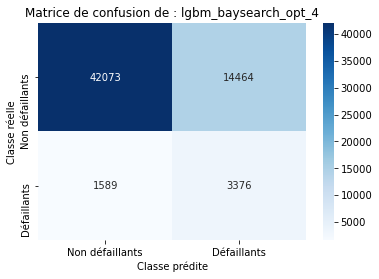

In [49]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_4')

In [50]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_baysearch_opt_4',
                                        1589, 14464, 3376, 42073, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie BayesSearchCV égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced' mais les résultats pour les différents scores sont légèrement plus faibles avec la librairie de sckit-learn skopt que celle du MIT bayes_opt. 
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne Optuna intégrée directement au modèle LightGBM.

In [51]:
mask = df_taux['FN']< 2000
df_taux[mask].sort_values(by='FN')

,Modèle,FN,FP,TN,TP
6,lgbm_hyperparam_base_bal,1520,15164,3445,41373
17,lgbm_bayesian_opt_8,1520,15413,3445,41124
5,lgbm_hyperparam_base_std_bal,1527,15162,3438,41375
13,lgbm_bayesian_opt_4,1533,14951,3432,41586
14,lgbm_bayesian_opt_5,1536,14772,3429,41765
21,lgbm_baysearch_opt_3,1544,14792,3421,41745
16,lgbm_bayesian_opt_7,1546,14815,3419,41722
10,lgbm_bayesian_opt_1_bis,1554,15122,3411,41415
18,lgbm_bayesian_opt_9,1567,14720,3398,41817
22,lgbm_baysearch_opt_4,1589,14464,3376,42073


### <span style='background:PowderBlue'>6.5. Optimisation : OPTUNA intégré à LGBM</span>

LightGBM Tuner est l'un des modules d'intégration d'Optuna permettant d'optimiser les hyperparamètres de LightGBM.

Les seules paramètres supportés :

`supported_param_names = [ 
     "lambda_l1", 
     "lambda_l2", 
     "num_leaves", 
     "feature_fraction", 
     "bagging_fraction", 
     "bagging_freq", 
     "min_child_samples", 
 ]` 

[Source](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html) [Source](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : Optuna intégrée à LightGBM - Score ROC_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [25]:
# Modèle et hyperparamètres à étudier
def create_model(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 10000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
#         n_estimators=n_estimators, 
        max_depth=max_depth, 
#         learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [26]:
# Objective fonction
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [27]:
# Recherche des p
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-08-04 15:01:55,291] A new study created in memory with name: no-name-3b43a9bb-15c7-4504-9752-a5f8f0e9f9f3


[LightGBM] [Warning] feature_fraction is set=0.5796569817347766, colsample_bytree=0.45652767495495405 will be ignored. Current value: feature_fraction=0.5796569817347766
[LightGBM] [Warning] lambda_l1 is set=2.699168238429461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.699168238429461
[LightGBM] [Warning] bagging_fraction is set=0.7394975439886737, subsample=0.16041749746181796 will be ignored. Current value: bagging_fraction=0.7394975439886737
[LightGBM] [Warning] lambda_l2 is set=6.022778038547081e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.022778038547081e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 15:01:57,747] Trial 0 finished with value: 0.7813208297265818 and parameters: {'max_depth': 5, 'subsample': 0.16041749746181796, 'colsample_bytree': 0.45652767495495405, 'lambda_l1': 2.699168238429461, 'lambda_l2': 6.022778038547081e-08, 'num_leaves': 31, 'feature_fraction': 0.5796569817347766, 'bagging_fraction': 0.7394975439886737, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 0 with value: 0.7813208297265818.


[LightGBM] [Warning] feature_fraction is set=0.8968948081871677, colsample_bytree=0.7954107830779666 will be ignored. Current value: feature_fraction=0.8968948081871677
[LightGBM] [Warning] lambda_l1 is set=2.3232854358003683e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3232854358003683e-08
[LightGBM] [Warning] bagging_fraction is set=0.7887050596370688, subsample=0.7172112739556415 will be ignored. Current value: bagging_fraction=0.7887050596370688
[LightGBM] [Warning] lambda_l2 is set=0.001351872128688746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001351872128688746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-04 15:02:01,289] Trial 1 finished with value: 0.7832567505944517 and parameters: {'max_depth': 9, 'subsample': 0.7172112739556415, 'colsample_bytree': 0.7954107830779666, 'lambda_l1': 2.3232854358003683e-08, 'lambda_l2': 0.001351872128688746, 'num_leaves': 36, 'feature_fraction': 0.8968948081871677, 'bagging_fraction': 0.7887050596370688, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.4681572160118293, colsample_bytree=0.368388973541281 will be ignored. Current value: feature_fraction=0.4681572160118293
[LightGBM] [Warning] lambda_l1 is set=1.0599855669852573e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0599855669852573e-08
[LightGBM] [Warning] bagging_fraction is set=0.7795064036485293, subsample=0.425444248210064 will be ignored. Current value: bagging_fraction=0.7795064036485293
[LightGBM] [Warning] lambda_l2 is set=4.335173217021461e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.335173217021461e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:02:05,029] Trial 2 finished with value: 0.7830033931740127 and parameters: {'max_depth': 10, 'subsample': 0.425444248210064, 'colsample_bytree': 0.368388973541281, 'lambda_l1': 1.0599855669852573e-08, 'lambda_l2': 4.335173217021461e-08, 'num_leaves': 55, 'feature_fraction': 0.4681572160118293, 'bagging_fraction': 0.7795064036485293, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.8691860716118416, colsample_bytree=0.5525792897292059 will be ignored. Current value: feature_fraction=0.8691860716118416
[LightGBM] [Warning] lambda_l1 is set=2.3137628122379685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3137628122379685
[LightGBM] [Warning] bagging_fraction is set=0.541210228295784, subsample=0.23213350260596108 will be ignored. Current value: bagging_fraction=0.541210228295784
[LightGBM] [Warning] lambda_l2 is set=2.266863517389548e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.266863517389548e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:02:08,376] Trial 3 finished with value: 0.7819710718542898 and parameters: {'max_depth': 7, 'subsample': 0.23213350260596108, 'colsample_bytree': 0.5525792897292059, 'lambda_l1': 2.3137628122379685, 'lambda_l2': 2.266863517389548e-07, 'num_leaves': 44, 'feature_fraction': 0.8691860716118416, 'bagging_fraction': 0.541210228295784, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.8828400948794556, colsample_bytree=0.9937641236061859 will be ignored. Current value: feature_fraction=0.8828400948794556
[LightGBM] [Warning] lambda_l1 is set=2.46205479612046e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.46205479612046e-05
[LightGBM] [Warning] bagging_fraction is set=0.6816880036775808, subsample=0.43796968767975386 will be ignored. Current value: bagging_fraction=0.6816880036775808
[LightGBM] [Warning] lambda_l2 is set=0.01884556279594009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01884556279594009
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:02:13,401] Trial 4 finished with value: 0.7795725320713875 and parameters: {'max_depth': 10, 'subsample': 0.43796968767975386, 'colsample_bytree': 0.9937641236061859, 'lambda_l1': 2.46205479612046e-05, 'lambda_l2': 0.01884556279594009, 'num_leaves': 123, 'feature_fraction': 0.8828400948794556, 'bagging_fraction': 0.6816880036775808, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.8386218963549779, colsample_bytree=0.7634606295459517 will be ignored. Current value: feature_fraction=0.8386218963549779
[LightGBM] [Warning] lambda_l1 is set=1.2820112341352458e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2820112341352458e-06
[LightGBM] [Warning] bagging_fraction is set=0.47871515220161603, subsample=0.9646954979349208 will be ignored. Current value: bagging_fraction=0.47871515220161603
[LightGBM] [Warning] lambda_l2 is set=6.250306811997081e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.250306811997081e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:02:17,935] Trial 5 finished with value: 0.769728396278237 and parameters: {'max_depth': 10, 'subsample': 0.9646954979349208, 'colsample_bytree': 0.7634606295459517, 'lambda_l1': 1.2820112341352458e-06, 'lambda_l2': 6.250306811997081e-07, 'num_leaves': 222, 'feature_fraction': 0.8386218963549779, 'bagging_fraction': 0.47871515220161603, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.8475132830441869, colsample_bytree=0.6640873714400192 will be ignored. Current value: feature_fraction=0.8475132830441869
[LightGBM] [Warning] lambda_l1 is set=0.005273110977609855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005273110977609855
[LightGBM] [Warning] bagging_fraction is set=0.4236667227591809, subsample=0.2493501881559893 will be ignored. Current value: bagging_fraction=0.4236667227591809
[LightGBM] [Warning] lambda_l2 is set=2.107777898405684e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.107777898405684e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-04 15:02:21,219] Trial 6 finished with value: 0.7773120761616225 and parameters: {'max_depth': 7, 'subsample': 0.2493501881559893, 'colsample_bytree': 0.6640873714400192, 'lambda_l1': 0.005273110977609855, 'lambda_l2': 2.107777898405684e-07, 'num_leaves': 8, 'feature_fraction': 0.8475132830441869, 'bagging_fraction': 0.4236667227591809, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.4174716773877313, colsample_bytree=0.8323797359041721 will be ignored. Current value: feature_fraction=0.4174716773877313
[LightGBM] [Warning] lambda_l1 is set=0.00029622104598673156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029622104598673156
[LightGBM] [Warning] bagging_fraction is set=0.6709098915103147, subsample=0.14019969538670748 will be ignored. Current value: bagging_fraction=0.6709098915103147
[LightGBM] [Warning] lambda_l2 is set=0.0006949519557503011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006949519557503011
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:02:24,187] Trial 7 finished with value: 0.778099689673764 and parameters: {'max_depth': 7, 'subsample': 0.14019969538670748, 'colsample_bytree': 0.8323797359041721, 'lambda_l1': 0.00029622104598673156, 'lambda_l2': 0.0006949519557503011, 'num_leaves': 201, 'feature_fraction': 0.4174716773877313, 'bagging_fraction': 0.6709098915103147, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.933520994745062, colsample_bytree=0.23910893491230434 will be ignored. Current value: feature_fraction=0.933520994745062
[LightGBM] [Warning] lambda_l1 is set=3.009324677705666e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.009324677705666e-08
[LightGBM] [Warning] bagging_fraction is set=0.9514236512651367, subsample=0.8317057124535694 will be ignored. Current value: bagging_fraction=0.9514236512651367
[LightGBM] [Warning] lambda_l2 is set=0.007767086889793556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007767086889793556
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:02:28,102] Trial 8 finished with value: 0.7822880010792779 and parameters: {'max_depth': 6, 'subsample': 0.8317057124535694, 'colsample_bytree': 0.23910893491230434, 'lambda_l1': 3.009324677705666e-08, 'lambda_l2': 0.007767086889793556, 'num_leaves': 33, 'feature_fraction': 0.933520994745062, 'bagging_fraction': 0.9514236512651367, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.6498577574482908, colsample_bytree=0.3150800589557017 will be ignored. Current value: feature_fraction=0.6498577574482908
[LightGBM] [Warning] lambda_l1 is set=1.7155341897518901e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7155341897518901e-06
[LightGBM] [Warning] bagging_fraction is set=0.5310403842277682, subsample=0.9968266119228416 will be ignored. Current value: bagging_fraction=0.5310403842277682
[LightGBM] [Warning] lambda_l2 is set=2.3037948765865176e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3037948765865176e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-04 15:02:30,105] Trial 9 finished with value: 0.773880018077976 and parameters: {'max_depth': 3, 'subsample': 0.9968266119228416, 'colsample_bytree': 0.3150800589557017, 'lambda_l1': 1.7155341897518901e-06, 'lambda_l2': 2.3037948765865176e-07, 'num_leaves': 82, 'feature_fraction': 0.6498577574482908, 'bagging_fraction': 0.5310403842277682, 'bagging_freq': 1, 'min_child_samples': 80}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.7414574796448852, colsample_bytree=0.9365802925746997 will be ignored. Current value: feature_fraction=0.7414574796448852
[LightGBM] [Warning] lambda_l1 is set=0.09552023453368874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09552023453368874
[LightGBM] [Warning] bagging_fraction is set=0.9633976526638586, subsample=0.7107353629935433 will be ignored. Current value: bagging_fraction=0.9633976526638586
[LightGBM] [Warning] lambda_l2 is set=7.6973387192529295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.6973387192529295
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:02:36,613] Trial 10 finished with value: 0.7823133478648968 and parameters: {'max_depth': 11, 'subsample': 0.7107353629935433, 'colsample_bytree': 0.9365802925746997, 'lambda_l1': 0.09552023453368874, 'lambda_l2': 7.6973387192529295, 'num_leaves': 160, 'feature_fraction': 0.7414574796448852, 'bagging_fraction': 0.9633976526638586, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.41992617767380663, colsample_bytree=0.4640010710452966 will be ignored. Current value: feature_fraction=0.41992617767380663
[LightGBM] [Warning] lambda_l1 is set=1.112116514906929e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.112116514906929e-08
[LightGBM] [Warning] bagging_fraction is set=0.8262820987502187, subsample=0.5229392893831459 will be ignored. Current value: bagging_fraction=0.8262820987502187
[LightGBM] [Warning] lambda_l2 is set=3.380546908273373e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.380546908273373e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:02:40,707] Trial 11 finished with value: 0.7806016293797283 and parameters: {'max_depth': 9, 'subsample': 0.5229392893831459, 'colsample_bytree': 0.4640010710452966, 'lambda_l1': 1.112116514906929e-08, 'lambda_l2': 3.380546908273373e-05, 'num_leaves': 85, 'feature_fraction': 0.41992617767380663, 'bagging_fraction': 0.8262820987502187, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.5230846166304765, colsample_bytree=0.11946464965264442 will be ignored. Current value: feature_fraction=0.5230846166304765
[LightGBM] [Warning] lambda_l1 is set=9.016573850071899e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.016573850071899e-08
[LightGBM] [Warning] bagging_fraction is set=0.8338280708656166, subsample=0.6782034007185925 will be ignored. Current value: bagging_fraction=0.8338280708656166
[LightGBM] [Warning] lambda_l2 is set=0.9472167491353911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9472167491353911
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:02:44,941] Trial 12 finished with value: 0.7808904723000334 and parameters: {'max_depth': 9, 'subsample': 0.6782034007185925, 'colsample_bytree': 0.11946464965264442, 'lambda_l1': 9.016573850071899e-08, 'lambda_l2': 0.9472167491353911, 'num_leaves': 81, 'feature_fraction': 0.5230846166304765, 'bagging_fraction': 0.8338280708656166, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.9781256756910903, colsample_bytree=0.30545151751561284 will be ignored. Current value: feature_fraction=0.9781256756910903
[LightGBM] [Warning] lambda_l1 is set=4.1292787402156207e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1292787402156207e-07
[LightGBM] [Warning] bagging_fraction is set=0.8321006651079732, subsample=0.46956622542966453 will be ignored. Current value: bagging_fraction=0.8321006651079732
[LightGBM] [Warning] lambda_l2 is set=1.780405523617469e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.780405523617469e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-04 15:02:47,353] Trial 13 finished with value: 0.7725403576312108 and parameters: {'max_depth': 11, 'subsample': 0.46956622542966453, 'colsample_bytree': 0.30545151751561284, 'lambda_l1': 4.1292787402156207e-07, 'lambda_l2': 1.780405523617469e-05, 'num_leaves': 5, 'feature_fraction': 0.9781256756910903, 'bagging_fraction': 0.8321006651079732, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.7445078996603169, colsample_bytree=0.6388248423997156 will be ignored. Current value: feature_fraction=0.7445078996603169
[LightGBM] [Warning] lambda_l1 is set=1.1052405215141813e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1052405215141813e-08
[LightGBM] [Warning] bagging_fraction is set=0.7599668802822739, subsample=0.3401595898886618 will be ignored. Current value: bagging_fraction=0.7599668802822739
[LightGBM] [Warning] lambda_l2 is set=0.12897731807547308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12897731807547308
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:02:52,318] Trial 14 finished with value: 0.7797291834001318 and parameters: {'max_depth': 9, 'subsample': 0.3401595898886618, 'colsample_bytree': 0.6388248423997156, 'lambda_l1': 1.1052405215141813e-08, 'lambda_l2': 0.12897731807547308, 'num_leaves': 120, 'feature_fraction': 0.7445078996603169, 'bagging_fraction': 0.7599668802822739, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 1 with value: 0.7832567505944517.


[LightGBM] [Warning] feature_fraction is set=0.4817412648678469, colsample_bytree=0.44174091028971385 will be ignored. Current value: feature_fraction=0.4817412648678469
[LightGBM] [Warning] lambda_l1 is set=2.0055567028142874e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0055567028142874e-05
[LightGBM] [Warning] bagging_fraction is set=0.899836247768713, subsample=0.6401593652931346 will be ignored. Current value: bagging_fraction=0.899836247768713
[LightGBM] [Warning] lambda_l2 is set=0.00038681141642280334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038681141642280334
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:02:56,014] Trial 15 finished with value: 0.7834681388678245 and parameters: {'max_depth': 8, 'subsample': 0.6401593652931346, 'colsample_bytree': 0.44174091028971385, 'lambda_l1': 2.0055567028142874e-05, 'lambda_l2': 0.00038681141642280334, 'num_leaves': 59, 'feature_fraction': 0.4817412648678469, 'bagging_fraction': 0.899836247768713, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.622472839486447, colsample_bytree=0.8199627540734749 will be ignored. Current value: feature_fraction=0.622472839486447
[LightGBM] [Warning] lambda_l1 is set=3.2562641649083e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2562641649083e-05
[LightGBM] [Warning] bagging_fraction is set=0.9128763817413841, subsample=0.652485546201105 will be ignored. Current value: bagging_fraction=0.9128763817413841
[LightGBM] [Warning] lambda_l2 is set=0.00034393403607776166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034393403607776166
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:03:00,133] Trial 16 finished with value: 0.7830809796313553 and parameters: {'max_depth': 8, 'subsample': 0.652485546201105, 'colsample_bytree': 0.8199627540734749, 'lambda_l1': 3.2562641649083e-05, 'lambda_l2': 0.00034393403607776166, 'num_leaves': 73, 'feature_fraction': 0.622472839486447, 'bagging_fraction': 0.9128763817413841, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.7836570055289483, colsample_bytree=0.6753646682549297 will be ignored. Current value: feature_fraction=0.7836570055289483
[LightGBM] [Warning] lambda_l1 is set=0.0077791536232943576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0077791536232943576
[LightGBM] [Warning] bagging_fraction is set=0.8919339719500174, subsample=0.822443507534856 will be ignored. Current value: bagging_fraction=0.8919339719500174
[LightGBM] [Warning] lambda_l2 is set=2.9332030254382956e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9332030254382956e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:03:02,842] Trial 17 finished with value: 0.7765147229289071 and parameters: {'max_depth': 5, 'subsample': 0.822443507534856, 'colsample_bytree': 0.6753646682549297, 'lambda_l1': 0.0077791536232943576, 'lambda_l2': 2.9332030254382956e-05, 'num_leaves': 8, 'feature_fraction': 0.7836570055289483, 'bagging_fraction': 0.8919339719500174, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.9883230190011546, colsample_bytree=0.5446266746281522 will be ignored. Current value: feature_fraction=0.9883230190011546
[LightGBM] [Warning] lambda_l1 is set=1.3667735699252173e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3667735699252173e-05
[LightGBM] [Warning] bagging_fraction is set=0.6229528470876791, subsample=0.8419819841898039 will be ignored. Current value: bagging_fraction=0.6229528470876791
[LightGBM] [Warning] lambda_l2 is set=0.002454772176033871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002454772176033871
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:03:07,682] Trial 18 finished with value: 0.7729477800464012 and parameters: {'max_depth': 8, 'subsample': 0.8419819841898039, 'colsample_bytree': 0.5446266746281522, 'lambda_l1': 1.3667735699252173e-05, 'lambda_l2': 0.002454772176033871, 'num_leaves': 154, 'feature_fraction': 0.9883230190011546, 'bagging_fraction': 0.6229528470876791, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.5372971943134706, colsample_bytree=0.11751840454841739 will be ignored. Current value: feature_fraction=0.5372971943134706
[LightGBM] [Warning] lambda_l1 is set=0.0016152386602722385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016152386602722385
[LightGBM] [Warning] bagging_fraction is set=0.9956205180949812, subsample=0.5631575554727795 will be ignored. Current value: bagging_fraction=0.9956205180949812
[LightGBM] [Warning] lambda_l2 is set=3.40598860555699e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.40598860555699e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:03:11,905] Trial 19 finished with value: 0.7813393045586576 and parameters: {'max_depth': 8, 'subsample': 0.5631575554727795, 'colsample_bytree': 0.11751840454841739, 'lambda_l1': 0.0016152386602722385, 'lambda_l2': 3.40598860555699e-06, 'num_leaves': 104, 'feature_fraction': 0.5372971943134706, 'bagging_fraction': 0.9956205180949812, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.7000718608971781, colsample_bytree=0.9290792412712101 will be ignored. Current value: feature_fraction=0.7000718608971781
[LightGBM] [Warning] lambda_l1 is set=0.11334958030618233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11334958030618233
[LightGBM] [Warning] bagging_fraction is set=0.895801824131777, subsample=0.7518447259034753 will be ignored. Current value: bagging_fraction=0.895801824131777
[LightGBM] [Warning] lambda_l2 is set=0.2141630169636399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2141630169636399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-04 15:03:15,307] Trial 20 finished with value: 0.7805808532091408 and parameters: {'max_depth': 6, 'subsample': 0.7518447259034753, 'colsample_bytree': 0.9290792412712101, 'lambda_l1': 0.11334958030618233, 'lambda_l2': 0.2141630169636399, 'num_leaves': 57, 'feature_fraction': 0.7000718608971781, 'bagging_fraction': 0.895801824131777, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.6325990087278449, colsample_bytree=0.8154275907414735 will be ignored. Current value: feature_fraction=0.6325990087278449
[LightGBM] [Warning] lambda_l1 is set=8.409736483533237e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.409736483533237e-05
[LightGBM] [Warning] bagging_fraction is set=0.9042585734675961, subsample=0.6284182620425066 will be ignored. Current value: bagging_fraction=0.9042585734675961
[LightGBM] [Warning] lambda_l2 is set=0.00021056404093012723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021056404093012723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:03:19,339] Trial 21 finished with value: 0.7826146593375091 and parameters: {'max_depth': 8, 'subsample': 0.6284182620425066, 'colsample_bytree': 0.8154275907414735, 'lambda_l1': 8.409736483533237e-05, 'lambda_l2': 0.00021056404093012723, 'num_leaves': 65, 'feature_fraction': 0.6325990087278449, 'bagging_fraction': 0.9042585734675961, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 15 with value: 0.7834681388678245.


[LightGBM] [Warning] feature_fraction is set=0.6055500792030603, colsample_bytree=0.7529353998602427 will be ignored. Current value: feature_fraction=0.6055500792030603
[LightGBM] [Warning] lambda_l1 is set=6.7697524433073285e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7697524433073285e-06
[LightGBM] [Warning] bagging_fraction is set=0.8674295821938359, subsample=0.6100919088558718 will be ignored. Current value: bagging_fraction=0.8674295821938359
[LightGBM] [Warning] lambda_l2 is set=0.00022095239004399193, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022095239004399193
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:03:22,841] Trial 22 finished with value: 0.7838436845384306 and parameters: {'max_depth': 8, 'subsample': 0.6100919088558718, 'colsample_bytree': 0.7529353998602427, 'lambda_l1': 6.7697524433073285e-06, 'lambda_l2': 0.00022095239004399193, 'num_leaves': 30, 'feature_fraction': 0.6055500792030603, 'bagging_fraction': 0.8674295821938359, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.4838502694992656, colsample_bytree=0.7361675122869453 will be ignored. Current value: feature_fraction=0.4838502694992656
[LightGBM] [Warning] lambda_l1 is set=3.3401245433463257e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3401245433463257e-06
[LightGBM] [Warning] bagging_fraction is set=0.8217760657355936, subsample=0.5791050551903514 will be ignored. Current value: bagging_fraction=0.8217760657355936
[LightGBM] [Warning] lambda_l2 is set=0.002828394760804001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002828394760804001
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:03:26,212] Trial 23 finished with value: 0.7822808904420192 and parameters: {'max_depth': 9, 'subsample': 0.5791050551903514, 'colsample_bytree': 0.7361675122869453, 'lambda_l1': 3.3401245433463257e-06, 'lambda_l2': 0.002828394760804001, 'num_leaves': 27, 'feature_fraction': 0.4838502694992656, 'bagging_fraction': 0.8217760657355936, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.5688966182118567, colsample_bytree=0.5392337897898873 will be ignored. Current value: feature_fraction=0.5688966182118567
[LightGBM] [Warning] lambda_l1 is set=4.086226681837005e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.086226681837005e-07
[LightGBM] [Warning] bagging_fraction is set=0.9956893874290217, subsample=0.7853644375243815 will be ignored. Current value: bagging_fraction=0.9956893874290217
[LightGBM] [Warning] lambda_l2 is set=0.0001389455872142954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001389455872142954
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:03:29,252] Trial 24 finished with value: 0.7796335852283707 and parameters: {'max_depth': 6, 'subsample': 0.7853644375243815, 'colsample_bytree': 0.5392337897898873, 'lambda_l1': 4.086226681837005e-07, 'lambda_l2': 0.0001389455872142954, 'num_leaves': 13, 'feature_fraction': 0.5688966182118567, 'bagging_fraction': 0.9956893874290217, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.47939847903707083, colsample_bytree=0.899187427431325 will be ignored. Current value: feature_fraction=0.47939847903707083
[LightGBM] [Warning] lambda_l1 is set=0.00028195412545848014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028195412545848014
[LightGBM] [Warning] bagging_fraction is set=0.8650908361663142, subsample=0.9187627309067061 will be ignored. Current value: bagging_fraction=0.8650908361663142
[LightGBM] [Warning] lambda_l2 is set=6.901451093996952e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.901451093996952e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:03:33,107] Trial 25 finished with value: 0.7816822716833067 and parameters: {'max_depth': 8, 'subsample': 0.9187627309067061, 'colsample_bytree': 0.899187427431325, 'lambda_l1': 0.00028195412545848014, 'lambda_l2': 6.901451093996952e-06, 'num_leaves': 102, 'feature_fraction': 0.47939847903707083, 'bagging_fraction': 0.8650908361663142, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.6667441806406217, colsample_bytree=0.7175190729120816 will be ignored. Current value: feature_fraction=0.6667441806406217
[LightGBM] [Warning] lambda_l1 is set=1.3232080996954264e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232080996954264e-07
[LightGBM] [Warning] bagging_fraction is set=0.7779785473703604, subsample=0.6168068841248611 will be ignored. Current value: bagging_fraction=0.7779785473703604
[LightGBM] [Warning] lambda_l2 is set=0.020032578552498657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020032578552498657
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:03:36,652] Trial 26 finished with value: 0.7833257693751373 and parameters: {'max_depth': 10, 'subsample': 0.6168068841248611, 'colsample_bytree': 0.7175190729120816, 'lambda_l1': 1.3232080996954264e-07, 'lambda_l2': 0.020032578552498657, 'num_leaves': 39, 'feature_fraction': 0.6667441806406217, 'bagging_fraction': 0.7779785473703604, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.675560090577952, colsample_bytree=0.6141700647880867 will be ignored. Current value: feature_fraction=0.675560090577952
[LightGBM] [Warning] lambda_l1 is set=6.91413944384266e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.91413944384266e-06
[LightGBM] [Warning] bagging_fraction is set=0.7205854027431051, subsample=0.6094735177129574 will be ignored. Current value: bagging_fraction=0.7205854027431051
[LightGBM] [Warning] lambda_l2 is set=0.03453720747293334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03453720747293334
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:03:40,500] Trial 27 finished with value: 0.7827136596428284 and parameters: {'max_depth': 11, 'subsample': 0.6094735177129574, 'colsample_bytree': 0.6141700647880867, 'lambda_l1': 6.91413944384266e-06, 'lambda_l2': 0.03453720747293334, 'num_leaves': 51, 'feature_fraction': 0.675560090577952, 'bagging_fraction': 0.7205854027431051, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.5805772961247183, colsample_bytree=0.7054745878602151 will be ignored. Current value: feature_fraction=0.5805772961247183
[LightGBM] [Warning] lambda_l1 is set=1.9766132276285483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9766132276285483e-07
[LightGBM] [Warning] bagging_fraction is set=0.950583202992676, subsample=0.5083870339807107 will be ignored. Current value: bagging_fraction=0.950583202992676
[LightGBM] [Warning] lambda_l2 is set=0.00011315613845412944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011315613845412944
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:03:44,074] Trial 28 finished with value: 0.7813351258124129 and parameters: {'max_depth': 10, 'subsample': 0.5083870339807107, 'colsample_bytree': 0.7054745878602151, 'lambda_l1': 1.9766132276285483e-07, 'lambda_l2': 0.00011315613845412944, 'num_leaves': 19, 'feature_fraction': 0.5805772961247183, 'bagging_fraction': 0.950583202992676, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.578063825197516, colsample_bytree=0.4410257512092512 will be ignored. Current value: feature_fraction=0.578063825197516
[LightGBM] [Warning] lambda_l1 is set=9.555741458975808e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.555741458975808e-05
[LightGBM] [Warning] bagging_fraction is set=0.6419905365951583, subsample=0.3626677913334014 will be ignored. Current value: bagging_fraction=0.6419905365951583
[LightGBM] [Warning] lambda_l2 is set=1.8908893603038759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8908893603038759
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:03:46,759] Trial 29 finished with value: 0.778556640741162 and parameters: {'max_depth': 5, 'subsample': 0.3626677913334014, 'colsample_bytree': 0.4410257512092512, 'lambda_l1': 9.555741458975808e-05, 'lambda_l2': 1.8908893603038759, 'num_leaves': 102, 'feature_fraction': 0.578063825197516, 'bagging_fraction': 0.6419905365951583, 'bagging_freq': 7, 'min_child_samples': 26}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.607487961909912, colsample_bytree=0.6081768091053551 will be ignored. Current value: feature_fraction=0.607487961909912
[LightGBM] [Warning] lambda_l1 is set=1.8733812557610928e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8733812557610928e-06
[LightGBM] [Warning] bagging_fraction is set=0.7342195537163785, subsample=0.6597480347442299 will be ignored. Current value: bagging_fraction=0.7342195537163785
[LightGBM] [Warning] lambda_l2 is set=0.007972390650894707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007972390650894707
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:03:49,427] Trial 30 finished with value: 0.7776261340571363 and parameters: {'max_depth': 4, 'subsample': 0.6597480347442299, 'colsample_bytree': 0.6081768091053551, 'lambda_l1': 1.8733812557610928e-06, 'lambda_l2': 0.007972390650894707, 'num_leaves': 155, 'feature_fraction': 0.607487961909912, 'bagging_fraction': 0.7342195537163785, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.6830595493647682, colsample_bytree=0.7845750258757017 will be ignored. Current value: feature_fraction=0.6830595493647682
[LightGBM] [Warning] lambda_l1 is set=7.291888771548166e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.291888771548166e-08
[LightGBM] [Warning] bagging_fraction is set=0.76539024503948, subsample=0.7573601708123381 will be ignored. Current value: bagging_fraction=0.76539024503948
[LightGBM] [Warning] lambda_l2 is set=0.0013361788602058488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013361788602058488
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:03:52,789] Trial 31 finished with value: 0.7831354137682849 and parameters: {'max_depth': 9, 'subsample': 0.7573601708123381, 'colsample_bytree': 0.7845750258757017, 'lambda_l1': 7.291888771548166e-08, 'lambda_l2': 0.0013361788602058488, 'num_leaves': 33, 'feature_fraction': 0.6830595493647682, 'bagging_fraction': 0.76539024503948, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.7290567932486662, colsample_bytree=0.8624523297937338 will be ignored. Current value: feature_fraction=0.7290567932486662
[LightGBM] [Warning] lambda_l1 is set=5.577480780921403e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.577480780921403e-07
[LightGBM] [Warning] bagging_fraction is set=0.8006853721233638, subsample=0.7019787650309527 will be ignored. Current value: bagging_fraction=0.8006853721233638
[LightGBM] [Warning] lambda_l2 is set=0.06729037165531461, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06729037165531461
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:03:56,435] Trial 32 finished with value: 0.782315047150454 and parameters: {'max_depth': 10, 'subsample': 0.7019787650309527, 'colsample_bytree': 0.8624523297937338, 'lambda_l1': 5.577480780921403e-07, 'lambda_l2': 0.06729037165531461, 'num_leaves': 38, 'feature_fraction': 0.7290567932486662, 'bagging_fraction': 0.8006853721233638, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 22 with value: 0.7838436845384306.


[LightGBM] [Warning] feature_fraction is set=0.7994192821719871, colsample_bytree=0.9971223173706572 will be ignored. Current value: feature_fraction=0.7994192821719871
[LightGBM] [Warning] lambda_l1 is set=6.1399455630235e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1399455630235e-08
[LightGBM] [Warning] bagging_fraction is set=0.7822921913696409, subsample=0.5768717612830281 will be ignored. Current value: bagging_fraction=0.7822921913696409
[LightGBM] [Warning] lambda_l2 is set=0.0005180928826505886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005180928826505886
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:04:00,330] Trial 33 finished with value: 0.7839678926940714 and parameters: {'max_depth': 9, 'subsample': 0.5768717612830281, 'colsample_bytree': 0.9971223173706572, 'lambda_l1': 6.1399455630235e-08, 'lambda_l2': 0.0005180928826505886, 'num_leaves': 49, 'feature_fraction': 0.7994192821719871, 'bagging_fraction': 0.7822921913696409, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.7870176466027604, colsample_bytree=0.5020115910848069 will be ignored. Current value: feature_fraction=0.7870176466027604
[LightGBM] [Warning] lambda_l1 is set=6.53817708753762e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.53817708753762e-08
[LightGBM] [Warning] bagging_fraction is set=0.864224074721909, subsample=0.577937436071977 will be ignored. Current value: bagging_fraction=0.864224074721909
[LightGBM] [Warning] lambda_l2 is set=0.000570011898590777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000570011898590777
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:04:04,246] Trial 34 finished with value: 0.7830453551961917 and parameters: {'max_depth': 8, 'subsample': 0.577937436071977, 'colsample_bytree': 0.5020115910848069, 'lambda_l1': 6.53817708753762e-08, 'lambda_l2': 0.000570011898590777, 'num_leaves': 47, 'feature_fraction': 0.7870176466027604, 'bagging_fraction': 0.864224074721909, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.7945344890057388, colsample_bytree=0.37291106206458635 will be ignored. Current value: feature_fraction=0.7945344890057388
[LightGBM] [Warning] lambda_l1 is set=7.640147751855458e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.640147751855458e-06
[LightGBM] [Warning] bagging_fraction is set=0.7840060029080621, subsample=0.48670679857211124 will be ignored. Current value: bagging_fraction=0.7840060029080621
[LightGBM] [Warning] lambda_l2 is set=0.007404509848008235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007404509848008235
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:04:07,985] Trial 35 finished with value: 0.7801613541104302 and parameters: {'max_depth': 7, 'subsample': 0.48670679857211124, 'colsample_bytree': 0.37291106206458635, 'lambda_l1': 7.640147751855458e-06, 'lambda_l2': 0.007404509848008235, 'num_leaves': 67, 'feature_fraction': 0.7945344890057388, 'bagging_fraction': 0.7840060029080621, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5249662361439087, colsample_bytree=0.9900355085616525 will be ignored. Current value: feature_fraction=0.5249662361439087
[LightGBM] [Warning] lambda_l1 is set=7.154987882190212e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.154987882190212e-05
[LightGBM] [Warning] bagging_fraction is set=0.8649391187538243, subsample=0.38759869430411853 will be ignored. Current value: bagging_fraction=0.8649391187538243
[LightGBM] [Warning] lambda_l2 is set=0.00010818946410957989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010818946410957989
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:04:11,254] Trial 36 finished with value: 0.7821777648271081 and parameters: {'max_depth': 10, 'subsample': 0.38759869430411853, 'colsample_bytree': 0.9900355085616525, 'lambda_l1': 7.154987882190212e-05, 'lambda_l2': 0.00010818946410957989, 'num_leaves': 23, 'feature_fraction': 0.5249662361439087, 'bagging_fraction': 0.8649391187538243, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8240910081450247, colsample_bytree=0.4329023202629986 will be ignored. Current value: feature_fraction=0.8240910081450247
[LightGBM] [Warning] lambda_l1 is set=8.933436329680573e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.933436329680573e-07
[LightGBM] [Warning] bagging_fraction is set=0.9349824147508954, subsample=0.6127615717240539 will be ignored. Current value: bagging_fraction=0.9349824147508954
[LightGBM] [Warning] lambda_l2 is set=6.446015252221573e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.446015252221573e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:04:15,794] Trial 37 finished with value: 0.7832366548505758 and parameters: {'max_depth': 10, 'subsample': 0.6127615717240539, 'colsample_bytree': 0.4329023202629986, 'lambda_l1': 8.933436329680573e-07, 'lambda_l2': 6.446015252221573e-06, 'num_leaves': 51, 'feature_fraction': 0.8240910081450247, 'bagging_fraction': 0.9349824147508954, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9147821504845689, colsample_bytree=0.5773341259174517 will be ignored. Current value: feature_fraction=0.9147821504845689
[LightGBM] [Warning] lambda_l1 is set=4.610843204616149e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610843204616149e-06
[LightGBM] [Warning] bagging_fraction is set=0.7050201699438721, subsample=0.5386826318190329 will be ignored. Current value: bagging_fraction=0.7050201699438721
[LightGBM] [Warning] lambda_l2 is set=0.019257539726777524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019257539726777524
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:04:17,853] Trial 38 finished with value: 0.7522352970430418 and parameters: {'max_depth': 7, 'subsample': 0.5386826318190329, 'colsample_bytree': 0.5773341259174517, 'lambda_l1': 4.610843204616149e-06, 'lambda_l2': 0.019257539726777524, 'num_leaves': 2, 'feature_fraction': 0.9147821504845689, 'bagging_fraction': 0.7050201699438721, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.43809198762281976, colsample_bytree=0.7249805677604473 will be ignored. Current value: feature_fraction=0.43809198762281976
[LightGBM] [Warning] lambda_l1 is set=2.9249996848785537e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9249996848785537e-08
[LightGBM] [Warning] bagging_fraction is set=0.7436791535503415, subsample=0.4273808028371565 will be ignored. Current value: bagging_fraction=0.7436791535503415
[LightGBM] [Warning] lambda_l2 is set=0.001281279036437242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001281279036437242
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:04:22,360] Trial 39 finished with value: 0.7712806348545093 and parameters: {'max_depth': 9, 'subsample': 0.4273808028371565, 'colsample_bytree': 0.7249805677604473, 'lambda_l1': 2.9249996848785537e-08, 'lambda_l2': 0.001281279036437242, 'num_leaves': 256, 'feature_fraction': 0.43809198762281976, 'bagging_fraction': 0.7436791535503415, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6697248951776429, colsample_bytree=0.38731807346727126 will be ignored. Current value: feature_fraction=0.6697248951776429
[LightGBM] [Warning] lambda_l1 is set=1.9098961748778569e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9098961748778569e-07
[LightGBM] [Warning] bagging_fraction is set=0.6787911473211227, subsample=0.8944830294286796 will be ignored. Current value: bagging_fraction=0.6787911473211227
[LightGBM] [Warning] lambda_l2 is set=1.6439849844429855e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6439849844429855e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:04:25,662] Trial 40 finished with value: 0.7819116716710982 and parameters: {'max_depth': 9, 'subsample': 0.8944830294286796, 'colsample_bytree': 0.38731807346727126, 'lambda_l1': 1.9098961748778569e-07, 'lambda_l2': 1.6439849844429855e-06, 'num_leaves': 39, 'feature_fraction': 0.6697248951776429, 'bagging_fraction': 0.6787911473211227, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9047065820369564, colsample_bytree=0.7750451793532657 will be ignored. Current value: feature_fraction=0.9047065820369564
[LightGBM] [Warning] lambda_l1 is set=3.790060636543671e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.790060636543671e-08
[LightGBM] [Warning] bagging_fraction is set=0.7924868589876556, subsample=0.7138367819570774 will be ignored. Current value: bagging_fraction=0.7924868589876556
[LightGBM] [Warning] lambda_l2 is set=0.003440322670412075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003440322670412075
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:04:30,051] Trial 41 finished with value: 0.7824333095878662 and parameters: {'max_depth': 8, 'subsample': 0.7138367819570774, 'colsample_bytree': 0.7750451793532657, 'lambda_l1': 3.790060636543671e-08, 'lambda_l2': 0.003440322670412075, 'num_leaves': 25, 'feature_fraction': 0.9047065820369564, 'bagging_fraction': 0.7924868589876556, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8641438150728434, colsample_bytree=0.9500559291414948 will be ignored. Current value: feature_fraction=0.8641438150728434
[LightGBM] [Warning] lambda_l1 is set=1.7227279959969028e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7227279959969028e-07
[LightGBM] [Warning] bagging_fraction is set=0.8521176747531812, subsample=0.6159007444180736 will be ignored. Current value: bagging_fraction=0.8521176747531812
[LightGBM] [Warning] lambda_l2 is set=1.0047957633433747e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0047957633433747e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:04:34,386] Trial 42 finished with value: 0.7833558791477374 and parameters: {'max_depth': 9, 'subsample': 0.6159007444180736, 'colsample_bytree': 0.9500559291414948, 'lambda_l1': 1.7227279959969028e-07, 'lambda_l2': 1.0047957633433747e-08, 'num_leaves': 60, 'feature_fraction': 0.8641438150728434, 'bagging_fraction': 0.8521176747531812, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8647392998802724, colsample_bytree=0.9943685809052604 will be ignored. Current value: feature_fraction=0.8647392998802724
[LightGBM] [Warning] lambda_l1 is set=1.8750614550067144e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8750614550067144e-07
[LightGBM] [Warning] bagging_fraction is set=0.8679020259624851, subsample=0.6227570756757653 will be ignored. Current value: bagging_fraction=0.8679020259624851
[LightGBM] [Warning] lambda_l2 is set=2.97578002279117e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.97578002279117e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:04:38,944] Trial 43 finished with value: 0.7834056108592254 and parameters: {'max_depth': 10, 'subsample': 0.6227570756757653, 'colsample_bytree': 0.9943685809052604, 'lambda_l1': 1.8750614550067144e-07, 'lambda_l2': 2.97578002279117e-08, 'num_leaves': 61, 'feature_fraction': 0.8647392998802724, 'bagging_fraction': 0.8679020259624851, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8708631653276258, colsample_bytree=0.9996455205140605 will be ignored. Current value: feature_fraction=0.8708631653276258
[LightGBM] [Warning] lambda_l1 is set=2.2198192541070635e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2198192541070635e-05
[LightGBM] [Warning] bagging_fraction is set=0.8579542593025998, subsample=0.5485115484931031 will be ignored. Current value: bagging_fraction=0.8579542593025998
[LightGBM] [Warning] lambda_l2 is set=3.507261509414843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.507261509414843e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:04:43,439] Trial 44 finished with value: 0.7800555780375429 and parameters: {'max_depth': 8, 'subsample': 0.5485115484931031, 'colsample_bytree': 0.9996455205140605, 'lambda_l1': 2.2198192541070635e-05, 'lambda_l2': 3.507261509414843e-08, 'num_leaves': 91, 'feature_fraction': 0.8708631653276258, 'bagging_fraction': 0.8579542593025998, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8345064887177895, colsample_bytree=0.9724654033910268 will be ignored. Current value: feature_fraction=0.8345064887177895
[LightGBM] [Warning] lambda_l1 is set=3.248362931880591e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.248362931880591e-07
[LightGBM] [Warning] bagging_fraction is set=0.9279238180988063, subsample=0.6737603688948584 will be ignored. Current value: bagging_fraction=0.9279238180988063
[LightGBM] [Warning] lambda_l2 is set=1.878849305480818e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.878849305480818e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:04:48,557] Trial 45 finished with value: 0.7828854406691865 and parameters: {'max_depth': 9, 'subsample': 0.6737603688948584, 'colsample_bytree': 0.9724654033910268, 'lambda_l1': 3.248362931880591e-07, 'lambda_l2': 1.878849305480818e-08, 'num_leaves': 60, 'feature_fraction': 0.8345064887177895, 'bagging_fraction': 0.9279238180988063, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9521900187385257, colsample_bytree=0.8784573981600811 will be ignored. Current value: feature_fraction=0.9521900187385257
[LightGBM] [Warning] lambda_l1 is set=1.6776274035157503e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6776274035157503e-06
[LightGBM] [Warning] bagging_fraction is set=0.9813056924325392, subsample=0.46079748258183606 will be ignored. Current value: bagging_fraction=0.9813056924325392
[LightGBM] [Warning] lambda_l2 is set=1.0932911722986187e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0932911722986187e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:04:54,641] Trial 46 finished with value: 0.7836419469245435 and parameters: {'max_depth': 11, 'subsample': 0.46079748258183606, 'colsample_bytree': 0.8784573981600811, 'lambda_l1': 1.6776274035157503e-06, 'lambda_l2': 1.0932911722986187e-08, 'num_leaves': 75, 'feature_fraction': 0.9521900187385257, 'bagging_fraction': 0.9813056924325392, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9338529455908717, colsample_bytree=0.870701266152653 will be ignored. Current value: feature_fraction=0.9338529455908717
[LightGBM] [Warning] lambda_l1 is set=1.6083128573806749e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6083128573806749e-06
[LightGBM] [Warning] bagging_fraction is set=0.9716925085662087, subsample=0.29156898223215216 will be ignored. Current value: bagging_fraction=0.9716925085662087
[LightGBM] [Warning] lambda_l2 is set=4.2758860344033605e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2758860344033605e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:00,347] Trial 47 finished with value: 0.783740480549762 and parameters: {'max_depth': 11, 'subsample': 0.29156898223215216, 'colsample_bytree': 0.870701266152653, 'lambda_l1': 1.6083128573806749e-06, 'lambda_l2': 4.2758860344033605e-07, 'num_leaves': 75, 'feature_fraction': 0.9338529455908717, 'bagging_fraction': 0.9716925085662087, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9508711283353634, colsample_bytree=0.8801215134993051 will be ignored. Current value: feature_fraction=0.9508711283353634
[LightGBM] [Warning] lambda_l1 is set=1.5425633359416683e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5425633359416683e-06
[LightGBM] [Warning] bagging_fraction is set=0.9765157793588701, subsample=0.2763164691006248 will be ignored. Current value: bagging_fraction=0.9765157793588701
[LightGBM] [Warning] lambda_l2 is set=1.1793989053257647e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1793989053257647e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:07,260] Trial 48 finished with value: 0.7803745129182307 and parameters: {'max_depth': 11, 'subsample': 0.2763164691006248, 'colsample_bytree': 0.8801215134993051, 'lambda_l1': 1.5425633359416683e-06, 'lambda_l2': 1.1793989053257647e-07, 'num_leaves': 131, 'feature_fraction': 0.9508711283353634, 'bagging_fraction': 0.9765157793588701, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9620850787588978, colsample_bytree=0.9074717173407368 will be ignored. Current value: feature_fraction=0.9620850787588978
[LightGBM] [Warning] lambda_l1 is set=2.578859936485518e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.578859936485518e-06
[LightGBM] [Warning] bagging_fraction is set=0.969934987916186, subsample=0.1982341889199866 will be ignored. Current value: bagging_fraction=0.969934987916186
[LightGBM] [Warning] lambda_l2 is set=8.732233196185536e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.732233196185536e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:05:13,812] Trial 49 finished with value: 0.7827872632883195 and parameters: {'max_depth': 11, 'subsample': 0.1982341889199866, 'colsample_bytree': 0.9074717173407368, 'lambda_l1': 2.578859936485518e-06, 'lambda_l2': 8.732233196185536e-07, 'num_leaves': 92, 'feature_fraction': 0.9620850787588978, 'bagging_fraction': 0.969934987916186, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9373363804645625, colsample_bytree=0.8558923986149137 will be ignored. Current value: feature_fraction=0.9373363804645625
[LightGBM] [Warning] lambda_l1 is set=1.2427869063120775e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2427869063120775e-05
[LightGBM] [Warning] bagging_fraction is set=0.9977840951366626, subsample=0.2977410881635358 will be ignored. Current value: bagging_fraction=0.9977840951366626
[LightGBM] [Warning] lambda_l2 is set=3.080694160920055e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.080694160920055e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:19,213] Trial 50 finished with value: 0.7807316015689785 and parameters: {'max_depth': 7, 'subsample': 0.2977410881635358, 'colsample_bytree': 0.8558923986149137, 'lambda_l1': 1.2427869063120775e-05, 'lambda_l2': 3.080694160920055e-05, 'num_leaves': 116, 'feature_fraction': 0.9373363804645625, 'bagging_fraction': 0.9977840951366626, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8935072362287354, colsample_bytree=0.9589258463765445 will be ignored. Current value: feature_fraction=0.8935072362287354
[LightGBM] [Warning] lambda_l1 is set=1.2808607048513472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2808607048513472e-06
[LightGBM] [Warning] bagging_fraction is set=0.8854920869869336, subsample=0.38931493848291465 will be ignored. Current value: bagging_fraction=0.8854920869869336
[LightGBM] [Warning] lambda_l2 is set=5.81973013092269e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.81973013092269e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:24,528] Trial 51 finished with value: 0.7835363739109366 and parameters: {'max_depth': 10, 'subsample': 0.38931493848291465, 'colsample_bytree': 0.9589258463765445, 'lambda_l1': 1.2808607048513472e-06, 'lambda_l2': 5.81973013092269e-08, 'num_leaves': 80, 'feature_fraction': 0.8935072362287354, 'bagging_fraction': 0.8854920869869336, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9174357640940188, colsample_bytree=0.8383453753456134 will be ignored. Current value: feature_fraction=0.9174357640940188
[LightGBM] [Warning] lambda_l1 is set=5.042321924640795e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.042321924640795e-05
[LightGBM] [Warning] bagging_fraction is set=0.9204835847399968, subsample=0.45119148301739215 will be ignored. Current value: bagging_fraction=0.9204835847399968
[LightGBM] [Warning] lambda_l2 is set=1.1228405917484334e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228405917484334e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:29,572] Trial 52 finished with value: 0.78263530726013 and parameters: {'max_depth': 11, 'subsample': 0.45119148301739215, 'colsample_bytree': 0.8383453753456134, 'lambda_l1': 5.042321924640795e-05, 'lambda_l2': 1.1228405917484334e-07, 'num_leaves': 74, 'feature_fraction': 0.9174357640940188, 'bagging_fraction': 0.9204835847399968, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9913799197262914, colsample_bytree=0.9606185177496205 will be ignored. Current value: feature_fraction=0.9913799197262914
[LightGBM] [Warning] lambda_l1 is set=6.093815648000606e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.093815648000606e-06
[LightGBM] [Warning] bagging_fraction is set=0.8866112505814187, subsample=0.4073154728760844 will be ignored. Current value: bagging_fraction=0.8866112505814187
[LightGBM] [Warning] lambda_l2 is set=1.1312297620660725e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1312297620660725e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:34,903] Trial 53 finished with value: 0.7832125228581961 and parameters: {'max_depth': 10, 'subsample': 0.4073154728760844, 'colsample_bytree': 0.9606185177496205, 'lambda_l1': 6.093815648000606e-06, 'lambda_l2': 1.1312297620660725e-08, 'num_leaves': 74, 'feature_fraction': 0.9913799197262914, 'bagging_fraction': 0.8866112505814187, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8897184878142628, colsample_bytree=0.911049163026029 will be ignored. Current value: feature_fraction=0.8897184878142628
[LightGBM] [Warning] lambda_l1 is set=8.902408186298888e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.902408186298888e-07
[LightGBM] [Warning] bagging_fraction is set=0.9403312686141688, subsample=0.33000874469782815 will be ignored. Current value: bagging_fraction=0.9403312686141688
[LightGBM] [Warning] lambda_l2 is set=4.7258118673942474e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7258118673942474e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:05:42,552] Trial 54 finished with value: 0.780560419033131 and parameters: {'max_depth': 11, 'subsample': 0.33000874469782815, 'colsample_bytree': 0.911049163026029, 'lambda_l1': 8.902408186298888e-07, 'lambda_l2': 4.7258118673942474e-07, 'num_leaves': 137, 'feature_fraction': 0.8897184878142628, 'bagging_fraction': 0.9403312686141688, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9689434679021519, colsample_bytree=0.30066778622287504 will be ignored. Current value: feature_fraction=0.9689434679021519
[LightGBM] [Warning] lambda_l1 is set=1.2510792456008737e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2510792456008737e-05
[LightGBM] [Warning] bagging_fraction is set=0.8150956070465125, subsample=0.4932336696483911 will be ignored. Current value: bagging_fraction=0.8150956070465125
[LightGBM] [Warning] lambda_l2 is set=0.0004581124678093362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004581124678093362
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:48,509] Trial 55 finished with value: 0.7817023353651908 and parameters: {'max_depth': 10, 'subsample': 0.4932336696483911, 'colsample_bytree': 0.30066778622287504, 'lambda_l1': 1.2510792456008737e-05, 'lambda_l2': 0.0004581124678093362, 'num_leaves': 82, 'feature_fraction': 0.9689434679021519, 'bagging_fraction': 0.8150956070465125, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.7579953404740497, colsample_bytree=0.9347733998324504 will be ignored. Current value: feature_fraction=0.7579953404740497
[LightGBM] [Warning] lambda_l1 is set=0.00016422255962338214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016422255962338214
[LightGBM] [Warning] bagging_fraction is set=0.9679672134697708, subsample=0.20863234727516689 will be ignored. Current value: bagging_fraction=0.9679672134697708
[LightGBM] [Warning] lambda_l2 is set=6.482451443315172e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.482451443315172e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:05:54,207] Trial 56 finished with value: 0.7819593407277905 and parameters: {'max_depth': 11, 'subsample': 0.20863234727516689, 'colsample_bytree': 0.9347733998324504, 'lambda_l1': 0.00016422255962338214, 'lambda_l2': 6.482451443315172e-08, 'num_leaves': 109, 'feature_fraction': 0.7579953404740497, 'bagging_fraction': 0.9679672134697708, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.4505278817339724, colsample_bytree=0.8003286738179167 will be ignored. Current value: feature_fraction=0.4505278817339724
[LightGBM] [Warning] lambda_l1 is set=0.0007397692789614226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007397692789614226
[LightGBM] [Warning] bagging_fraction is set=0.8874005140330663, subsample=0.44818204102395787 will be ignored. Current value: bagging_fraction=0.8874005140330663
[LightGBM] [Warning] lambda_l2 is set=7.070035878000628e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.070035878000628e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:05:57,526] Trial 57 finished with value: 0.7831536214170969 and parameters: {'max_depth': 8, 'subsample': 0.44818204102395787, 'colsample_bytree': 0.8003286738179167, 'lambda_l1': 0.0007397692789614226, 'lambda_l2': 7.070035878000628e-05, 'num_leaves': 92, 'feature_fraction': 0.4505278817339724, 'bagging_fraction': 0.8874005140330663, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8133971287718826, colsample_bytree=0.8808504804260627 will be ignored. Current value: feature_fraction=0.8133971287718826
[LightGBM] [Warning] lambda_l1 is set=3.4540023459813205e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4540023459813205e-05
[LightGBM] [Warning] bagging_fraction is set=0.837932441934063, subsample=0.10435832265311984 will be ignored. Current value: bagging_fraction=0.837932441934063
[LightGBM] [Warning] lambda_l2 is set=1.380425193503203e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.380425193503203e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:06:01,775] Trial 58 finished with value: 0.7832946371812479 and parameters: {'max_depth': 9, 'subsample': 0.10435832265311984, 'colsample_bytree': 0.8808504804260627, 'lambda_l1': 3.4540023459813205e-05, 'lambda_l2': 1.380425193503203e-05, 'num_leaves': 72, 'feature_fraction': 0.8133971287718826, 'bagging_fraction': 0.837932441934063, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9339792930079376, colsample_bytree=0.5006106448373803 will be ignored. Current value: feature_fraction=0.9339792930079376
[LightGBM] [Warning] lambda_l1 is set=7.517164661923812e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.517164661923812e-07
[LightGBM] [Warning] bagging_fraction is set=0.9063887848563573, subsample=0.38267832756160525 will be ignored. Current value: bagging_fraction=0.9063887848563573
[LightGBM] [Warning] lambda_l2 is set=2.2181470183130945e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2181470183130945e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:06:05,739] Trial 59 finished with value: 0.7808896636253552 and parameters: {'max_depth': 10, 'subsample': 0.38267832756160525, 'colsample_bytree': 0.5006106448373803, 'lambda_l1': 7.517164661923812e-07, 'lambda_l2': 2.2181470183130945e-07, 'num_leaves': 13, 'feature_fraction': 0.9339792930079376, 'bagging_fraction': 0.9063887848563573, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8510403191561954, colsample_bytree=0.7596247942933467 will be ignored. Current value: feature_fraction=0.8510403191561954
[LightGBM] [Warning] lambda_l1 is set=1.0153389680388269e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0153389680388269e-08
[LightGBM] [Warning] bagging_fraction is set=0.9448909607112553, subsample=0.3146723300496267 will be ignored. Current value: bagging_fraction=0.9448909607112553
[LightGBM] [Warning] lambda_l2 is set=0.0002879020140498232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002879020140498232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:06:09,933] Trial 60 finished with value: 0.782850001481086 and parameters: {'max_depth': 7, 'subsample': 0.3146723300496267, 'colsample_bytree': 0.7596247942933467, 'lambda_l1': 1.0153389680388269e-08, 'lambda_l2': 0.0002879020140498232, 'num_leaves': 43, 'feature_fraction': 0.8510403191561954, 'bagging_fraction': 0.9448909607112553, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8794652963378682, colsample_bytree=0.981872219036981 will be ignored. Current value: feature_fraction=0.8794652963378682
[LightGBM] [Warning] lambda_l1 is set=2.635848159103398e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.635848159103398e-06
[LightGBM] [Warning] bagging_fraction is set=0.9849327218604851, subsample=0.5245406669963782 will be ignored. Current value: bagging_fraction=0.9849327218604851
[LightGBM] [Warning] lambda_l2 is set=2.785454968588632e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.785454968588632e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:06:14,627] Trial 61 finished with value: 0.7826161733760034 and parameters: {'max_depth': 10, 'subsample': 0.5245406669963782, 'colsample_bytree': 0.981872219036981, 'lambda_l1': 2.635848159103398e-06, 'lambda_l2': 2.785454968588632e-08, 'num_leaves': 56, 'feature_fraction': 0.8794652963378682, 'bagging_fraction': 0.9849327218604851, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9081660149930084, colsample_bytree=0.9346714345322358 will be ignored. Current value: feature_fraction=0.9081660149930084
[LightGBM] [Warning] lambda_l1 is set=3.166877925187847e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.166877925187847e-07
[LightGBM] [Warning] bagging_fraction is set=0.8789403858955573, subsample=0.5725199668689691 will be ignored. Current value: bagging_fraction=0.8789403858955573
[LightGBM] [Warning] lambda_l2 is set=7.738116009319671e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.738116009319671e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:06:19,306] Trial 62 finished with value: 0.7834292512344001 and parameters: {'max_depth': 11, 'subsample': 0.5725199668689691, 'colsample_bytree': 0.9346714345322358, 'lambda_l1': 3.166877925187847e-07, 'lambda_l2': 7.738116009319671e-08, 'num_leaves': 66, 'feature_fraction': 0.9081660149930084, 'bagging_fraction': 0.8789403858955573, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8956849344610412, colsample_bytree=0.8368561176256529 will be ignored. Current value: feature_fraction=0.8956849344610412
[LightGBM] [Warning] lambda_l1 is set=4.0405835117777134e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0405835117777134e-07
[LightGBM] [Warning] bagging_fraction is set=0.8832760820344585, subsample=0.5793057725735229 will be ignored. Current value: bagging_fraction=0.8832760820344585
[LightGBM] [Warning] lambda_l2 is set=6.953966858581892e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.953966858581892e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:06:24,404] Trial 63 finished with value: 0.7829635899926045 and parameters: {'max_depth': 11, 'subsample': 0.5793057725735229, 'colsample_bytree': 0.8368561176256529, 'lambda_l1': 4.0405835117777134e-07, 'lambda_l2': 6.953966858581892e-08, 'num_leaves': 85, 'feature_fraction': 0.8956849344610412, 'bagging_fraction': 0.8832760820344585, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9942929470588581, colsample_bytree=0.9318125422101493 will be ignored. Current value: feature_fraction=0.9942929470588581
[LightGBM] [Warning] lambda_l1 is set=1.4040803028270889e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4040803028270889e-06
[LightGBM] [Warning] bagging_fraction is set=0.9203199353348265, subsample=0.2589660835986977 will be ignored. Current value: bagging_fraction=0.9203199353348265
[LightGBM] [Warning] lambda_l2 is set=6.613924177421297e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.613924177421297e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:06:29,455] Trial 64 finished with value: 0.7833599047089108 and parameters: {'max_depth': 11, 'subsample': 0.2589660835986977, 'colsample_bytree': 0.9318125422101493, 'lambda_l1': 1.4040803028270889e-06, 'lambda_l2': 6.613924177421297e-07, 'num_leaves': 45, 'feature_fraction': 0.9942929470588581, 'bagging_fraction': 0.9203199353348265, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9230220289996807, colsample_bytree=0.8769004079347038 will be ignored. Current value: feature_fraction=0.9230220289996807
[LightGBM] [Warning] lambda_l1 is set=5.8233441692340486e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8233441692340486e-08
[LightGBM] [Warning] bagging_fraction is set=0.810065839078881, subsample=0.47658365222311644 will be ignored. Current value: bagging_fraction=0.810065839078881
[LightGBM] [Warning] lambda_l2 is set=1.532683001656385e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.532683001656385e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:06:34,355] Trial 65 finished with value: 0.7837151266392562 and parameters: {'max_depth': 11, 'subsample': 0.47658365222311644, 'colsample_bytree': 0.8769004079347038, 'lambda_l1': 5.8233441692340486e-08, 'lambda_l2': 1.532683001656385e-08, 'num_leaves': 68, 'feature_fraction': 0.9230220289996807, 'bagging_fraction': 0.810065839078881, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9568157441403334, colsample_bytree=0.8684637539380087 will be ignored. Current value: feature_fraction=0.9568157441403334
[LightGBM] [Warning] lambda_l1 is set=1.9996645356422616e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9996645356422616e-08
[LightGBM] [Warning] bagging_fraction is set=0.8111825847382726, subsample=0.4685009531351436 will be ignored. Current value: bagging_fraction=0.8111825847382726
[LightGBM] [Warning] lambda_l2 is set=1.3072760076928236e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3072760076928236e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:06:39,336] Trial 66 finished with value: 0.7798586497224027 and parameters: {'max_depth': 8, 'subsample': 0.4685009531351436, 'colsample_bytree': 0.8684637539380087, 'lambda_l1': 1.9996645356422616e-08, 'lambda_l2': 1.3072760076928236e-08, 'num_leaves': 97, 'feature_fraction': 0.9568157441403334, 'bagging_fraction': 0.8111825847382726, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.7172315522242807, colsample_bytree=0.9011262909832441 will be ignored. Current value: feature_fraction=0.7172315522242807
[LightGBM] [Warning] lambda_l1 is set=4.978492901437433e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.978492901437433e-08
[LightGBM] [Warning] bagging_fraction is set=0.848220630285115, subsample=0.3737136206230593 will be ignored. Current value: bagging_fraction=0.848220630285115
[LightGBM] [Warning] lambda_l2 is set=6.982640563247157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.982640563247157e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:06:43,763] Trial 67 finished with value: 0.7825226164843773 and parameters: {'max_depth': 9, 'subsample': 0.3737136206230593, 'colsample_bytree': 0.9011262909832441, 'lambda_l1': 4.978492901437433e-08, 'lambda_l2': 6.982640563247157e-05, 'num_leaves': 74, 'feature_fraction': 0.7172315522242807, 'bagging_fraction': 0.848220630285115, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.7639163998455878, colsample_bytree=0.18163731379455533 will be ignored. Current value: feature_fraction=0.7639163998455878
[LightGBM] [Warning] lambda_l1 is set=1.7456590137931585e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7456590137931585e-05
[LightGBM] [Warning] bagging_fraction is set=0.9589319893917251, subsample=0.4140951132472135 will be ignored. Current value: bagging_fraction=0.9589319893917251
[LightGBM] [Warning] lambda_l2 is set=0.0011622406821628869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011622406821628869
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 15:06:47,469] Trial 68 finished with value: 0.7821306016373953 and parameters: {'max_depth': 6, 'subsample': 0.4140951132472135, 'colsample_bytree': 0.18163731379455533, 'lambda_l1': 1.7456590137931585e-05, 'lambda_l2': 0.0011622406821628869, 'num_leaves': 31, 'feature_fraction': 0.7639163998455878, 'bagging_fraction': 0.9589319893917251, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9390205691944685, colsample_bytree=0.8198905307856108 will be ignored. Current value: feature_fraction=0.9390205691944685
[LightGBM] [Warning] lambda_l1 is set=3.8001796873950657e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8001796873950657e-06
[LightGBM] [Warning] bagging_fraction is set=0.7587472025458134, subsample=0.34633896844995016 will be ignored. Current value: bagging_fraction=0.7587472025458134
[LightGBM] [Warning] lambda_l2 is set=2.889599772488746e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.889599772488746e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:06:52,084] Trial 69 finished with value: 0.782919679313822 and parameters: {'max_depth': 10, 'subsample': 0.34633896844995016, 'colsample_bytree': 0.8198905307856108, 'lambda_l1': 3.8001796873950657e-06, 'lambda_l2': 2.889599772488746e-07, 'num_leaves': 53, 'feature_fraction': 0.9390205691944685, 'bagging_fraction': 0.7587472025458134, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.4031070798958184, colsample_bytree=0.6587616441200397 will be ignored. Current value: feature_fraction=0.4031070798958184
[LightGBM] [Warning] lambda_l1 is set=1.8031868749081693e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8031868749081693e-08
[LightGBM] [Warning] bagging_fraction is set=0.8355436905875209, subsample=0.6441693628898078 will be ignored. Current value: bagging_fraction=0.8355436905875209
[LightGBM] [Warning] lambda_l2 is set=1.6142019694139221e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6142019694139221e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:06:56,043] Trial 70 finished with value: 0.7803676730266792 and parameters: {'max_depth': 9, 'subsample': 0.6441693628898078, 'colsample_bytree': 0.6587616441200397, 'lambda_l1': 1.8031868749081693e-08, 'lambda_l2': 1.6142019694139221e-06, 'num_leaves': 112, 'feature_fraction': 0.4031070798958184, 'bagging_fraction': 0.8355436905875209, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9151189498080536, colsample_bytree=0.9659790175379528 will be ignored. Current value: feature_fraction=0.9151189498080536
[LightGBM] [Warning] lambda_l1 is set=9.059908997753643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.059908997753643e-08
[LightGBM] [Warning] bagging_fraction is set=0.9002144058092807, subsample=0.5811000387130638 will be ignored. Current value: bagging_fraction=0.9002144058092807
[LightGBM] [Warning] lambda_l2 is set=2.1858798647535204e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1858798647535204e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:01,489] Trial 71 finished with value: 0.7820498766673148 and parameters: {'max_depth': 11, 'subsample': 0.5811000387130638, 'colsample_bytree': 0.9659790175379528, 'lambda_l1': 9.059908997753643e-08, 'lambda_l2': 2.1858798647535204e-08, 'num_leaves': 79, 'feature_fraction': 0.9151189498080536, 'bagging_fraction': 0.9002144058092807, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.4956093045752688, colsample_bytree=0.9239642797705219 will be ignored. Current value: feature_fraction=0.4956093045752688
[LightGBM] [Warning] lambda_l1 is set=7.542867189290746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.542867189290746
[LightGBM] [Warning] bagging_fraction is set=0.8002871800256748, subsample=0.483857914979797 will be ignored. Current value: bagging_fraction=0.8002871800256748
[LightGBM] [Warning] lambda_l2 is set=1.1052177126208141e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1052177126208141e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:04,952] Trial 72 finished with value: 0.7833656758674074 and parameters: {'max_depth': 11, 'subsample': 0.483857914979797, 'colsample_bytree': 0.9239642797705219, 'lambda_l1': 7.542867189290746, 'lambda_l2': 1.1052177126208141e-07, 'num_leaves': 67, 'feature_fraction': 0.4956093045752688, 'bagging_fraction': 0.8002871800256748, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5543240867845958, colsample_bytree=0.8869784944886101 will be ignored. Current value: feature_fraction=0.5543240867845958
[LightGBM] [Warning] lambda_l1 is set=3.1495570272852884e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1495570272852884e-07
[LightGBM] [Warning] bagging_fraction is set=0.8763211887780282, subsample=0.5247702300726708 will be ignored. Current value: bagging_fraction=0.8763211887780282
[LightGBM] [Warning] lambda_l2 is set=4.502237186879092e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.502237186879092e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:08,956] Trial 73 finished with value: 0.7830276249148109 and parameters: {'max_depth': 11, 'subsample': 0.5247702300726708, 'colsample_bytree': 0.8869784944886101, 'lambda_l1': 3.1495570272852884e-07, 'lambda_l2': 4.502237186879092e-08, 'num_leaves': 67, 'feature_fraction': 0.5543240867845958, 'bagging_fraction': 0.8763211887780282, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6048682474718117, colsample_bytree=0.8516763081266838 will be ignored. Current value: feature_fraction=0.6048682474718117
[LightGBM] [Warning] lambda_l1 is set=6.892194368748001e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.892194368748001e-07
[LightGBM] [Warning] bagging_fraction is set=0.8197832119971002, subsample=0.5620611108679835 will be ignored. Current value: bagging_fraction=0.8197832119971002
[LightGBM] [Warning] lambda_l2 is set=0.0007117670843643305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007117670843643305
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:12,504] Trial 74 finished with value: 0.7836493639319444 and parameters: {'max_depth': 10, 'subsample': 0.5620611108679835, 'colsample_bytree': 0.8516763081266838, 'lambda_l1': 6.892194368748001e-07, 'lambda_l2': 0.0007117670843643305, 'num_leaves': 48, 'feature_fraction': 0.6048682474718117, 'bagging_fraction': 0.8197832119971002, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6077224659294342, colsample_bytree=0.8538361721275716 will be ignored. Current value: feature_fraction=0.6077224659294342
[LightGBM] [Warning] lambda_l1 is set=7.62964410457631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.62964410457631e-06
[LightGBM] [Warning] bagging_fraction is set=0.8218718615839835, subsample=0.5126671198014466 will be ignored. Current value: bagging_fraction=0.8218718615839835
[LightGBM] [Warning] lambda_l2 is set=0.00020543291138720336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020543291138720336
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:07:16,103] Trial 75 finished with value: 0.7834549507019268 and parameters: {'max_depth': 10, 'subsample': 0.5126671198014466, 'colsample_bytree': 0.8538361721275716, 'lambda_l1': 7.62964410457631e-06, 'lambda_l2': 0.00020543291138720336, 'num_leaves': 47, 'feature_fraction': 0.6077224659294342, 'bagging_fraction': 0.8218718615839835, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.631862218354169, colsample_bytree=0.7586377512629026 will be ignored. Current value: feature_fraction=0.631862218354169
[LightGBM] [Warning] lambda_l1 is set=8.021353739213523e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.021353739213523e-07
[LightGBM] [Warning] bagging_fraction is set=0.7703550942994237, subsample=0.542285154465159 will be ignored. Current value: bagging_fraction=0.7703550942994237
[LightGBM] [Warning] lambda_l2 is set=0.0008455538421019688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008455538421019688
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:20,779] Trial 76 finished with value: 0.7769649766024943 and parameters: {'max_depth': 10, 'subsample': 0.542285154465159, 'colsample_bytree': 0.7586377512629026, 'lambda_l1': 8.021353739213523e-07, 'lambda_l2': 0.0008455538421019688, 'num_leaves': 188, 'feature_fraction': 0.631862218354169, 'bagging_fraction': 0.7703550942994237, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6986832915873247, colsample_bytree=0.8021335805157469 will be ignored. Current value: feature_fraction=0.6986832915873247
[LightGBM] [Warning] lambda_l1 is set=1.1006491813465187e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1006491813465187e-07
[LightGBM] [Warning] bagging_fraction is set=0.41186194182530533, subsample=0.6853411284833132 will be ignored. Current value: bagging_fraction=0.41186194182530533
[LightGBM] [Warning] lambda_l2 is set=0.0022803198961287695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022803198961287695
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:07:23,506] Trial 77 finished with value: 0.779484340219697 and parameters: {'max_depth': 8, 'subsample': 0.6853411284833132, 'colsample_bytree': 0.8021335805157469, 'lambda_l1': 1.1006491813465187e-07, 'lambda_l2': 0.0022803198961287695, 'num_leaves': 36, 'feature_fraction': 0.6986832915873247, 'bagging_fraction': 0.41186194182530533, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.9795285871401876, colsample_bytree=0.6953310528920625 will be ignored. Current value: feature_fraction=0.9795285871401876
[LightGBM] [Warning] lambda_l1 is set=1.6588002529722322e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6588002529722322e-06
[LightGBM] [Warning] bagging_fraction is set=0.7414042771274092, subsample=0.7380978626799768 will be ignored. Current value: bagging_fraction=0.7414042771274092
[LightGBM] [Warning] lambda_l2 is set=0.005662995652398881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005662995652398881
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-04 15:07:27,066] Trial 78 finished with value: 0.7818183463383006 and parameters: {'max_depth': 9, 'subsample': 0.7380978626799768, 'colsample_bytree': 0.6953310528920625, 'lambda_l1': 1.6588002529722322e-06, 'lambda_l2': 0.005662995652398881, 'num_leaves': 21, 'feature_fraction': 0.9795285871401876, 'bagging_fraction': 0.7414042771274092, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.8046983485481474, colsample_bytree=0.3334393177625563 will be ignored. Current value: feature_fraction=0.8046983485481474
[LightGBM] [Warning] lambda_l1 is set=3.394907557795463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.394907557795463e-06
[LightGBM] [Warning] bagging_fraction is set=0.8490416810561373, subsample=0.4643388133372922 will be ignored. Current value: bagging_fraction=0.8490416810561373
[LightGBM] [Warning] lambda_l2 is set=0.0006769383830814055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006769383830814055
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:07:31,024] Trial 79 finished with value: 0.7830452305106687 and parameters: {'max_depth': 10, 'subsample': 0.4643388133372922, 'colsample_bytree': 0.3334393177625563, 'lambda_l1': 3.394907557795463e-06, 'lambda_l2': 0.0006769383830814055, 'num_leaves': 50, 'feature_fraction': 0.8046983485481474, 'bagging_fraction': 0.8490416810561373, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5055218962772302, colsample_bytree=0.7388241801397352 will be ignored. Current value: feature_fraction=0.5055218962772302
[LightGBM] [Warning] lambda_l1 is set=6.337673229975071e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.337673229975071e-07
[LightGBM] [Warning] bagging_fraction is set=0.7893948900951079, subsample=0.6365209380302769 will be ignored. Current value: bagging_fraction=0.7893948900951079
[LightGBM] [Warning] lambda_l2 is set=5.642582951872734e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.642582951872734e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-04 15:07:34,837] Trial 80 finished with value: 0.7810640274232628 and parameters: {'max_depth': 9, 'subsample': 0.6365209380302769, 'colsample_bytree': 0.7388241801397352, 'lambda_l1': 6.337673229975071e-07, 'lambda_l2': 5.642582951872734e-05, 'num_leaves': 86, 'feature_fraction': 0.5055218962772302, 'bagging_fraction': 0.7893948900951079, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6109462234484777, colsample_bytree=0.8604564557413856 will be ignored. Current value: feature_fraction=0.6109462234484777
[LightGBM] [Warning] lambda_l1 is set=9.214632396028127e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.214632396028127e-06
[LightGBM] [Warning] bagging_fraction is set=0.8218659646683211, subsample=0.5007238906418793 will be ignored. Current value: bagging_fraction=0.8218659646683211
[LightGBM] [Warning] lambda_l2 is set=0.0002521298100753783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002521298100753783
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:07:37,978] Trial 81 finished with value: 0.7831286344382733 and parameters: {'max_depth': 10, 'subsample': 0.5007238906418793, 'colsample_bytree': 0.8604564557413856, 'lambda_l1': 9.214632396028127e-06, 'lambda_l2': 0.0002521298100753783, 'num_leaves': 29, 'feature_fraction': 0.6109462234484777, 'bagging_fraction': 0.8218659646683211, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6459304478133534, colsample_bytree=0.843257594363253 will be ignored. Current value: feature_fraction=0.6459304478133534
[LightGBM] [Warning] lambda_l1 is set=3.235441993550849e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.235441993550849e-05
[LightGBM] [Warning] bagging_fraction is set=0.8049667242523622, subsample=0.5076503841319739 will be ignored. Current value: bagging_fraction=0.8049667242523622
[LightGBM] [Warning] lambda_l2 is set=0.0001905402272772173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001905402272772173
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:07:41,814] Trial 82 finished with value: 0.7818325106137216 and parameters: {'max_depth': 10, 'subsample': 0.5076503841319739, 'colsample_bytree': 0.843257594363253, 'lambda_l1': 3.235441993550849e-05, 'lambda_l2': 0.0001905402272772173, 'num_leaves': 57, 'feature_fraction': 0.6459304478133534, 'bagging_fraction': 0.8049667242523622, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6077559712734265, colsample_bytree=0.818029292946183 will be ignored. Current value: feature_fraction=0.6077559712734265
[LightGBM] [Warning] lambda_l1 is set=5.29236214590775e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.29236214590775e-06
[LightGBM] [Warning] bagging_fraction is set=0.8315650937809151, subsample=0.5895568018969282 will be ignored. Current value: bagging_fraction=0.8315650937809151
[LightGBM] [Warning] lambda_l2 is set=0.002172886514704833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002172886514704833
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:07:45,287] Trial 83 finished with value: 0.7823439492547022 and parameters: {'max_depth': 10, 'subsample': 0.5895568018969282, 'colsample_bytree': 0.818029292946183, 'lambda_l1': 5.29236214590775e-06, 'lambda_l2': 0.002172886514704833, 'num_leaves': 42, 'feature_fraction': 0.6077559712734265, 'bagging_fraction': 0.8315650937809151, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5422490684896415, colsample_bytree=0.953177973496352 will be ignored. Current value: feature_fraction=0.5422490684896415
[LightGBM] [Warning] lambda_l1 is set=1.0277289037981615e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0277289037981615e-06
[LightGBM] [Warning] bagging_fraction is set=0.9131427663072518, subsample=0.43031308222815257 will be ignored. Current value: bagging_fraction=0.9131427663072518
[LightGBM] [Warning] lambda_l2 is set=1.6916717554612342e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6916717554612342e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:48,849] Trial 84 finished with value: 0.783553046146593 and parameters: {'max_depth': 11, 'subsample': 0.43031308222815257, 'colsample_bytree': 0.953177973496352, 'lambda_l1': 1.0277289037981615e-06, 'lambda_l2': 1.6916717554612342e-05, 'num_leaves': 48, 'feature_fraction': 0.5422490684896415, 'bagging_fraction': 0.9131427663072518, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5371899046267001, colsample_bytree=0.9502116021846121 will be ignored. Current value: feature_fraction=0.5371899046267001
[LightGBM] [Warning] lambda_l1 is set=1.1159125640301186e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1159125640301186e-06
[LightGBM] [Warning] bagging_fraction is set=0.9160341870530966, subsample=0.4318851031266778 will be ignored. Current value: bagging_fraction=0.9160341870530966
[LightGBM] [Warning] lambda_l2 is set=1.578363891027631e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.578363891027631e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:51,590] Trial 85 finished with value: 0.7803014222646059 and parameters: {'max_depth': 11, 'subsample': 0.4318851031266778, 'colsample_bytree': 0.9502116021846121, 'lambda_l1': 1.1159125640301186e-06, 'lambda_l2': 1.578363891027631e-05, 'num_leaves': 15, 'feature_fraction': 0.5371899046267001, 'bagging_fraction': 0.9160341870530966, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5814141664917662, colsample_bytree=0.9964680241896116 will be ignored. Current value: feature_fraction=0.5814141664917662
[LightGBM] [Warning] lambda_l1 is set=2.509626297348903e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.509626297348903e-06
[LightGBM] [Warning] bagging_fraction is set=0.9313752808361675, subsample=0.4008754873494119 will be ignored. Current value: bagging_fraction=0.9313752808361675
[LightGBM] [Warning] lambda_l2 is set=0.0004267969005530391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004267969005530391
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:55,753] Trial 86 finished with value: 0.7826132450474331 and parameters: {'max_depth': 11, 'subsample': 0.4008754873494119, 'colsample_bytree': 0.9964680241896116, 'lambda_l1': 2.509626297348903e-06, 'lambda_l2': 0.0004267969005530391, 'num_leaves': 61, 'feature_fraction': 0.5814141664917662, 'bagging_fraction': 0.9313752808361675, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5607126462625095, colsample_bytree=0.8991709607536129 will be ignored. Current value: feature_fraction=0.5607126462625095
[LightGBM] [Warning] lambda_l1 is set=5.751127085265811e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.751127085265811e-07
[LightGBM] [Warning] bagging_fraction is set=0.9563855962362824, subsample=0.5991020126849508 will be ignored. Current value: bagging_fraction=0.9563855962362824
[LightGBM] [Warning] lambda_l2 is set=2.78210693829968e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.78210693829968e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:07:59,791] Trial 87 finished with value: 0.7820023465459198 and parameters: {'max_depth': 11, 'subsample': 0.5991020126849508, 'colsample_bytree': 0.8991709607536129, 'lambda_l1': 5.751127085265811e-07, 'lambda_l2': 2.78210693829968e-06, 'num_leaves': 77, 'feature_fraction': 0.5607126462625095, 'bagging_fraction': 0.9563855962362824, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.4645929603375561, colsample_bytree=0.47261465490080123 will be ignored. Current value: feature_fraction=0.4645929603375561
[LightGBM] [Warning] lambda_l1 is set=2.3136349979000994e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3136349979000994e-07
[LightGBM] [Warning] bagging_fraction is set=0.9021588639919165, subsample=0.3565502599489098 will be ignored. Current value: bagging_fraction=0.9021588639919165
[LightGBM] [Warning] lambda_l2 is set=0.00011641514482727026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011641514482727026
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:08:02,750] Trial 88 finished with value: 0.7830964050117808 and parameters: {'max_depth': 8, 'subsample': 0.3565502599489098, 'colsample_bytree': 0.47261465490080123, 'lambda_l1': 2.3136349979000994e-07, 'lambda_l2': 0.00011641514482727026, 'num_leaves': 35, 'feature_fraction': 0.4645929603375561, 'bagging_fraction': 0.9021588639919165, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5043774451106133, colsample_bytree=0.40005607314795993 will be ignored. Current value: feature_fraction=0.5043774451106133
[LightGBM] [Warning] lambda_l1 is set=4.755892131587004e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.755892131587004e-08
[LightGBM] [Warning] bagging_fraction is set=0.5595108883341946, subsample=0.5600782169043907 will be ignored. Current value: bagging_fraction=0.5595108883341946
[LightGBM] [Warning] lambda_l2 is set=6.300626495942541e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.300626495942541e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:08:05,498] Trial 89 finished with value: 0.7797485559679739 and parameters: {'max_depth': 11, 'subsample': 0.5600782169043907, 'colsample_bytree': 0.40005607314795993, 'lambda_l1': 4.755892131587004e-08, 'lambda_l2': 6.300626495942541e-06, 'num_leaves': 53, 'feature_fraction': 0.5043774451106133, 'bagging_fraction': 0.5595108883341946, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5894297436465213, colsample_bytree=0.9517576151494505 will be ignored. Current value: feature_fraction=0.5894297436465213
[LightGBM] [Warning] lambda_l1 is set=1.6242914954582232e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6242914954582232e-06
[LightGBM] [Warning] bagging_fraction is set=0.9837398139810333, subsample=0.3063711917213401 will be ignored. Current value: bagging_fraction=0.9837398139810333
[LightGBM] [Warning] lambda_l2 is set=1.548204786077795e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.548204786077795e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-04 15:08:09,366] Trial 90 finished with value: 0.7833636737741512 and parameters: {'max_depth': 9, 'subsample': 0.3063711917213401, 'colsample_bytree': 0.9517576151494505, 'lambda_l1': 1.6242914954582232e-06, 'lambda_l2': 1.548204786077795e-08, 'num_leaves': 62, 'feature_fraction': 0.5894297436465213, 'bagging_fraction': 0.9837398139810333, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.5416024784057549, colsample_bytree=0.9125275201127092 will be ignored. Current value: feature_fraction=0.5416024784057549
[LightGBM] [Warning] lambda_l1 is set=9.060566549298711e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.060566549298711e-06
[LightGBM] [Warning] bagging_fraction is set=0.8416689629540767, subsample=0.4437371503666704 will be ignored. Current value: bagging_fraction=0.8416689629540767
[LightGBM] [Warning] lambda_l2 is set=0.000814996560358478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000814996560358478
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-04 15:08:12,796] Trial 91 finished with value: 0.7824311970588609 and parameters: {'max_depth': 10, 'subsample': 0.4437371503666704, 'colsample_bytree': 0.9125275201127092, 'lambda_l1': 9.060566549298711e-06, 'lambda_l2': 0.000814996560358478, 'num_leaves': 46, 'feature_fraction': 0.5416024784057549, 'bagging_fraction': 0.8416689629540767, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6502693828476516, colsample_bytree=0.878397983942687 will be ignored. Current value: feature_fraction=0.6502693828476516
[LightGBM] [Warning] lambda_l1 is set=3.9745442473493154e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9745442473493154e-06
[LightGBM] [Warning] bagging_fraction is set=0.8637679737578504, subsample=0.5283216598305791 will be ignored. Current value: bagging_fraction=0.8637679737578504
[LightGBM] [Warning] lambda_l2 is set=4.671161549809297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.671161549809297e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:08:16,687] Trial 92 finished with value: 0.7837293871006521 and parameters: {'max_depth': 10, 'subsample': 0.5283216598305791, 'colsample_bytree': 0.878397983942687, 'lambda_l1': 3.9745442473493154e-06, 'lambda_l2': 4.671161549809297e-05, 'num_leaves': 49, 'feature_fraction': 0.6502693828476516, 'bagging_fraction': 0.8637679737578504, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6479940220487529, colsample_bytree=0.8886875249667445 will be ignored. Current value: feature_fraction=0.6479940220487529
[LightGBM] [Warning] lambda_l1 is set=2.4131927828736818e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4131927828736818e-06
[LightGBM] [Warning] bagging_fraction is set=0.8593270487481254, subsample=0.5381017469427327 will be ignored. Current value: bagging_fraction=0.8593270487481254
[LightGBM] [Warning] lambda_l2 is set=0.000341928133912111, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000341928133912111
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-04 15:08:20,905] Trial 93 finished with value: 0.7817492919331798 and parameters: {'max_depth': 11, 'subsample': 0.5381017469427327, 'colsample_bytree': 0.8886875249667445, 'lambda_l1': 2.4131927828736818e-06, 'lambda_l2': 0.000341928133912111, 'num_leaves': 70, 'feature_fraction': 0.6479940220487529, 'bagging_fraction': 0.8593270487481254, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 33 with value: 0.7839678926940714.


[LightGBM] [Warning] feature_fraction is set=0.6896592629783662, colsample_bytree=0.8784682715087754 will be ignored. Current value: feature_fraction=0.6896592629783662
[LightGBM] [Warning] lambda_l1 is set=4.943376106279226e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.943376106279226e-06
[LightGBM] [Warning] bagging_fraction is set=0.8672159822961913, subsample=0.4855088947130989 will be ignored. Current value: bagging_fraction=0.8672159822961913
[LightGBM] [Warning] lambda_l2 is set=4.662979689115325e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.662979689115325e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:24,736] Trial 94 finished with value: 0.7844755408951506 and parameters: {'max_depth': 11, 'subsample': 0.4855088947130989, 'colsample_bytree': 0.8784682715087754, 'lambda_l1': 4.943376106279226e-06, 'lambda_l2': 4.662979689115325e-05, 'num_leaves': 40, 'feature_fraction': 0.6896592629783662, 'bagging_fraction': 0.8672159822961913, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 94 with value: 0.7844755408951506.


[LightGBM] [Warning] feature_fraction is set=0.6857313111995275, colsample_bytree=0.7917589152374328 will be ignored. Current value: feature_fraction=0.6857313111995275
[LightGBM] [Warning] lambda_l1 is set=1.0444373793292627e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0444373793292627e-06
[LightGBM] [Warning] bagging_fraction is set=0.8744305984414829, subsample=0.47494995212955826 will be ignored. Current value: bagging_fraction=0.8744305984414829
[LightGBM] [Warning] lambda_l2 is set=3.0841835575733264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0841835575733264e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:28,351] Trial 95 finished with value: 0.7820709485207141 and parameters: {'max_depth': 11, 'subsample': 0.47494995212955826, 'colsample_bytree': 0.7917589152374328, 'lambda_l1': 1.0444373793292627e-06, 'lambda_l2': 3.0841835575733264e-05, 'num_leaves': 25, 'feature_fraction': 0.6857313111995275, 'bagging_fraction': 0.8744305984414829, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 94 with value: 0.7844755408951506.


[LightGBM] [Warning] feature_fraction is set=0.6562748523445823, colsample_bytree=0.8737597103901608 will be ignored. Current value: feature_fraction=0.6562748523445823
[LightGBM] [Warning] lambda_l1 is set=1.2020391385641417e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2020391385641417e-07
[LightGBM] [Warning] bagging_fraction is set=0.8552435294800156, subsample=0.4247991791950949 will be ignored. Current value: bagging_fraction=0.8552435294800156
[LightGBM] [Warning] lambda_l2 is set=1.36662331404766e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.36662331404766e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:32,086] Trial 96 finished with value: 0.7839544409073537 and parameters: {'max_depth': 11, 'subsample': 0.4247991791950949, 'colsample_bytree': 0.8737597103901608, 'lambda_l1': 1.2020391385641417e-07, 'lambda_l2': 1.36662331404766e-05, 'num_leaves': 41, 'feature_fraction': 0.6562748523445823, 'bagging_fraction': 0.8552435294800156, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 94 with value: 0.7844755408951506.


[LightGBM] [Warning] feature_fraction is set=0.6349063793470512, colsample_bytree=0.8682408115141464 will be ignored. Current value: feature_fraction=0.6349063793470512
[LightGBM] [Warning] lambda_l1 is set=1.2985558751729258e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2985558751729258e-07
[LightGBM] [Warning] bagging_fraction is set=0.8571333479965726, subsample=0.5536353751583235 will be ignored. Current value: bagging_fraction=0.8571333479965726
[LightGBM] [Warning] lambda_l2 is set=9.579972025994608e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.579972025994608e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:34,826] Trial 97 finished with value: 0.7763094834330433 and parameters: {'max_depth': 11, 'subsample': 0.5536353751583235, 'colsample_bytree': 0.8682408115141464, 'lambda_l1': 1.2985558751729258e-07, 'lambda_l2': 9.579972025994608e-06, 'num_leaves': 8, 'feature_fraction': 0.6349063793470512, 'bagging_fraction': 0.8571333479965726, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 94 with value: 0.7844755408951506.


[LightGBM] [Warning] feature_fraction is set=0.6625183619968408, colsample_bytree=0.8319486011784161 will be ignored. Current value: feature_fraction=0.6625183619968408
[LightGBM] [Warning] lambda_l1 is set=5.236428231537089e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.236428231537089e-07
[LightGBM] [Warning] bagging_fraction is set=0.8135584059227079, subsample=0.42333288567264626 will be ignored. Current value: bagging_fraction=0.8135584059227079
[LightGBM] [Warning] lambda_l2 is set=1.8187356352557702e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8187356352557702e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:38,721] Trial 98 finished with value: 0.7819477307243707 and parameters: {'max_depth': 11, 'subsample': 0.42333288567264626, 'colsample_bytree': 0.8319486011784161, 'lambda_l1': 5.236428231537089e-07, 'lambda_l2': 1.8187356352557702e-05, 'num_leaves': 41, 'feature_fraction': 0.6625183619968408, 'bagging_fraction': 0.8135584059227079, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 94 with value: 0.7844755408951506.


[LightGBM] [Warning] feature_fraction is set=0.6599880457624042, colsample_bytree=0.9214443290656694 will be ignored. Current value: feature_fraction=0.6599880457624042
[LightGBM] [Warning] lambda_l1 is set=6.656981950257877e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.656981950257877e-08
[LightGBM] [Warning] bagging_fraction is set=0.7786704442648914, subsample=0.5287353673148089 will be ignored. Current value: bagging_fraction=0.7786704442648914
[LightGBM] [Warning] lambda_l2 is set=4.320854449206962e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.320854449206962e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-04 15:08:42,371] Trial 99 finished with value: 0.7827677268480759 and parameters: {'max_depth': 11, 'subsample': 0.5287353673148089, 'colsample_bytree': 0.9214443290656694, 'lambda_l1': 6.656981950257877e-08, 'lambda_l2': 4.320854449206962e-05, 'num_leaves': 34, 'feature_fraction': 0.6599880457624042, 'bagging_fraction': 0.7786704442648914, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 94 with value: 0.7844755408951506.


In [29]:
params = study.best_params
print(f'Nombre d\'essai terminés : {len(study.trials)}')
print('Best hyperparamètres:\n')
print(params)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.4855088947130989, 'colsample_bytree': 0.8784682715087754, 'lambda_l1': 4.943376106279226e-06, 'lambda_l2': 4.662979689115325e-05, 'num_leaves': 40, 'feature_fraction': 0.6896592629783662, 'bagging_fraction': 0.8672159822961913, 'bagging_freq': 4, 'min_child_samples': 56}


Score_roc_auc=0.7844755408951506 

In [70]:
param_lgbm_optuna_opt_1 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced                                 
                           'max_depth': 11,
                           'subsample': 0.8672159822961913,               
                           'colsample_bytree': 0.8784682715087754,                          
                           'reg_alpha': 4.943376106279226e-06,
                           'reg_lambda': 4.662979689115325e-05,
                           'num_leaves': 40,
                           'min_child_weight': 0.6896592629783662,
                           'min_child_samples': 56,
                           'verbosity' : -1}

In [71]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1 = LGBMClassifier(**param_lgbm_optuna_opt_1,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_opt_1,0.6910,0.1885,0.2962,0.6268,0.6733,0.7843,0.2765,0.7164,3.8856,4.0003,0.8447,0.0004,0.7857,0.0049,0.7798,0.0016,0.6892,0.0121,0.2119,0.0006,0.1882,0.0023


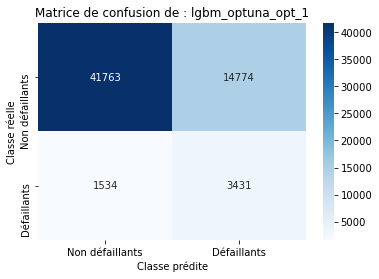

In [72]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1')

In [66]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_opt_1',
                                        1534, 14774, 3431, 41763, df_taux)

**Avec les hyperparamètres n_estimators et learning_rate**

In [16]:
# Modèle et hyperparamètres à étudier
def create_model_2(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [17]:
# Objective fonction
def objective_2(trial):
    model = create_model_2(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [18]:
# Recherche des p
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_2, n_trials=100)

[I 2021-08-04 15:33:31,720] A new study created in memory with name: no-name-e97e62b7-fbc3-4572-8e4a-8c9aee1ef6b0
[I 2021-08-04 15:33:35,325] Trial 0 finished with value: 0.6968381692880641 and parameters: {'n_estimators': 312, 'max_depth': 3, 'learning_rate': 0.988707598776313, 'subsample': 0.27967795156927844, 'colsample_bytree': 0.19644929242253195, 'reg_alpha': 0.0001501943283620202, 'reg_lambda': 0.000604555927461037, 'num_leaves': 229, 'min_child_weight': 0.803748264595513, 'subsample_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.6968381692880641.
[I 2021-08-04 15:33:40,071] Trial 1 finished with value: 0.7483494246235134 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.5686587346120079, 'subsample': 0.7460188675217183, 'colsample_bytree': 0.6739117262363492, 'reg_alpha': 0.5380529094245746, 'reg_lambda': 9.727860761485805e-07, 'num_leaves': 107, 'min_child_weight': 0.8777501034843227, 'subsample_freq': 1, 'min_child_samples': 35}. Best

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 15:35:28,166] Trial 12 finished with value: 0.7877913457595281 and parameters: {'n_estimators': 913, 'max_depth': 7, 'learning_rate': 0.016837338452009652, 'subsample': 0.7040694851966991, 'colsample_bytree': 0.5744713022179001, 'reg_alpha': 0.029175655307806227, 'reg_lambda': 5.3855892958947255e-06, 'num_leaves': 31, 'min_child_weight': 0.5790665825645824, 'subsample_freq': 3, 'min_child_samples': 68}. Best is trial 12 with value: 0.7877913457595281.
[I 2021-08-04 15:35:45,377] Trial 13 finished with value: 0.7253998678084084 and parameters: {'n_estimators': 985, 'max_depth': 8, 'learning_rate': 0.32907875741491255, 'subsample': 0.8164760029716016, 'colsample_bytree': 0.4801503428980427, 'reg_alpha': 0.013750114264905305, 'reg_lambda': 9.359730266562066e-06, 'num_leaves': 44, 'min_child_weight': 0.5345221655878496, 'subsample_freq': 3, 'min_child_samples': 65}. Best is trial 12 with value: 0.7877913457595281.
[I 2021-08-04 15:36:07,434] Trial 14 finished with value: 0.78

[I 2021-08-04 15:40:05,329] Trial 30 finished with value: 0.7234959661828636 and parameters: {'n_estimators': 917, 'max_depth': 7, 'learning_rate': 0.2673171835704412, 'subsample': 0.562918449327918, 'colsample_bytree': 0.4448903059910556, 'reg_alpha': 0.3927367546775936, 'reg_lambda': 0.003591530475311565, 'num_leaves': 92, 'min_child_weight': 0.5780601983506714, 'subsample_freq': 2, 'min_child_samples': 59}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:40:20,152] Trial 31 finished with value: 0.7487234348809637 and parameters: {'n_estimators': 796, 'max_depth': 7, 'learning_rate': 0.0010050001564065603, 'subsample': 0.6416582535997674, 'colsample_bytree': 0.6039819005869342, 'reg_alpha': 0.0067153644403621275, 'reg_lambda': 2.095204431988911e-05, 'num_leaves': 20, 'min_child_weight': 0.597140420311731, 'subsample_freq': 3, 'min_child_samples': 73}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:40:35,410] Trial 32 finished with value: 0.7857404

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 15:42:33,643] Trial 41 finished with value: 0.7869395013907869 and parameters: {'n_estimators': 775, 'max_depth': 7, 'learning_rate': 0.04183575027309839, 'subsample': 0.6668951384369434, 'colsample_bytree': 0.6243259251965654, 'reg_alpha': 4.6220844103835126e-08, 'reg_lambda': 8.722447600031492e-06, 'num_leaves': 31, 'min_child_weight': 0.5707819248845662, 'subsample_freq': 3, 'min_child_samples': 74}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:42:46,574] Trial 42 finished with value: 0.7857729792613598 and parameters: {'n_estimators': 876, 'max_depth': 6, 'learning_rate': 0.04840184337648954, 'subsample': 0.6218233870055785, 'colsample_bytree': 0.6281268095719224, 'reg_alpha': 5.043333329578468e-07, 'reg_lambda': 4.207504496291097e-06, 'num_leaves': 33, 'min_child_weight': 0.5670726656965195, 'subsample_freq': 4, 'min_child_samples': 62}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:42:58,546] Trial 43 finished with value: 0.7

[I 2021-08-04 15:45:58,026] Trial 58 finished with value: 0.7849819493658861 and parameters: {'n_estimators': 771, 'max_depth': 6, 'learning_rate': 0.1671801597635662, 'subsample': 0.6453153103832149, 'colsample_bytree': 0.6573177006740106, 'reg_alpha': 0.1741355225625988, 'reg_lambda': 2.667339203005741e-07, 'num_leaves': 4, 'min_child_weight': 0.5044809948576301, 'subsample_freq': 4, 'min_child_samples': 81}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:46:11,850] Trial 59 finished with value: 0.7875925578488727 and parameters: {'n_estimators': 894, 'max_depth': 11, 'learning_rate': 0.04126669269880569, 'subsample': 0.580511643243579, 'colsample_bytree': 0.46741427551555786, 'reg_alpha': 5.7463891654979725e-05, 'reg_lambda': 0.00015249653735403555, 'num_leaves': 32, 'min_child_weight': 0.5524143247817882, 'subsample_freq': 3, 'min_child_samples': 86}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:46:30,419] Trial 60 finished with value: 0.6532

[I 2021-08-04 15:49:28,410] Trial 75 finished with value: 0.7809513330850666 and parameters: {'n_estimators': 890, 'max_depth': 4, 'learning_rate': 0.1564585098162901, 'subsample': 0.6788260649111041, 'colsample_bytree': 0.570765077994909, 'reg_alpha': 4.321933100248536e-05, 'reg_lambda': 1.399175641532941e-06, 'num_leaves': 9, 'min_child_weight': 0.4290958947087534, 'subsample_freq': 3, 'min_child_samples': 69}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:49:41,054] Trial 76 finished with value: 0.7819436624138749 and parameters: {'n_estimators': 927, 'max_depth': 5, 'learning_rate': 0.08317589244284024, 'subsample': 0.5925844018826556, 'colsample_bytree': 0.6441899935497978, 'reg_alpha': 0.019743598999707596, 'reg_lambda': 2.685360983056416e-06, 'num_leaves': 22, 'min_child_weight': 0.5544939004314074, 'subsample_freq': 3, 'min_child_samples': 73}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:49:52,089] Trial 77 finished with value: 0.753284

[I 2021-08-04 15:53:24,263] Trial 93 finished with value: 0.7852156420981147 and parameters: {'n_estimators': 909, 'max_depth': 4, 'learning_rate': 0.07873485102298869, 'subsample': 0.6568065442706065, 'colsample_bytree': 0.4947048265702183, 'reg_alpha': 3.41947552634732e-05, 'reg_lambda': 4.260598832462959e-08, 'num_leaves': 28, 'min_child_weight': 0.525164185587915, 'subsample_freq': 3, 'min_child_samples': 60}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:53:38,310] Trial 94 finished with value: 0.731413062279831 and parameters: {'n_estimators': 803, 'max_depth': 8, 'learning_rate': 0.4989628240946143, 'subsample': 0.7163642925980795, 'colsample_bytree': 0.6617131562745103, 'reg_alpha': 0.00010054935472709537, 'reg_lambda': 1.9674585817175783e-08, 'num_leaves': 14, 'min_child_weight': 0.5948350582163031, 'subsample_freq': 2, 'min_child_samples': 76}. Best is trial 14 with value: 0.7878291967218893.
[I 2021-08-04 15:53:45,584] Trial 95 finished with value: 0.7863

In [19]:
params_2 = study_2.best_params
print(f'Nombre d\'essai terminés : {len(study_2.trials)}')
print('Best hyperparamètres:\n')
print(params_2)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'n_estimators': 834, 'max_depth': 11, 'learning_rate': 0.014718622233831746, 'subsample': 0.7035273029586243, 'colsample_bytree': 0.6894965729228903, 'reg_alpha': 0.02948349288827145, 'reg_lambda': 1.5519483811260933e-05, 'num_leaves': 52, 'min_child_weight': 0.523445287953193, 'subsample_freq': 4, 'min_child_samples': 96}


In [20]:
param_lgbm_optuna_opt_2 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.6894965729228903,
                           'max_depth': 11,
                           'min_child_weight': 0.523445287953193,
                           'num_leaves': 52,
                           'reg_alpha': 0.02948349288827145,
                           'reg_lambda': 1.5519483811260933e-05,
                           'subsample': 0.7035273029586243,
                           'subsample_freq ': 4,
                           'min_child_samples': 96,
                           'n_estimators': 834,
                           'learning_rate': 0.014718622233831746,
                           'verbosity' : -1}

In [21]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_2 = LGBMClassifier(**param_lgbm_optuna_opt_2,
                                      force_col_wise=True)

[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Cur

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_opt_2,0.6703,0.1950,0.3022,0.6129,0.6545,0.7878,0.2843,0.7165,19.4932,20.0797,0.8732,0.0003,0.7895,0.0040,0.8116,0.0010,0.6740,0.0106,0.2349,0.0006,0.1961,0.0022


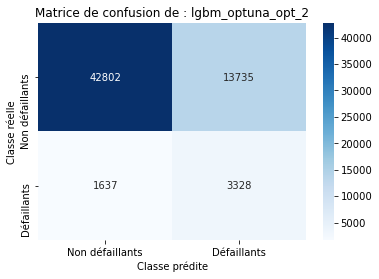

In [22]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_2')

In [23]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_opt_2',
                                        1637, 13735, 3328, 42802, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : Optuna intégrée à LightGBM - Score Métrique métier</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [27]:
# Modèle et hyperparamètres à étudier
def create_model_3(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'custom_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [30]:
# Objective fonction
def objective_3(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = outils_model.custom_score(y_valid, y_pred)
    return score

In [31]:
# Recherche des paramètres
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective_3, n_trials=100)

[I 2021-08-04 16:13:34,809] A new study created in memory with name: no-name-cb8a89f9-85ba-41f9-aeee-b31ce641e4e5
[I 2021-08-04 16:13:38,826] Trial 0 finished with value: 0.7061693050938439 and parameters: {'max_depth': 9, 'subsample': 0.5143280565724363, 'colsample_bytree': 0.9032313703018822, 'reg_alpha': 4.223804018120238, 'reg_lambda': 0.24722979846332802, 'num_leaves': 172, 'min_child_weight': 0.4563187602136527, 'subsample_freq': 6, 'min_child_samples': 32}. Best is trial 0 with value: 0.7061693050938439.
[I 2021-08-04 16:13:42,131] Trial 1 finished with value: 0.706724928663584 and parameters: {'max_depth': 9, 'subsample': 0.3392216601617554, 'colsample_bytree': 0.9638236147778109, 'reg_alpha': 4.9141152462815905, 'reg_lambda': 0.05917434452242703, 'num_leaves': 107, 'min_child_weight': 0.9474388602168557, 'subsample_freq': 4, 'min_child_samples': 70}. Best is trial 1 with value: 0.706724928663584.
[I 2021-08-04 16:13:44,425] Trial 2 finished with value: 0.7089191708966258 and p

[I 2021-08-04 16:14:35,113] Trial 20 finished with value: 0.7107838059272792 and parameters: {'max_depth': 5, 'subsample': 0.9812863959342286, 'colsample_bytree': 0.31280888914503746, 'reg_alpha': 0.0067848855942449025, 'reg_lambda': 9.599494825157288, 'num_leaves': 255, 'min_child_weight': 0.8541199421472161, 'subsample_freq': 5, 'min_child_samples': 87}. Best is trial 19 with value: 0.7131287257385556.
[I 2021-08-04 16:14:38,183] Trial 21 finished with value: 0.7132228992249522 and parameters: {'max_depth': 6, 'subsample': 0.8590895346773753, 'colsample_bytree': 0.3852849647614116, 'reg_alpha': 0.2720362238365019, 'reg_lambda': 0.00814956021523787, 'num_leaves': 235, 'min_child_weight': 0.8599991265027656, 'subsample_freq': 5, 'min_child_samples': 92}. Best is trial 21 with value: 0.7132228992249522.
[I 2021-08-04 16:14:40,693] Trial 22 finished with value: 0.7115466111670921 and parameters: {'max_depth': 6, 'subsample': 0.9055662897790696, 'colsample_bytree': 0.17580868956847656, 'r

[I 2021-08-04 16:15:39,179] Trial 40 finished with value: 0.7064329908557545 and parameters: {'max_depth': 8, 'subsample': 0.3481848743636227, 'colsample_bytree': 0.4003012916296154, 'reg_alpha': 0.6161019512973924, 'reg_lambda': 0.000756288504338453, 'num_leaves': 106, 'min_child_weight': 0.8857579738015504, 'subsample_freq': 6, 'min_child_samples': 88}. Best is trial 21 with value: 0.7132228992249522.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 16:15:42,875] Trial 41 finished with value: 0.7105483722112876 and parameters: {'max_depth': 8, 'subsample': 0.825392674674741, 'colsample_bytree': 0.42943236340416835, 'reg_alpha': 2.4033708212191414, 'reg_lambda': 0.0037869797179896046, 'num_leaves': 31, 'min_child_weight': 0.708934887667285, 'subsample_freq': 2, 'min_child_samples': 37}. Best is trial 21 with value: 0.7132228992249522.
[I 2021-08-04 16:15:47,039] Trial 42 finished with value: 0.7150121954664883 and parameters: {'max_depth': 8, 'subsample': 0.9454778288706059, 'colsample_bytree': 0.5718781758079232, 'reg_alpha': 0.18071193661508048, 'reg_lambda': 0.0024837448656333206, 'num_leaves': 61, 'min_child_weight': 0.6465661259867457, 'subsample_freq': 3, 'min_child_samples': 19}. Best is trial 42 with value: 0.7150121954664883.
[I 2021-08-04 16:15:50,970] Trial 43 finished with value: 0.7142117208321169 and parameters: {'max_depth': 7, 'subsample': 0.9448665072390404, 'colsample_bytree': 0.5651503970893389, 're

[I 2021-08-04 16:16:56,813] Trial 61 finished with value: 0.7113959335888574 and parameters: {'max_depth': 7, 'subsample': 0.9648501486489923, 'colsample_bytree': 0.4556204806529718, 'reg_alpha': 0.02756520435609196, 'reg_lambda': 5.4385980924801976e-06, 'num_leaves': 223, 'min_child_weight': 0.6624715208367365, 'subsample_freq': 2, 'min_child_samples': 65}. Best is trial 42 with value: 0.7150121954664883.
[I 2021-08-04 16:17:00,541] Trial 62 finished with value: 0.7129874655089606 and parameters: {'max_depth': 8, 'subsample': 0.999187935616302, 'colsample_bytree': 0.47106878990903794, 'reg_alpha': 0.007856509579726586, 'reg_lambda': 3.6146012735781657e-05, 'num_leaves': 41, 'min_child_weight': 0.5877214450564895, 'subsample_freq': 3, 'min_child_samples': 56}. Best is trial 42 with value: 0.7150121954664883.
[I 2021-08-04 16:17:03,817] Trial 63 finished with value: 0.712978048160321 and parameters: {'max_depth': 8, 'subsample': 0.8538011891675146, 'colsample_bytree': 0.4991942315311254

[I 2021-08-04 16:18:03,437] Trial 81 finished with value: 0.7116690366994076 and parameters: {'max_depth': 8, 'subsample': 0.846153985751462, 'colsample_bytree': 0.4882591428196591, 'reg_alpha': 0.005078584743350263, 'reg_lambda': 0.021665755132340245, 'num_leaves': 43, 'min_child_weight': 0.5851168354342562, 'subsample_freq': 5, 'min_child_samples': 56}. Best is trial 42 with value: 0.7150121954664883.
[I 2021-08-04 16:18:06,782] Trial 82 finished with value: 0.7122905817096254 and parameters: {'max_depth': 8, 'subsample': 0.8169419064293373, 'colsample_bytree': 0.4935681468331422, 'reg_alpha': 0.002360283531608694, 'reg_lambda': 0.013787279944012992, 'num_leaves': 39, 'min_child_weight': 0.669626120993623, 'subsample_freq': 5, 'min_child_samples': 54}. Best is trial 42 with value: 0.7150121954664883.
[I 2021-08-04 16:18:10,468] Trial 83 finished with value: 0.7127331970956897 and parameters: {'max_depth': 9, 'subsample': 0.8717676121751543, 'colsample_bytree': 0.4491208610155386, 're

In [32]:
params_3 = study_3.best_params
print(f'Nombre d\'essai terminés : {len(study_3.trials)}')
print('Best hyperparamètres:\n')
print(params_3)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 8, 'subsample': 0.9454778288706059, 'colsample_bytree': 0.5718781758079232, 'reg_alpha': 0.18071193661508048, 'reg_lambda': 0.0024837448656333206, 'num_leaves': 61, 'min_child_weight': 0.6465661259867457, 'subsample_freq': 3, 'min_child_samples': 19}


In [76]:
param_lgbm_optuna_opt_3 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.5718781758079232,
                           'max_depth': 8,
                           'min_child_weight': 0.6465661259867457,
                           'num_leaves': 61,
                           'reg_alpha': 0.18071193661508048,
                           'reg_lambda': 0.0024837448656333206,
                           'subsample': 0.9454778288706059,
                           'min_child_samples': 19,
                           'verbosity' : -1}

In [77]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_3 = LGBMClassifier(**param_lgbm_optuna_opt_3,
                                      force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_opt_3,0.6622,0.1896,0.2948,0.6043,0.6463,0.7822,0.2756,0.7097,3.3625,3.5151,0.8635,0.0003,0.7845,0.0047,0.7982,0.0014,0.6695,0.0114,0.2283,0.0004,0.1924,0.0025


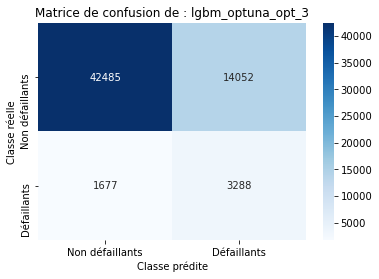

In [78]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_3')

In [38]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_opt_3',
                                        1677, 14052, 3288, 42485, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : Optuna intégrée à LightGBM - Score PR_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [39]:
# Modèle et hyperparamètres à étudier
def create_model_4(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'pr_auc',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [42]:
# Objective fonction
def objective_4(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = average_precision_score(y_valid, y_proba)
    return score

In [43]:
# Recherche des paramètres
study_4 = optuna.create_study(direction='maximize')
study_4.optimize(objective_4, n_trials=100)

[I 2021-08-04 16:23:58,109] A new study created in memory with name: no-name-e8afba86-764e-4779-81d1-a4da05aeff23
[I 2021-08-04 16:23:59,593] Trial 0 finished with value: 0.2587366731828134 and parameters: {'max_depth': 4, 'subsample': 0.13152612781634343, 'colsample_bytree': 0.12070151704602843, 'reg_alpha': 0.007218633009161635, 'reg_lambda': 0.019975376143986947, 'num_leaves': 7, 'min_child_weight': 0.9901809981293774, 'subsample_freq': 7, 'min_child_samples': 77}. Best is trial 0 with value: 0.2587366731828134.
[I 2021-08-04 16:24:02,510] Trial 1 finished with value: 0.2747541828869267 and parameters: {'max_depth': 6, 'subsample': 0.9163711141011938, 'colsample_bytree': 0.34976338732560397, 'reg_alpha': 9.789312465044919e-05, 'reg_lambda': 0.004875437350639946, 'num_leaves': 93, 'min_child_weight': 0.9408404535058381, 'subsample_freq': 4, 'min_child_samples': 100}. Best is trial 1 with value: 0.2747541828869267.
[I 2021-08-04 16:24:07,206] Trial 2 finished with value: 0.26729931897

[I 2021-08-04 16:25:13,333] Trial 20 finished with value: 0.27338399982331407 and parameters: {'max_depth': 5, 'subsample': 0.7277917738873948, 'colsample_bytree': 0.623237225264691, 'reg_alpha': 0.022876149767845244, 'reg_lambda': 0.08617341889482587, 'num_leaves': 69, 'min_child_weight': 0.6759093950666264, 'subsample_freq': 3, 'min_child_samples': 59}. Best is trial 4 with value: 0.27808673265775474.
[I 2021-08-04 16:25:17,023] Trial 21 finished with value: 0.27690286440561007 and parameters: {'max_depth': 9, 'subsample': 0.8514991932804689, 'colsample_bytree': 0.6603238284943472, 'reg_alpha': 0.3034781262943266, 'reg_lambda': 1.644990317859243e-08, 'num_leaves': 32, 'min_child_weight': 0.7835315525675577, 'subsample_freq': 6, 'min_child_samples': 27}. Best is trial 4 with value: 0.27808673265775474.
[I 2021-08-04 16:25:20,591] Trial 22 finished with value: 0.27692537831363667 and parameters: {'max_depth': 9, 'subsample': 0.881318164221552, 'colsample_bytree': 0.7618276147461152, 'r

[I 2021-08-04 16:26:22,566] Trial 40 finished with value: 0.2759533550578813 and parameters: {'max_depth': 8, 'subsample': 0.9513982195492322, 'colsample_bytree': 0.39923919136732233, 'reg_alpha': 0.0003309708826310262, 'reg_lambda': 6.10486946325945e-07, 'num_leaves': 80, 'min_child_weight': 0.6639187251934451, 'subsample_freq': 6, 'min_child_samples': 48}. Best is trial 36 with value: 0.27858988753740327.
[I 2021-08-04 16:26:26,580] Trial 41 finished with value: 0.27843715079223824 and parameters: {'max_depth': 8, 'subsample': 0.8822494301884878, 'colsample_bytree': 0.7051481557558895, 'reg_alpha': 8.764309809061772e-07, 'reg_lambda': 1.8356614832717567e-05, 'num_leaves': 61, 'min_child_weight': 0.6990253618130109, 'subsample_freq': 6, 'min_child_samples': 32}. Best is trial 36 with value: 0.27858988753740327.
[I 2021-08-04 16:26:30,167] Trial 42 finished with value: 0.2719249469787445 and parameters: {'max_depth': 8, 'subsample': 0.8864371003348973, 'colsample_bytree': 0.59193166935

[I 2021-08-04 16:27:41,608] Trial 60 finished with value: 0.2754002499070961 and parameters: {'max_depth': 10, 'subsample': 0.831951344003386, 'colsample_bytree': 0.8197706450331801, 'reg_alpha': 5.87990570417739e-06, 'reg_lambda': 1.2988111172876162e-05, 'num_leaves': 14, 'min_child_weight': 0.7279879462907329, 'subsample_freq': 4, 'min_child_samples': 54}. Best is trial 49 with value: 0.27889809255627385.
[I 2021-08-04 16:27:46,814] Trial 61 finished with value: 0.2761812542429576 and parameters: {'max_depth': 8, 'subsample': 0.9661712975775494, 'colsample_bytree': 0.8379871850790722, 'reg_alpha': 2.8096583851237922e-05, 'reg_lambda': 0.0004911812452665998, 'num_leaves': 81, 'min_child_weight': 0.6949067195965356, 'subsample_freq': 2, 'min_child_samples': 39}. Best is trial 49 with value: 0.27889809255627385.
[I 2021-08-04 16:27:51,515] Trial 62 finished with value: 0.27914790240356946 and parameters: {'max_depth': 11, 'subsample': 0.9422195329264292, 'colsample_bytree': 0.9026530444

[I 2021-08-04 16:29:07,783] Trial 80 finished with value: 0.27629761109723083 and parameters: {'max_depth': 11, 'subsample': 0.9742699427191934, 'colsample_bytree': 0.9702014097315332, 'reg_alpha': 0.00032820388408074454, 'reg_lambda': 0.4827958033868209, 'num_leaves': 69, 'min_child_weight': 0.4040711609032672, 'subsample_freq': 5, 'min_child_samples': 66}. Best is trial 76 with value: 0.2806253771468368.
[I 2021-08-04 16:29:11,945] Trial 81 finished with value: 0.27691126800261995 and parameters: {'max_depth': 10, 'subsample': 0.9503705536379852, 'colsample_bytree': 0.8856187687912642, 'reg_alpha': 1.0361379958453218e-05, 'reg_lambda': 0.22654766882854543, 'num_leaves': 38, 'min_child_weight': 0.49612123648339107, 'subsample_freq': 5, 'min_child_samples': 53}. Best is trial 76 with value: 0.2806253771468368.
[I 2021-08-04 16:29:15,360] Trial 82 finished with value: 0.2742732857935873 and parameters: {'max_depth': 11, 'subsample': 0.8622053969633913, 'colsample_bytree': 0.849749626735

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 16:29:23,614] Trial 84 finished with value: 0.2771422393809745 and parameters: {'max_depth': 11, 'subsample': 0.9517934183221798, 'colsample_bytree': 0.9115054372776061, 'reg_alpha': 9.946647890125436e-05, 'reg_lambda': 2.787133497171547, 'num_leaves': 31, 'min_child_weight': 0.5233102324530154, 'subsample_freq': 5, 'min_child_samples': 72}. Best is trial 76 with value: 0.2806253771468368.
[I 2021-08-04 16:29:28,367] Trial 85 finished with value: 0.27879175016640645 and parameters: {'max_depth': 11, 'subsample': 0.8872422883401184, 'colsample_bytree': 0.9562152629238878, 'reg_alpha': 1.672291403795815e-05, 'reg_lambda': 9.44362835413443, 'num_leaves': 52, 'min_child_weight': 0.4840049187323366, 'subsample_freq': 4, 'min_child_samples': 47}. Best is trial 76 with value: 0.2806253771468368.
[I 2021-08-04 16:29:33,569] Trial 86 finished with value: 0.28084827367972204 and parameters: {'max_depth': 11, 'subsample': 0.8908851564630833, 'colsample_bytree': 0.952643096444903, 'r

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 16:30:32,782] Trial 99 finished with value: 0.27723507528200825 and parameters: {'max_depth': 9, 'subsample': 0.9869529774027822, 'colsample_bytree': 0.8276625800596636, 'reg_alpha': 0.000997059618880444, 'reg_lambda': 0.15474783873737424, 'num_leaves': 31, 'min_child_weight': 0.5487308904744312, 'subsample_freq': 5, 'min_child_samples': 58}. Best is trial 98 with value: 0.2809449672543505.


In [44]:
params_4 = study_4.best_params
print(f'Nombre d\'essai terminés : {len(study_4.trials)}')
print('Best hyperparamètres:\n')
print(params_4)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 9, 'subsample': 0.987231243818891, 'colsample_bytree': 0.8261904147922055, 'reg_alpha': 0.0007256219811168144, 'reg_lambda': 0.1572008249620546, 'num_leaves': 46, 'min_child_weight': 0.5372909285544536, 'subsample_freq': 5, 'min_child_samples': 57}


In [45]:
param_lgbm_optuna_opt_4 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.8261904147922055,
                           'max_depth': 9,
                           'min_child_weight': 0.5372909285544536,
                           'num_leaves': 46,
                           'reg_alpha': 0.0007256219811168144,
                           'reg_lambda': 0.1572008249620546,
                           'subsample': 0.987231243818891,
                           'min_child_samples': 57,
                           'verbosity' : -1}

In [46]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_4 = LGBMClassifier(**param_lgbm_optuna_opt_4,
                                      force_col_wise=True)

[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Cur

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_opt_4,0.6816,0.1885,0.2954,0.6193,0.6644,0.7841,0.2784,0.7140,3.6866,3.8283,0.8510,0.0003,0.7860,0.0043,0.7859,0.0017,0.6837,0.0107,0.2173,0.0005,0.1896,0.0024


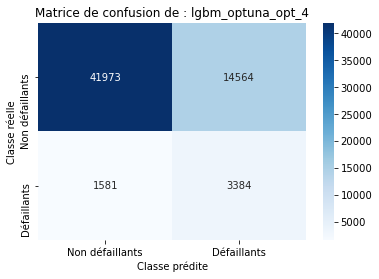

In [47]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_4')

In [48]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_opt_4',
                                        1581, 14564, 3384, 41973, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : Optuna intégrée à LightGBM - Score F-mesure avec beta=10</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [49]:
# Modèle et hyperparamètres à étudier
def create_model_5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [50]:
# Objective fonction
def objective_5(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 10)
    return score

In [51]:
# Recherche des paramètres
study_5 = optuna.create_study(direction='maximize')
study_5.optimize(objective_5, n_trials=100)

[I 2021-08-04 16:32:53,982] A new study created in memory with name: no-name-11336b70-6cda-4504-bc4d-a690f6c1d7cd
[I 2021-08-04 16:32:58,259] Trial 0 finished with value: 0.6424293619265795 and parameters: {'max_depth': 7, 'subsample': 0.778044631572549, 'colsample_bytree': 0.6756599563113133, 'reg_alpha': 9.259975854437873e-06, 'reg_lambda': 0.19536101072818376, 'num_leaves': 62, 'min_child_weight': 0.6524680364151136, 'subsample_freq': 2, 'min_child_samples': 61}. Best is trial 0 with value: 0.6424293619265795.
[I 2021-08-04 16:33:00,858] Trial 1 finished with value: 0.6850395988965005 and parameters: {'max_depth': 11, 'subsample': 0.6825161074902483, 'colsample_bytree': 0.8469445294334857, 'reg_alpha': 0.0003627957068511524, 'reg_lambda': 3.209270968238162e-06, 'num_leaves': 11, 'min_child_weight': 0.6056221639585957, 'subsample_freq': 5, 'min_child_samples': 60}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:33:03,227] Trial 2 finished with value: 0.6512846149656

[I 2021-08-04 16:33:54,014] Trial 20 finished with value: 0.6710624871443596 and parameters: {'max_depth': 10, 'subsample': 0.5710184755283847, 'colsample_bytree': 0.12467770112311377, 'reg_alpha': 3.690373704703852e-05, 'reg_lambda': 0.5579831547610457, 'num_leaves': 24, 'min_child_weight': 0.691974388492995, 'subsample_freq': 6, 'min_child_samples': 5}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:33:56,084] Trial 21 finished with value: 0.6800109180238376 and parameters: {'max_depth': 6, 'subsample': 0.4954136070731927, 'colsample_bytree': 0.5234448820965084, 'reg_alpha': 1.0467943251950316e-08, 'reg_lambda': 5.4782628445840675, 'num_leaves': 6, 'min_child_weight': 0.9376959838690093, 'subsample_freq': 4, 'min_child_samples': 91}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:33:58,094] Trial 22 finished with value: 0.6760257131968749 and parameters: {'max_depth': 6, 'subsample': 0.5400054130858714, 'colsample_bytree': 0.47380600269523276, 'reg

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 16:34:00,756] Trial 23 finished with value: 0.6632016309096205 and parameters: {'max_depth': 8, 'subsample': 0.3716400249194079, 'colsample_bytree': 0.6046361185945458, 'reg_alpha': 2.4909503134637617e-08, 'reg_lambda': 0.018858209194748822, 'num_leaves': 31, 'min_child_weight': 0.8897768462504235, 'subsample_freq': 3, 'min_child_samples': 69}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:34:03,448] Trial 24 finished with value: 0.6525426698227801 and parameters: {'max_depth': 7, 'subsample': 0.6117792526323649, 'colsample_bytree': 0.43374180724905276, 'reg_alpha': 5.868993755095043e-07, 'reg_lambda': 9.11193788304171, 'num_leaves': 74, 'min_child_weight': 0.9991625310573539, 'subsample_freq': 5, 'min_child_samples': 86}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:34:06,672] Trial 25 finished with value: 0.674221325782553 and parameters: {'max_depth': 8, 'subsample': 0.8001119614412203, 'colsample_bytree': 0.6276214758931818, 'reg

[I 2021-08-04 16:34:48,781] Trial 43 finished with value: 0.6786719058801647 and parameters: {'max_depth': 9, 'subsample': 0.44304641065143047, 'colsample_bytree': 0.5803029136386805, 'reg_alpha': 3.504065929361117e-08, 'reg_lambda': 0.010517169478335416, 'num_leaves': 14, 'min_child_weight': 0.6718523590706355, 'subsample_freq': 5, 'min_child_samples': 44}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:34:52,298] Trial 44 finished with value: 0.6209032555306538 and parameters: {'max_depth': 8, 'subsample': 0.6509123072887177, 'colsample_bytree': 0.7188823710349764, 'reg_alpha': 1.078601610693935e-07, 'reg_lambda': 0.30341718065157747, 'num_leaves': 130, 'min_child_weight': 0.5207055580172774, 'subsample_freq': 5, 'min_child_samples': 94}. Best is trial 1 with value: 0.6850395988965005.
[I 2021-08-04 16:34:55,946] Trial 45 finished with value: 0.6602526948017848 and parameters: {'max_depth': 9, 'subsample': 0.5815544752183958, 'colsample_bytree': 0.9189052547438237, 

[I 2021-08-04 16:35:48,375] Trial 63 finished with value: 0.684530955903426 and parameters: {'max_depth': 8, 'subsample': 0.6878620992685746, 'colsample_bytree': 0.9805761369956726, 'reg_alpha': 3.6914348794093794e-06, 'reg_lambda': 0.02665774115244441, 'num_leaves': 8, 'min_child_weight': 0.7566245500565588, 'subsample_freq': 1, 'min_child_samples': 17}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:35:51,825] Trial 64 finished with value: 0.6690989108310933 and parameters: {'max_depth': 8, 'subsample': 0.6877870301608922, 'colsample_bytree': 0.9965644646101095, 'reg_alpha': 2.5406651933617148e-06, 'reg_lambda': 0.2857559324119123, 'num_leaves': 33, 'min_child_weight': 0.7513607121631942, 'subsample_freq': 1, 'min_child_samples': 18}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:35:54,128] Trial 65 finished with value: 0.6820624816071125 and parameters: {'max_depth': 7, 'subsample': 0.6964971132656682, 'colsample_bytree': 0.9998572112833004, 'r

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 16:36:10,624] Trial 70 finished with value: 0.671091133267963 and parameters: {'max_depth': 6, 'subsample': 0.9849837857639827, 'colsample_bytree': 0.7835005793553855, 'reg_alpha': 1.749948289685634e-05, 'reg_lambda': 0.794979759521533, 'num_leaves': 31, 'min_child_weight': 0.8410361949614028, 'subsample_freq': 2, 'min_child_samples': 13}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:36:13,444] Trial 71 finished with value: 0.6781269443157656 and parameters: {'max_depth': 7, 'subsample': 0.8406935857122879, 'colsample_bytree': 0.8694990709729289, 'reg_alpha': 0.0001810048444563936, 'reg_lambda': 1.4057505757312618, 'num_leaves': 12, 'min_child_weight': 0.7911164396064991, 'subsample_freq': 1, 'min_child_samples': 23}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:36:16,566] Trial 72 finished with value: 0.681906241645324 and parameters: {'max_depth': 6, 'subsample': 0.7297958464886111, 'colsample_bytree': 0.8472427812923929, 'reg_a

[I 2021-08-04 16:37:11,569] Trial 90 finished with value: 0.6288612335661061 and parameters: {'max_depth': 7, 'subsample': 0.7413617689253522, 'colsample_bytree': 0.8546540042133982, 'reg_alpha': 7.012052511350669e-06, 'reg_lambda': 0.03507360527647401, 'num_leaves': 252, 'min_child_weight': 0.9926400093879204, 'subsample_freq': 1, 'min_child_samples': 20}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:37:14,208] Trial 91 finished with value: 0.685974405255289 and parameters: {'max_depth': 8, 'subsample': 0.811617336254543, 'colsample_bytree': 0.7893016862200662, 'reg_alpha': 3.81837546023647e-07, 'reg_lambda': 0.39673868212835944, 'num_leaves': 8, 'min_child_weight': 0.6772304690129058, 'subsample_freq': 4, 'min_child_samples': 24}. Best is trial 62 with value: 0.6869404394178535.
[I 2021-08-04 16:37:17,166] Trial 92 finished with value: 0.6844923723132602 and parameters: {'max_depth': 8, 'subsample': 0.8130179561543709, 'colsample_bytree': 0.770760376045133, 'reg_

In [52]:
params_5 = study_5.best_params
print(f'Nombre d\'essai terminés : {len(study_5.trials)}')
print('Best hyperparamètres:\n')
print(params_5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 7, 'subsample': 0.5734266368463582, 'colsample_bytree': 0.9912835896053127, 'reg_alpha': 3.4935052039660983e-06, 'reg_lambda': 0.0043640278729401225, 'num_leaves': 10, 'min_child_weight': 0.7522023053016109, 'subsample_freq': 2, 'min_child_samples': 12}


In [53]:
param_lgbm_optuna_opt_5 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.9912835896053127,
                           'max_depth': 7,
                           'min_child_samples': 12,
                           'min_child_weight': 0.7522023053016109,
                           'num_leaves': 10,
                           'reg_alpha': 3.4935052039660983e-06,
                           'reg_lambda': 0.0043640278729401225,
                           'subsample': 0.5734266368463582,
                           'subsample_freq ': 2,
                           'verbosity' : -1}

In [54]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_5 = LGBMClassifier(**param_lgbm_optuna_opt_5,
                                      force_col_wise=True)

[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Current value: subsample_freq=0
[LightGBM] [Warning] Unknown parameter: 2
[LightGBM] [Warning] subsample_freq is set=0, subsample_freq= will be ignored. Cur

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_opt_5,0.7001,0.1771,0.2827,0.6287,0.6802,0.7794,0.2708,0.7076,2.9826,3.1172,0.7963,0.0006,0.7820,0.0046,0.7298,0.0016,0.7104,0.0095,0.1832,0.0007,0.1784,0.0024


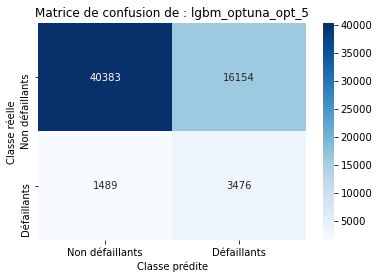

In [55]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_5')

In [56]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_opt_5',
                                        1489, 16154, 3476, 40383, df_taux)

### <span style='background:PowderBlue'>6.6. Optimisation : rééquilibrage des classes</span>

**Répartition variable cible?**

In [79]:
# Jeu d'entraînement du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_train_distrib = Counter(y_train)
print('Répartition des classes : ')
print(y_train_distrib)
# Pourcentage
y_train_distrib_norm = y_train.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_train_distrib_norm)

Répartition des classes : 
Counter({0: 226145, 1: 19860})

Répartition des classes (en %) :
0    91.927
1     8.073
Name: TARGET, dtype: float64


In [80]:
# Jeu de validation du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_valid_distrib = Counter(y_valid)
print('Répartition des classes : ')
print(y_valid_distrib)
# Pourcentage
y_valid_distrib_norm = y_valid.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_valid_distrib_norm)

Répartition des classes : 
Counter({0: 56537, 1: 4965})

Répartition des classes (en %) :
0    91.9271
1     8.0729
Name: TARGET, dtype: float64


**Bilan** :
- La variable cible est fortement déséquilibrée 90% de non défaillants et 10% de défaillants ==> on tentera un rééquilibrage de la variable cible pour optimiser le modèle.

Plusieurs méthodes de réquilibrage sont à notre disposition :
- undersampling : consiste en un sous-échantillonnage de la classe majoritaire.
- oversampling : sur-échantillonnage de la classe minoritaire (ex : SMOTE, ADASYN).
- une combinaison d'oversampling suivi d'undersampling (possible avec SMOTE).
- hyperparamètre du modèle Ligthgbm : class_weight='balanced'.

[Source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

#### <span style='background:Moccasin'>6.6.1. Rééquilibrage - oversampling : SMOTE</span>

**SMOTE - paramètres par défaut**

In [83]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE()
X_train_smote, y_train_smote = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote, y_valid_smote = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_def = Counter(y_train_smote)
print(counter_smote_def)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [100]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base = LGBMClassifier(random_state=seed, verbose=0,
                                 force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_hyperparam_base,0.9095,0.9920,0.9489,0.9124,0.9102,0.9777,0.9840,0.9171,6.8409,7.0481,0.9798,0.0067,0.9696,0.0897,0.9118,0.0269,0.9060,0.2610,0.9918,0.0025,0.9913,0.0017


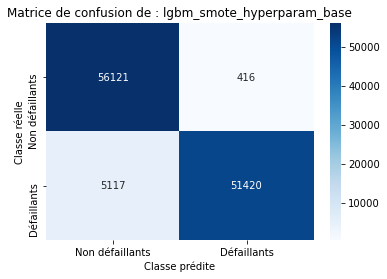

In [101]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base')

In [102]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_hyperparam_base',
                                        5117, 416, 51420, 56121, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_hyperparam_base_train,0.0403,0.5391,0.0750,0.0418,0.0407,0.7817,0.2703,0.5497,3.6895,3.8292,0.8357,0.0006,0.7839,0.0038,0.0579,0.0018,0.0384,0.0043,0.7482,0.0082,0.5449,0.0427


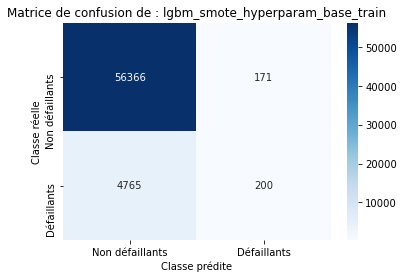

In [191]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base_train')

In [192]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_bal_train',
                                        4765, 171, 200, 56366, df_taux)

#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base + class_weight='balanced'**</span>

In [103]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_bal = LGBMClassifier(class_weight='balanced',
                                     random_state=seed, verbose=0,
                                     force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_base_bal,0.9095,0.9920,0.9489,0.9124,0.9102,0.9777,0.9840,0.9171,7.0421,7.2546,0.9798,0.0067,0.9696,0.0897,0.9118,0.0269,0.9060,0.2610,0.9918,0.0025,0.9913,0.0017


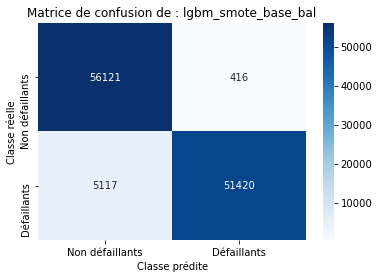

In [104]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_base_bal')

In [105]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_bal',
                                        5117, 416, 51420, 56121, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_base_bal_train,0.6939,0.1851,0.2923,0.6275,0.6755,0.7837,0.2781,0.7141,3.9365,4.0831,0.8330,0.0004,0.7855,0.0042,0.7662,0.0019,0.6958,0.0121,0.2036,0.0006,0.1852,0.0026


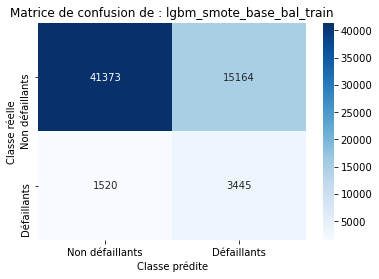

In [189]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_bal_train')

In [190]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_bal_train',
                                        1520, 15164, 3445, 41373, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [126]:
# Modèle et hyperparamètres à étudier
def create_model_7(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [136]:
# Objective fonction
def objective_7(trial):
    model = create_model_7(trial)
    model.fit(X_train_smote, y_train_smote)
    y_proba_smote = model.predict_proba(X_valid_smote)[:,1]
    score = roc_auc_score(y_valid_smote, y_proba_smote)
    return score

In [137]:
# Recherche des paramètres
study_7 = optuna.create_study(direction='maximize')
study_7.optimize(objective_7, n_trials=100)

[I 2021-08-04 18:13:21,037] A new study created in memory with name: no-name-8fc281b5-d643-4053-bf1e-8d815a5cbd48
[I 2021-08-04 18:13:24,206] Trial 0 finished with value: 0.9768809790200194 and parameters: {'max_depth': 8, 'subsample': 0.17442783976666798, 'colsample_bytree': 0.7735131678677346, 'reg_alpha': 0.26035322886138024, 'reg_lambda': 3.8385509404755755e-07, 'num_leaves': 44, 'min_child_weight': 0.8358220813736779, 'subsample_freq': 7, 'min_child_samples': 31}. Best is trial 0 with value: 0.9768809790200194.
[I 2021-08-04 18:13:30,987] Trial 1 finished with value: 0.9775340183335504 and parameters: {'max_depth': 8, 'subsample': 0.6050471055514376, 'colsample_bytree': 0.6543418609839939, 'reg_alpha': 0.0166280657491606, 'reg_lambda': 0.00032535371263182444, 'num_leaves': 148, 'min_child_weight': 0.5664905324662912, 'subsample_freq': 2, 'min_child_samples': 86}. Best is trial 1 with value: 0.9775340183335504.
[I 2021-08-04 18:13:35,874] Trial 2 finished with value: 0.976871511902

[I 2021-08-04 18:15:31,389] Trial 20 finished with value: 0.9766305745353938 and parameters: {'max_depth': 9, 'subsample': 0.9254801570810669, 'colsample_bytree': 0.7929654445541026, 'reg_alpha': 1.843675965168363e-07, 'reg_lambda': 3.3273824754187957e-06, 'num_leaves': 21, 'min_child_weight': 0.7710060108772478, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 17 with value: 0.9784832869711187.
[I 2021-08-04 18:15:42,554] Trial 21 finished with value: 0.9784450139886567 and parameters: {'max_depth': 11, 'subsample': 0.9961063862511308, 'colsample_bytree': 0.8828066619892745, 'reg_alpha': 4.314843186154959e-05, 'reg_lambda': 3.621004138670746e-05, 'num_leaves': 88, 'min_child_weight': 0.9835877513421717, 'subsample_freq': 3, 'min_child_samples': 76}. Best is trial 17 with value: 0.9784832869711187.
[I 2021-08-04 18:15:52,528] Trial 22 finished with value: 0.9782339749544691 and parameters: {'max_depth': 11, 'subsample': 0.9973858902168471, 'colsample_bytree': 0.912435649437

[I 2021-08-04 18:18:22,156] Trial 40 finished with value: 0.9781576138831799 and parameters: {'max_depth': 10, 'subsample': 0.770502167816671, 'colsample_bytree': 0.787917306042866, 'reg_alpha': 0.40820923248449875, 'reg_lambda': 8.999121909973544e-08, 'num_leaves': 131, 'min_child_weight': 0.7369080969761442, 'subsample_freq': 5, 'min_child_samples': 93}. Best is trial 35 with value: 0.978540843327319.
[I 2021-08-04 18:18:34,290] Trial 41 finished with value: 0.9784122812454223 and parameters: {'max_depth': 10, 'subsample': 0.9673073611048405, 'colsample_bytree': 0.9396422836746394, 'reg_alpha': 0.00029643298111547165, 'reg_lambda': 1.1219848503353496e-05, 'num_leaves': 252, 'min_child_weight': 0.9115157213154588, 'subsample_freq': 5, 'min_child_samples': 64}. Best is trial 35 with value: 0.978540843327319.
[I 2021-08-04 18:18:45,085] Trial 42 finished with value: 0.978215192764493 and parameters: {'max_depth': 9, 'subsample': 0.8956589371439045, 'colsample_bytree': 0.9409490816605129

[I 2021-08-04 18:21:26,863] Trial 60 finished with value: 0.9783917089346683 and parameters: {'max_depth': 11, 'subsample': 0.6722182804900381, 'colsample_bytree': 0.6520169308601421, 'reg_alpha': 0.34783123278867994, 'reg_lambda': 0.27091245067071285, 'num_leaves': 192, 'min_child_weight': 0.4114074512752712, 'subsample_freq': 6, 'min_child_samples': 56}. Best is trial 52 with value: 0.9786517441564552.
[I 2021-08-04 18:21:37,642] Trial 61 finished with value: 0.9785843921917813 and parameters: {'max_depth': 11, 'subsample': 0.924857919010062, 'colsample_bytree': 0.7675920967654445, 'reg_alpha': 0.08399909510135496, 'reg_lambda': 9.170598747109523, 'num_leaves': 236, 'min_child_weight': 0.48501415614227533, 'subsample_freq': 5, 'min_child_samples': 64}. Best is trial 52 with value: 0.9786517441564552.
[I 2021-08-04 18:21:47,855] Trial 62 finished with value: 0.9784463692496164 and parameters: {'max_depth': 11, 'subsample': 0.882014743272447, 'colsample_bytree': 0.7646646196275654, 're

[I 2021-08-04 18:24:33,483] Trial 80 finished with value: 0.9784090870592732 and parameters: {'max_depth': 11, 'subsample': 0.9993182062130913, 'colsample_bytree': 0.4680615477860335, 'reg_alpha': 3.5983114783469827, 'reg_lambda': 0.07599755057069535, 'num_leaves': 183, 'min_child_weight': 0.4888662961077876, 'subsample_freq': 6, 'min_child_samples': 79}. Best is trial 70 with value: 0.9788408524904411.
[I 2021-08-04 18:24:41,409] Trial 81 finished with value: 0.9783397816667524 and parameters: {'max_depth': 11, 'subsample': 0.9425021151284745, 'colsample_bytree': 0.39045363604917005, 'reg_alpha': 1.4639852234534971, 'reg_lambda': 5.512875128806431, 'num_leaves': 218, 'min_child_weight': 0.5205873809670392, 'subsample_freq': 6, 'min_child_samples': 14}. Best is trial 70 with value: 0.9788408524904411.
[I 2021-08-04 18:24:54,316] Trial 82 finished with value: 0.9783659173675451 and parameters: {'max_depth': 11, 'subsample': 0.9032508221489556, 'colsample_bytree': 0.7141897259052407, 're

In [138]:
params_7 = study_7.best_params
print(f'Nombre d\'essai terminés : {len(study_7.trials)}')
print('Best hyperparamètres:\n')
print(params_7)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9756875711411908, 'colsample_bytree': 0.66452650163612, 'reg_alpha': 4.077412112959774, 'reg_lambda': 2.31006906681335, 'num_leaves': 212, 'min_child_weight': 0.5799015414131308, 'subsample_freq': 6, 'min_child_samples': 24}


In [139]:
param_lgbm_optuna_opt_7 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.66452650163612,
                           'max_depth': 11,
                           'min_child_samples': 24,
                           'min_child_weight': 0.5799015414131308,
                           'num_leaves': 212,
                           'reg_alpha': 4.077412112959774,
                           'reg_lambda': 2.31006906681335,
                           'subsample': 0.9756875711411908,
                           'verbosity' : -1}

In [140]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_7 = LGBMClassifier(**param_lgbm_optuna_opt_7,
                                         force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_7,0.9115,0.9913,0.9497,0.9143,0.9122,0.9785,0.9845,0.9188,9.5386,9.8557,0.9888,0.0037,0.9720,0.0833,0.9228,0.0250,0.9092,0.2621,0.9953,0.0015,0.9910,0.0029


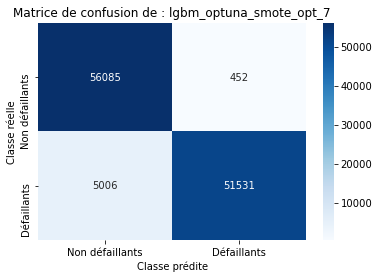

In [146]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7')

In [147]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_7',
                                        5006, 452, 1531, 56085, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_7_train,0.0524,0.5616,0.0958,0.0543,0.0528,0.7805,0.2737,0.5550,5.5652,5.7128,0.9309,0.0006,0.7847,0.0044,0.1710,0.0023,0.0451,0.0044,0.9567,0.0034,0.5226,0.0479


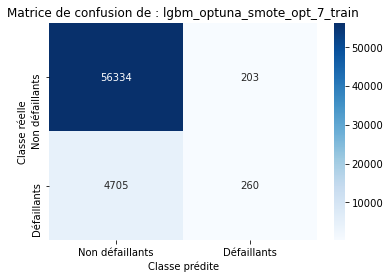

In [187]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7_train')

In [188]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_7_train',
                                        4705, 203, 260, 56334, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [85]:
# Modèle et hyperparamètres à étudier
def create_model_6(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
#         class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [88]:
# Objective fonction
def objective_6(trial):
    model = create_model_6(trial)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_valid_smote)
    score = fbeta_score(y_valid_smote, y_pred_smote, 10)
    return score

In [89]:
# Recherche des paramètres
study_6 = optuna.create_study(direction='maximize')
study_6.optimize(objective_6, n_trials=100)

[I 2021-08-04 17:01:50,889] A new study created in memory with name: no-name-a277874a-1e75-4bfe-923d-766b9303dbb7
[I 2021-08-04 17:01:55,344] Trial 0 finished with value: 0.9053686300634941 and parameters: {'max_depth': 7, 'subsample': 0.29913300109424235, 'colsample_bytree': 0.598449715916708, 'reg_alpha': 0.43544317113128367, 'reg_lambda': 0.0003886899932831044, 'num_leaves': 16, 'min_child_weight': 0.8849234294202346, 'subsample_freq': 1, 'min_child_samples': 54}. Best is trial 0 with value: 0.9053686300634941.
[I 2021-08-04 17:02:01,423] Trial 1 finished with value: 0.9111536455448793 and parameters: {'max_depth': 8, 'subsample': 0.63799140377169, 'colsample_bytree': 0.5778058215831583, 'reg_alpha': 0.001423334807395321, 'reg_lambda': 1.1136885259344256, 'num_leaves': 187, 'min_child_weight': 0.7859267753894617, 'subsample_freq': 1, 'min_child_samples': 20}. Best is trial 1 with value: 0.9111536455448793.
[I 2021-08-04 17:02:05,715] Trial 2 finished with value: 0.9047618463397904 a

[I 2021-08-04 17:03:41,297] Trial 20 finished with value: 0.9114946084380902 and parameters: {'max_depth': 8, 'subsample': 0.892141017654617, 'colsample_bytree': 0.4921053814269227, 'reg_alpha': 0.07006122398434612, 'reg_lambda': 0.0038707923497475092, 'num_leaves': 106, 'min_child_weight': 0.5645804397520647, 'subsample_freq': 5, 'min_child_samples': 85}. Best is trial 10 with value: 0.9146106528430281.
[I 2021-08-04 17:03:45,689] Trial 21 finished with value: 0.9143499402006958 and parameters: {'max_depth': 11, 'subsample': 0.884554761116807, 'colsample_bytree': 0.12097642770486203, 'reg_alpha': 8.058005440402786, 'reg_lambda': 0.145967445865588, 'num_leaves': 254, 'min_child_weight': 0.4129358917605799, 'subsample_freq': 7, 'min_child_samples': 90}. Best is trial 10 with value: 0.9146106528430281.
[I 2021-08-04 17:03:50,742] Trial 22 finished with value: 0.9127989329986979 and parameters: {'max_depth': 10, 'subsample': 0.8435318481402374, 'colsample_bytree': 0.211755363335118, 'reg_

[I 2021-08-04 17:05:22,923] Trial 40 finished with value: 0.9077024729656309 and parameters: {'max_depth': 6, 'subsample': 0.43144258424405335, 'colsample_bytree': 0.1584280270893779, 'reg_alpha': 0.0003458708423006163, 'reg_lambda': 0.0018910711057054613, 'num_leaves': 256, 'min_child_weight': 0.8561063550591242, 'subsample_freq': 7, 'min_child_samples': 81}. Best is trial 23 with value: 0.9150929193419626.
[I 2021-08-04 17:05:27,459] Trial 41 finished with value: 0.9146696881827001 and parameters: {'max_depth': 11, 'subsample': 0.9911778702595613, 'colsample_bytree': 0.11738760652703305, 'reg_alpha': 3.512009724101651, 'reg_lambda': 0.08542318326091543, 'num_leaves': 233, 'min_child_weight': 0.4344744213806082, 'subsample_freq': 7, 'min_child_samples': 97}. Best is trial 23 with value: 0.9150929193419626.
[I 2021-08-04 17:05:31,972] Trial 42 finished with value: 0.9149768670169826 and parameters: {'max_depth': 11, 'subsample': 0.991893952614051, 'colsample_bytree': 0.1064441190167283

[I 2021-08-04 17:06:57,038] Trial 60 finished with value: 0.9144647148195812 and parameters: {'max_depth': 11, 'subsample': 0.2765918513685054, 'colsample_bytree': 0.14395579513588122, 'reg_alpha': 0.0070356101347851495, 'reg_lambda': 0.033504789904695076, 'num_leaves': 150, 'min_child_weight': 0.45039942107766273, 'subsample_freq': 5, 'min_child_samples': 67}. Best is trial 54 with value: 0.915187739689223.
[I 2021-08-04 17:07:00,427] Trial 61 finished with value: 0.914079371260665 and parameters: {'max_depth': 9, 'subsample': 0.3516640531622328, 'colsample_bytree': 0.10862449704337115, 'reg_alpha': 0.05042706745207787, 'reg_lambda': 0.31932422805008653, 'num_leaves': 202, 'min_child_weight': 0.4150507091873768, 'subsample_freq': 7, 'min_child_samples': 75}. Best is trial 54 with value: 0.915187739689223.
[I 2021-08-04 17:07:03,662] Trial 62 finished with value: 0.9141929473059921 and parameters: {'max_depth': 10, 'subsample': 0.20501271742388094, 'colsample_bytree': 0.106001798994384

[I 2021-08-04 17:08:18,440] Trial 80 finished with value: 0.9143194191486886 and parameters: {'max_depth': 11, 'subsample': 0.40860611673753033, 'colsample_bytree': 0.20497912699787024, 'reg_alpha': 0.013237945674926132, 'reg_lambda': 2.06068117396935e-08, 'num_leaves': 161, 'min_child_weight': 0.5794477101076848, 'subsample_freq': 4, 'min_child_samples': 75}. Best is trial 54 with value: 0.915187739689223.
[I 2021-08-04 17:08:22,934] Trial 81 finished with value: 0.9150184251823328 and parameters: {'max_depth': 10, 'subsample': 0.9742519292613276, 'colsample_bytree': 0.10002383943327635, 'reg_alpha': 0.27582754221861244, 'reg_lambda': 0.34088022372048893, 'num_leaves': 210, 'min_child_weight': 0.40069902065173935, 'subsample_freq': 7, 'min_child_samples': 71}. Best is trial 54 with value: 0.915187739689223.
[I 2021-08-04 17:08:28,158] Trial 82 finished with value: 0.914530641045167 and parameters: {'max_depth': 10, 'subsample': 0.9818787448142212, 'colsample_bytree': 0.136564819332720

In [90]:
params_6 = study_6.best_params
print(f'Nombre d\'essai terminés : {len(study_6.trials)}')
print('Best hyperparamètres:\n')
print(params_6)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.35763689360431733, 'colsample_bytree': 0.10063883708750007, 'reg_alpha': 0.4480780083111786, 'reg_lambda': 0.042553190078104146, 'num_leaves': 223, 'min_child_weight': 0.4022591904983447, 'subsample_freq': 7, 'min_child_samples': 76}


In [94]:
param_lgbm_optuna_opt_6 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.10063883708750007,
                           'max_depth': 11,
                           'min_child_samples': 76,
                           'min_child_weight': 0.4022591904983447,
                           'num_leaves': 223,
                           'reg_alpha': 0.4480780083111786,
                           'reg_lambda': 0.042553190078104146,
                           'subsample': 0.35763689360431733,
                           'verbosity' : -1}

In [95]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_6 = LGBMClassifier(**param_lgbm_optuna_opt_6,
                                         force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_6,0.9144,0.9933,0.9522,0.9172,0.9151,0.9776,0.9840,0.9216,3.3032,3.5784,0.9862,0.0046,0.9714,0.0854,0.9199,0.0261,0.9107,0.2626,0.9955,0.0015,0.9923,0.0018


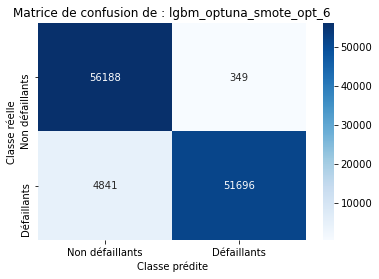

In [150]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_6',
                                        4733, 154, 232, 56383, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_6_train,0.0467,0.6010,0.0867,0.0484,0.0472,0.7787,0.2712,0.5528,2.4829,2.6594,0.9305,0.0006,0.7798,0.0049,0.1405,0.0017,0.0383,0.0030,0.9562,0.0027,0.5385,0.0326


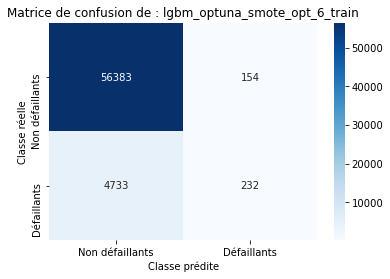

In [185]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6_train')

In [186]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_6_train',
                                        4733, 154, 232, 56383, df_taux)

#### <span style='background:Moccasin'>6.6.2. Rééquilibrage - oversampling : SMOTE auto</span>

In [121]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
                   random_state=seed)
X_train_smote_1, y_train_smote_1 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_1, y_valid_smote_1 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_1 = Counter(y_train_smote_1)
print(counter_smote_1)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [122]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_1 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_base_1,0.9105,0.9918,0.9494,0.9134,0.9113,0.9777,0.9840,0.9180,6.9061,7.1116,0.9798,0.0067,0.9694,0.0903,0.9116,0.0270,0.9060,0.2612,0.9917,0.0026,0.9912,0.0015


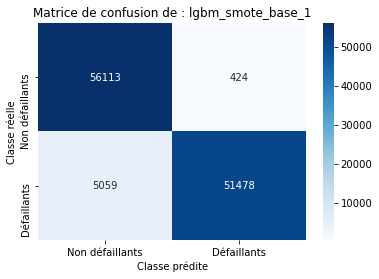

In [123]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_smote_base_1')

In [124]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_1',
                                        5059, 424, 51478, 56113, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_base_1_train,0.0403,0.5391,0.0750,0.0418,0.0407,0.7817,0.2703,0.5497,3.6184,3.7288,0.8357,0.0006,0.7839,0.0038,0.0579,0.0018,0.0384,0.0043,0.7482,0.0082,0.5449,0.0427


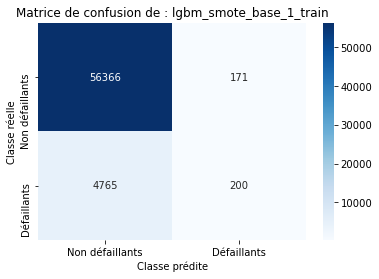

In [183]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_1_train')

In [184]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_1_train',
                                        4765, 171, 200, 56366, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [151]:
# Modèle et hyperparamètres à étudier
def create_model_8(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [152]:
# Objective fonction
def objective_8(trial):
    model = create_model_8(trial)
    model.fit(X_train_smote_1, y_train_smote_1)
    y_proba_smote_1 = model.predict_proba(X_valid_smote_1)[:,1]
    score = roc_auc_score(y_valid_smote_1, y_proba_smote_1)
    return score

In [153]:
# Recherche des paramètres
study_8 = optuna.create_study(direction='maximize')
study_8.optimize(objective_8, n_trials=100)

[I 2021-08-04 18:38:33,623] A new study created in memory with name: no-name-6dfb900e-9f71-49b0-9ed8-fcefd6ca0fbd
[I 2021-08-04 18:38:37,746] Trial 0 finished with value: 0.974244601638246 and parameters: {'max_depth': 4, 'subsample': 0.8437951690274346, 'colsample_bytree': 0.6030698231516743, 'reg_alpha': 3.356091926284127e-05, 'reg_lambda': 2.504592258398211e-08, 'num_leaves': 178, 'min_child_weight': 0.8441335139404849, 'subsample_freq': 5, 'min_child_samples': 100}. Best is trial 0 with value: 0.974244601638246.
[I 2021-08-04 18:38:41,204] Trial 1 finished with value: 0.9766460392767972 and parameters: {'max_depth': 7, 'subsample': 0.33535382101241684, 'colsample_bytree': 0.29318647637808437, 'reg_alpha': 0.0001098379017518139, 'reg_lambda': 0.1471343666595144, 'num_leaves': 62, 'min_child_weight': 0.9340710051346561, 'subsample_freq': 6, 'min_child_samples': 97}. Best is trial 1 with value: 0.9766460392767972.
[I 2021-08-04 18:38:44,754] Trial 2 finished with value: 0.975643133026

[I 2021-08-04 18:40:25,033] Trial 20 finished with value: 0.9756770120481782 and parameters: {'max_depth': 5, 'subsample': 0.6136335508508847, 'colsample_bytree': 0.8192451160394829, 'reg_alpha': 0.0012613424190752868, 'reg_lambda': 6.796355199214305e-06, 'num_leaves': 111, 'min_child_weight': 0.524260850574229, 'subsample_freq': 2, 'min_child_samples': 94}. Best is trial 16 with value: 0.9784733061561609.
[I 2021-08-04 18:40:32,477] Trial 21 finished with value: 0.9783024065603185 and parameters: {'max_depth': 10, 'subsample': 0.9627194901889033, 'colsample_bytree': 0.7061006198426555, 'reg_alpha': 0.0010089009466973124, 'reg_lambda': 0.000693002206567092, 'num_leaves': 84, 'min_child_weight': 0.799549868150958, 'subsample_freq': 1, 'min_child_samples': 89}. Best is trial 16 with value: 0.9784733061561609.
[I 2021-08-04 18:40:40,606] Trial 22 finished with value: 0.9782854029157155 and parameters: {'max_depth': 10, 'subsample': 0.9993619552364408, 'colsample_bytree': 0.876128650642781

[I 2021-08-04 18:43:03,604] Trial 40 finished with value: 0.97564092087318 and parameters: {'max_depth': 5, 'subsample': 0.8487273782432098, 'colsample_bytree': 0.9279424124993106, 'reg_alpha': 1.0802479820231236e-06, 'reg_lambda': 0.008938295840572324, 'num_leaves': 195, 'min_child_weight': 0.9492901176834299, 'subsample_freq': 6, 'min_child_samples': 7}. Best is trial 38 with value: 0.9787295471478189.
[I 2021-08-04 18:43:14,478] Trial 41 finished with value: 0.9786085450569407 and parameters: {'max_depth': 11, 'subsample': 0.9178944001214471, 'colsample_bytree': 0.8195792787216825, 'reg_alpha': 9.924395258115505, 'reg_lambda': 0.14253659206360086, 'num_leaves': 233, 'min_child_weight': 0.8722582245222833, 'subsample_freq': 4, 'min_child_samples': 45}. Best is trial 38 with value: 0.9787295471478189.
[I 2021-08-04 18:43:24,493] Trial 42 finished with value: 0.9784695156802174 and parameters: {'max_depth': 11, 'subsample': 0.8388236310307361, 'colsample_bytree': 0.8055293347636041, 'r

[I 2021-08-04 18:46:09,602] Trial 60 finished with value: 0.9763411718848101 and parameters: {'max_depth': 11, 'subsample': 0.11162707139942268, 'colsample_bytree': 0.69310976531744, 'reg_alpha': 0.06676225837565085, 'reg_lambda': 0.17455842871212435, 'num_leaves': 200, 'min_child_weight': 0.943971937502943, 'subsample_freq': 3, 'min_child_samples': 42}. Best is trial 52 with value: 0.9787449189731315.
[I 2021-08-04 18:46:20,024] Trial 61 finished with value: 0.9783494934317504 and parameters: {'max_depth': 11, 'subsample': 0.8320328196005344, 'colsample_bytree': 0.7894603992497133, 'reg_alpha': 0.019987620394862366, 'reg_lambda': 0.026283524403287767, 'num_leaves': 215, 'min_child_weight': 0.8913936918767352, 'subsample_freq': 3, 'min_child_samples': 38}. Best is trial 52 with value: 0.9787449189731315.
[I 2021-08-04 18:46:30,802] Trial 62 finished with value: 0.9781940432477205 and parameters: {'max_depth': 10, 'subsample': 0.8858050872706716, 'colsample_bytree': 0.7829553217922024, 

[I 2021-08-04 18:49:47,410] Trial 80 finished with value: 0.9785434071231557 and parameters: {'max_depth': 10, 'subsample': 0.994900716688925, 'colsample_bytree': 0.8956148514572523, 'reg_alpha': 1.761848033290022, 'reg_lambda': 7.654158157323965, 'num_leaves': 256, 'min_child_weight': 0.9558318627136893, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 75 with value: 0.9787586758729886.
[I 2021-08-04 18:50:00,042] Trial 81 finished with value: 0.9784763432922174 and parameters: {'max_depth': 11, 'subsample': 0.9797401957897042, 'colsample_bytree': 0.8600600180728959, 'reg_alpha': 0.7988858283861104, 'reg_lambda': 1.2825483360756436, 'num_leaves': 253, 'min_child_weight': 0.9144880367209627, 'subsample_freq': 5, 'min_child_samples': 26}. Best is trial 75 with value: 0.9787586758729886.
[I 2021-08-04 18:50:11,991] Trial 82 finished with value: 0.9786516330951345 and parameters: {'max_depth': 11, 'subsample': 0.9198275161089223, 'colsample_bytree': 0.8310519083833752, 'reg_al

In [154]:
params_8 = study_8.best_params
print(f'Nombre d\'essai terminés : {len(study_8.trials)}')
print('Best hyperparamètres:\n')
print(params_8)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9555831136302262, 'colsample_bytree': 0.9203501374870844, 'reg_alpha': 3.1787047319127395, 'reg_lambda': 3.652877957607085, 'num_leaves': 249, 'min_child_weight': 0.9823621917542201, 'subsample_freq': 6, 'min_child_samples': 33}


In [155]:
param_lgbm_optuna_opt_8 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.9203501374870844,
                           'max_depth': 11,
                           'min_child_samples': 33,
                           'min_child_weight': 0.9823621917542201,
                           'num_leaves': 249,
                           'reg_alpha': 3.1787047319127395,
                           'reg_lambda': 3.652877957607085,
                           'subsample': 0.9555831136302262,
                           'verbosity' : -1}

In [156]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_8 = LGBMClassifier(**param_lgbm_optuna_opt_8,
                                         force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_8,0.9116,0.9907,0.9495,0.9144,0.9123,0.9785,0.9845,0.9188,11.2609,11.5392,0.9904,0.0032,0.9722,0.0829,0.9249,0.0243,0.9093,0.2622,0.9959,0.0013,0.9909,0.0023


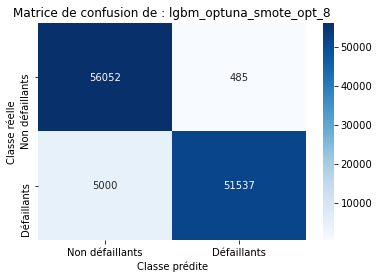

In [157]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8')

In [158]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_8',
                                        5000, 485, 51537, 56052, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_8_train,0.0526,0.5483,0.0959,0.0545,0.0530,0.7811,0.2738,0.5550,7.5945,7.7770,0.9445,0.0008,0.7830,0.0041,0.2005,0.0030,0.0459,0.0044,0.9705,0.0021,0.5047,0.0369


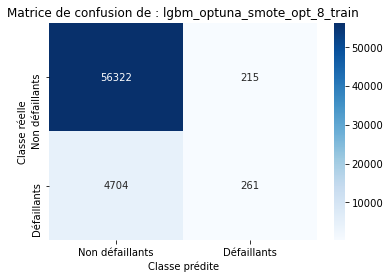

In [181]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8_train')

In [182]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_8_train',
                                        4704, 215, 261, 56322, df_taux)

#### <span style='background:Moccasin'>6.6.3. Rééquilibrage - combinaison oversampling/undersampling : SMOTE</span>

In [165]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)

# define pipeline
over = SMOTE(sampling_strategy=0.1, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_smote_combi, y_train_smote_combi = \
    pipeline.fit_resample(X_train, y_train)
X_valid_smote_combi, y_valid_smote_combi = \
    pipeline.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_combi = Counter(y_train_smote_combi)
print(counter_smote_combi)

Counter({0: 226145, 1: 19860})
Counter({0: 45228, 1: 22614})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [166]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_combi_base,0.4939,0.7026,0.5800,0.4996,0.4954,0.8023,0.6995,0.5608,0.9365,0.9874,0.8569,0.0047,0.8045,0.0488,0.5622,0.0055,0.4953,0.1252,0.7669,0.0090,0.6862,0.0330


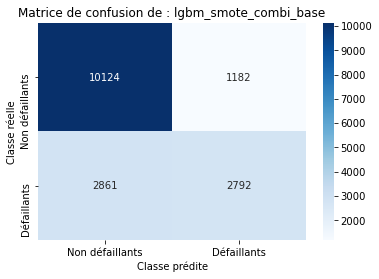

In [167]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_smote_combi_base')

In [168]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_base_2',
                                        2861, 1182, 2794, 10124, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_smote_combi_base_train,0.0403,0.5391,0.0750,0.0418,0.0407,0.7817,0.2703,0.5497,3.6119,3.7186,0.8357,0.0006,0.7839,0.0038,0.0579,0.0018,0.0384,0.0043,0.7482,0.0082,0.5449,0.0427


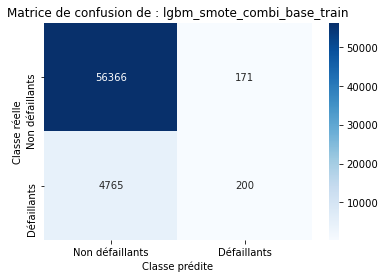

In [179]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_combi_base_train')

In [180]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_smote_combi_base_train',
                                        4765, 171, 200, 56366, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [169]:
# Modèle et hyperparamètres à étudier
def create_model_9(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [170]:
# Objective fonction
def objective_9(trial):
    model = create_model_9(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_proba_smote_combi = model.predict_proba(X_valid_smote_combi)[:,1]
    score = roc_auc_score(y_valid_smote_combi, y_proba_smote_combi)
    return score

In [171]:
# Recherche des paramètres
study_9 = optuna.create_study(direction='maximize')
study_9.optimize(objective_9, n_trials=100)

[I 2021-08-04 19:07:35,657] A new study created in memory with name: no-name-8bfd293a-8716-40af-b707-3e3cb79efff6
[I 2021-08-04 19:07:36,889] Trial 0 finished with value: 0.7749510434667425 and parameters: {'max_depth': 11, 'subsample': 0.16315660371077545, 'colsample_bytree': 0.3968637315939645, 'reg_alpha': 0.06393145902973255, 'reg_lambda': 0.005072560709429427, 'num_leaves': 120, 'min_child_weight': 0.7501116222665334, 'subsample_freq': 3, 'min_child_samples': 12}. Best is trial 0 with value: 0.7749510434667425.
[I 2021-08-04 19:07:37,951] Trial 1 finished with value: 0.7781432043882028 and parameters: {'max_depth': 10, 'subsample': 0.13399939738073463, 'colsample_bytree': 0.8533063739247371, 'reg_alpha': 4.093805228504244e-06, 'reg_lambda': 0.37722740052796133, 'num_leaves': 64, 'min_child_weight': 0.8013847271721353, 'subsample_freq': 5, 'min_child_samples': 25}. Best is trial 1 with value: 0.7781432043882028.
[I 2021-08-04 19:07:38,940] Trial 2 finished with value: 0.77697387713

[I 2021-08-04 19:07:57,793] Trial 20 finished with value: 0.8005077166211009 and parameters: {'max_depth': 6, 'subsample': 0.8359448958856809, 'colsample_bytree': 0.4704267334640904, 'reg_alpha': 0.021051307494387248, 'reg_lambda': 9.842207181950632e-05, 'num_leaves': 180, 'min_child_weight': 0.4002580402840206, 'subsample_freq': 3, 'min_child_samples': 29}. Best is trial 10 with value: 0.8021775694509355.
[I 2021-08-04 19:07:58,994] Trial 21 finished with value: 0.8002002352642313 and parameters: {'max_depth': 6, 'subsample': 0.9215285519256678, 'colsample_bytree': 0.5790561181039894, 'reg_alpha': 9.244222804068258, 'reg_lambda': 3.463853721747616e-08, 'num_leaves': 152, 'min_child_weight': 0.5419734517574396, 'subsample_freq': 5, 'min_child_samples': 40}. Best is trial 10 with value: 0.8021775694509355.
[I 2021-08-04 19:08:00,314] Trial 22 finished with value: 0.8011825108384362 and parameters: {'max_depth': 7, 'subsample': 0.9676599670750348, 'colsample_bytree': 0.5891831229359803, 

[I 2021-08-04 19:08:23,961] Trial 40 finished with value: 0.7994700687427052 and parameters: {'max_depth': 10, 'subsample': 0.5001616595972401, 'colsample_bytree': 0.41086366271329083, 'reg_alpha': 0.5608535997651115, 'reg_lambda': 0.5157213853087499, 'num_leaves': 22, 'min_child_weight': 0.812246579105872, 'subsample_freq': 3, 'min_child_samples': 15}. Best is trial 35 with value: 0.8035619239946515.
[I 2021-08-04 19:08:25,187] Trial 41 finished with value: 0.794170396304541 and parameters: {'max_depth': 11, 'subsample': 0.35152172755324096, 'colsample_bytree': 0.44605859029920286, 'reg_alpha': 2.750052430179565, 'reg_lambda': 0.015622487055269483, 'num_leaves': 107, 'min_child_weight': 0.9229544918020047, 'subsample_freq': 5, 'min_child_samples': 23}. Best is trial 35 with value: 0.8035619239946515.
[I 2021-08-04 19:08:26,327] Trial 42 finished with value: 0.7994896109885188 and parameters: {'max_depth': 11, 'subsample': 0.6147706533693491, 'colsample_bytree': 0.34923294031626995, 'r

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-04 19:08:32,374] Trial 47 finished with value: 0.8022124763768044 and parameters: {'max_depth': 11, 'subsample': 0.7425162042188426, 'colsample_bytree': 0.6227092331601012, 'reg_alpha': 4.936541751462978e-08, 'reg_lambda': 6.003440341085783, 'num_leaves': 31, 'min_child_weight': 0.9999431597395069, 'subsample_freq': 3, 'min_child_samples': 9}. Best is trial 35 with value: 0.8035619239946515.
[I 2021-08-04 19:08:33,120] Trial 48 finished with value: 0.778799309083821 and parameters: {'max_depth': 11, 'subsample': 0.6273478970452732, 'colsample_bytree': 0.3823008271526036, 'reg_alpha': 1.3134826662323228e-08, 'reg_lambda': 2.017108382286697, 'num_leaves': 3, 'min_child_weight': 0.9569265190384354, 'subsample_freq': 2, 'min_child_samples': 21}. Best is trial 35 with value: 0.8035619239946515.
[I 2021-08-04 19:08:34,292] Trial 49 finished with value: 0.8036182663702921 and parameters: {'max_depth': 10, 'subsample': 0.841766903442661, 'colsample_bytree': 0.491398078775452, 'reg_a

[I 2021-08-04 19:08:55,591] Trial 67 finished with value: 0.8009424650936218 and parameters: {'max_depth': 10, 'subsample': 0.8170096447782078, 'colsample_bytree': 0.5262084375557049, 'reg_alpha': 4.171369276850987e-08, 'reg_lambda': 0.008118818273872421, 'num_leaves': 88, 'min_child_weight': 0.8634272128621032, 'subsample_freq': 3, 'min_child_samples': 45}. Best is trial 58 with value: 0.804030233810063.
[I 2021-08-04 19:08:57,106] Trial 68 finished with value: 0.7977558586135256 and parameters: {'max_depth': 11, 'subsample': 0.7795215114948196, 'colsample_bytree': 0.4696206154516249, 'reg_alpha': 2.1122983227478352e-08, 'reg_lambda': 3.4004289665214756e-05, 'num_leaves': 120, 'min_child_weight': 0.9985066641732986, 'subsample_freq': 5, 'min_child_samples': 28}. Best is trial 58 with value: 0.804030233810063.
[I 2021-08-04 19:08:58,133] Trial 69 finished with value: 0.8012629641834914 and parameters: {'max_depth': 10, 'subsample': 0.6504410199308878, 'colsample_bytree': 0.591402407495

[I 2021-08-04 19:09:20,692] Trial 87 finished with value: 0.8027329197094704 and parameters: {'max_depth': 10, 'subsample': 0.9772543688260379, 'colsample_bytree': 0.5126885087918727, 'reg_alpha': 1.3872848914983726, 'reg_lambda': 0.0010976632175168418, 'num_leaves': 65, 'min_child_weight': 0.9645035823428304, 'subsample_freq': 6, 'min_child_samples': 47}. Best is trial 85 with value: 0.8048931593033497.
[I 2021-08-04 19:09:22,178] Trial 88 finished with value: 0.8026574418921726 and parameters: {'max_depth': 9, 'subsample': 0.9762826402701891, 'colsample_bytree': 0.9998252662076008, 'reg_alpha': 0.743770284352445, 'reg_lambda': 3.4745900224554706e-07, 'num_leaves': 53, 'min_child_weight': 0.8442325786263174, 'subsample_freq': 5, 'min_child_samples': 44}. Best is trial 85 with value: 0.8048931593033497.
[I 2021-08-04 19:09:23,324] Trial 89 finished with value: 0.8030955073831982 and parameters: {'max_depth': 10, 'subsample': 0.9289547622484182, 'colsample_bytree': 0.5549448714003518, '

In [172]:
params_9 = study_9.best_params
print(f'Nombre d\'essai terminés : {len(study_9.trials)}')
print('Best hyperparamètres:\n')
print(params_9)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9723735040993721, 'colsample_bytree': 0.4616050464859544, 'reg_alpha': 1.6448726003376717, 'reg_lambda': 3.9455847994603516e-07, 'num_leaves': 71, 'min_child_weight': 0.82285507797261, 'subsample_freq': 5, 'min_child_samples': 53}


In [173]:
param_lgbm_optuna_opt_9 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.4616050464859544,
                           'max_depth': 11,
                           'min_child_samples': 53,
                           'min_child_weight': 0.82285507797261,
                           'num_leaves': 71,
                           'reg_alpha': 1.6448726003376717,
                           'reg_lambda': 3.9455847994603516e-07,
                           'subsample': 0.9723735040993721,
                           'verbosity' : -1}

In [174]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_9 = LGBMClassifier(**param_lgbm_optuna_opt_9,
                                         force_col_wise=True)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_9,0.4990,0.6977,0.5819,0.5046,0.5004,0.8035,0.7000,0.5645,1.0841,1.1429,0.8948,0.0040,0.8051,0.0472,0.6175,0.0054,0.5007,0.1176,0.8206,0.0082,0.6902,0.0297


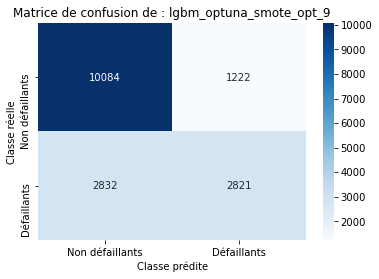

In [175]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9')

In [176]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_9',
                                        2832, 1222, 2821, 10084, df_taux)

Modèle,Rappel,Précision,F1,F5,F10,ROC_AUC,PR_AUC,Metier_score,Durée_train,Durée_tot,Train_roc_auc_CV,Train_roc_auc_CV +/-,Test_roc_auc_CV,Test_roc_auc_CV +/-,Train_recall_CV,Train_recall_CV +/-,Test_recall_CV,Test_recall_CV +/-,Train_precision_CV,Train_precision_CV +/-,Test_precision_CV,Test_precision_CV +/-
lgbm_optuna_smote_opt_9_train,0.0487,0.5475,0.0895,0.0505,0.0492,0.7846,0.2782,0.5533,2.7342,2.8579,0.8685,0.0006,0.7860,0.0043,0.0886,0.0015,0.0449,0.0044,0.8343,0.0057,0.5335,0.0452


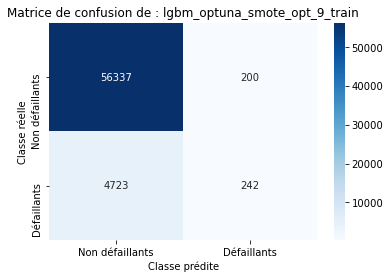

In [177]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9_train')

In [178]:
# Sauvegarde
df_taux = outils_model.sauvegarger_taux('lgbm_optuna_smote_opt_9_train',
                                        4723, 200, 242, 56337, df_taux)

#### <span style='background:Moccasin'>6.6.4. Rééquilibrage - LigthGbm - ASYNC</span>